In [8]:
#@title Imports
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.colheader_justify', 'center')
import numpy as np
import random
import time
import re

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from inspect import signature

def someMethod(self, arg1, kwarg1=None):
    pass

possession_data_seasons = np.arange(1974, 2023, 1)
play_by_play_data_seasons = np.arange(1997, 2023, 1)
pre_possesson_data_seasons = np.arange(1952, 1974, 1)
aba_seasons = np.arange(1974, 1977, 1)

# plot
import seaborn as sns
import ast
from matplotlib.lines import Line2D
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [ ]:
#@title Import Selenium
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
!pip install pyvirtualdisplay
!apt-get install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 800))  
display.start()
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('start-maximized')
options.add_argument('enable-automation')
options.add_argument('--disable-infobars')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-browser-side-navigation')
options.add_argument("--remote-debugging-port=9222")
# options.add_argument("--headless")
options.add_argument('--disable-gpu')
options.add_argument("--log-level=3")
wd = webdriver.Chrome(chrome_options=options)

**IMPORT RAW DATA**

In [3]:
#@title Manually add team abbrev, league_avg TS%, and teamcolors

aba_league_avg = pd.DataFrame(columns=['Year','TS%'])

aba_league_avg = aba_league_avg.append({
     "Year": "1974",
     "TS%":  .509, }, ignore_index=True)
aba_league_avg = aba_league_avg.append({
     "Year": "1975",
     "TS%":  .520, }, ignore_index=True)
aba_league_avg = aba_league_avg.append({
     "Year": "1976",
     "TS%":  .517, }, ignore_index=True)

league_avg_df = pd.DataFrame(columns=['Year','TS%'])

league_avg_df = league_avg_df.append({
     "Year": "2022",
     "TS%":  .566, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2021",
     "TS%":  .572, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2020",
     "TS%":  .565, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2019",
     "TS%":  .560, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2018",
     "TS%":  .556, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2017",
     "TS%":  .552, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2016",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2015",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2014",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2013",
     "TS%":  .535, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2012",
     "TS%":  .527, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2011",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2010",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2009",
     "TS%":  .544, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2008",
     "TS%":  .540, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2007",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2006",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({  
     "Year": "2005",
     "TS%":  .529, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2004",
     "TS%":  .516, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2003",
     "TS%":  .519, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2002",
     "TS%":  .520, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2001",
     "TS%":  .518, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2000",
     "TS%":  .523, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1999",
     "TS%":  .511, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1998",
     "TS%":  .524, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1997",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1996",
     "TS%":  .542, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1995",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1994",
     "TS%":  .528, }, ignore_index=True)
league_avg_df = league_avg_df.append({
      "Year": "1993",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1992",
     "TS%":  .531, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1991",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1990",
     "TS%":  .537, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1989",
     "TS%":  .537, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1988",
     "TS%":  .538, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1987",
     "TS%":  .538, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1986",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1985",
     "TS%":  .543, }, ignore_index=True)   
league_avg_df = league_avg_df.append({
     "Year": "1984",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1983",
     "TS%":  .531, }, ignore_index=True) 
league_avg_df = league_avg_df.append({
     "Year": "1982",
     "TS%":  .539, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1981",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
    "Year": "1980",
     "TS%":  .531, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1979",
     "TS%":  .530, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1978",
     "TS%":  .515, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1977",
     "TS%":  .511, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1976",
     "TS%":  .504, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1975",
     "TS%":  .502, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1974",
     "TS%":  .503, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1973",
     "TS%":  .498, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1972",
     "TS%":  .504, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1971",
     "TS%":  .500, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1970",
     "TS%":  .511, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1969",
     "TS%":  .491, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1968",
     "TS%":  .498, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1967",
     "TS%":  .493, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1966",
     "TS%":  .487, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1965",
     "TS%":  .479, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1964",
     "TS%":  .485, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1963",
     "TS%":  .493, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1962",
     "TS%":  .479, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1961",
     "TS%":  .469, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1960",
     "TS%":  .463, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1959",
     "TS%":  .457, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1958",
     "TS%":  .449, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1957",
     "TS%":  .449, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1956",
     "TS%":  .458, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1955",
     "TS%":  .455, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1954",
     "TS%":  .442, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1953",
     "TS%":  .445, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1952",
     "TS%":  .438, }, ignore_index=True)

team_colors = {"ATL": "#E03A3E", "BOS": "#007A33", "BRK": "#000000", "BUF": "#ff6314", "CAP": "#E31837", "CHA": "#00788C", 
               "CHI": "#CE1141", "CHO": "#f26631", "CLE": "#860038", "DAL": "#00538C", "DEN": "#0E2240", "DET": "#1D42BA",
               "GSW": "#FFC72C", "HOU": "#CE1141", "IND": "#002D62", "KCO": "#5A2D81", "KCK": "#5A2D81", "LAC": "#C8102E", 
               "LAL": "#552583", "MEM": "#5D76A9", "MIA": "#98002E", "MIL": "#00471B", "MIN": "#78BE20", "NOH": "#008fc5", 
               "NOP": "#85714D", "NOJ": "#00471B", "NJN": "#00275d", "NYK": "#006BB6", "OKC": "#007AC1", "ORL": "#0077C0", 
               "PHI": "#006BB6", "PHO": "#1D1160", "POR": "#E03A3E", "SAC": "#5A2D81", "SAS": "#C4CED4", "SEA": "#00653A", 
               "TOR": "#CE1141", "TOT": "pink", "UTA": "#00471B", "WAS": "#E31837", "WSB": "#E31837"}

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA", 
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC", 
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA", 
               "Washington Wizards": "WAS", "Capital Bullets": "CAP", "Buffalo Braves": "BUF", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "Charlotte Hornets": "CHH"}


aba_abbrev = {"Denver Nuggets": "DNA", "Indiana Pacers": "INA", "New York Nets": "NYA", "San Antonio Spurs": "SAA",
              "Virginia Squires": "VIR", "Carolina Cougars": "CAR", "San Diego Conquistadors": "SDA", "Kentucky Colonels": "KEN",
              "Utah Stars": "UTS", "Carolina Cougars": "CAR", "San Diego Sails": "SDS", "Spirits of St. Louis": "SSL",
              "Memphis Sounds": "MMS", "Denver Rockets": "DNR"}

team_52_73_abbrev = {"Milwaukee Hawks" : "MLH",  "Syracuse Nationals": "SYR",        "Minneapolis Lakers": "MNL",         "Rochester Royals": "ROC", 
               "Chicago Bulls": "CHI",      "Boston Celtics": "BOS",      "Cleveland Cavaliers": "CLE",     "Fort Wayne Pistons": "FTW",
               "Indianapolis Olympians": "INO",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "St. Louis Hawks": "STL",  "Los Angeles Lakers": "LAL",      "Philadelphia Warriors": "PHW",
               "Cincinnati Royals": "CIN",         "Milwaukee Bucks": "MIL", "San Diego Rockets": "SDR",     
               "New York Knicks": "NYK",   "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Baltimore Bullets": "BAL", "Buffalo Braves": "BUF", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "San Francisco Warriors": "SFW", "Atlanta Hawks": "ATL",
               "Chicago Packers": "CHP", "Chicago Zephyrs": "CHZ"}

In [4]:
#@title Import data and add team colors for advanced, play-by-play, per 100, and league avg data

# per 100 posssessions
#import_player_since74_per100_df = pd.read_csv('nba_player_since74_per100_data.csv')

# add team color for per 100 posssessions
#import_player_since74_per100_df['TeamColor'] = import_player_since74_per100_df['Tm'].map(team_colors)
# per 100 playoff posssessions
#import_player_since74playoffs_per100_df = pd.read_csv('nba_player_since74playoffs_per100_data.csv')
# add team color for playoff per 100 posssessions
#import_player_since74playoffs_per100_df['TeamColor'] = import_player_since74playoffs_per100_df['Tm'].map(team_colors)

# advanced
import_player_since74_advanced_df = pd.read_csv('nba_player_since74_advanced_data.csv', encoding='utf8')

# advanced playoffs
import_player_since74playoffs_advanced_df = pd.read_csv('nba_player_since74playoffs_advanced_data.csv', encoding='utf8')


# play-by-play
import_player_regular_playbyplay_df = pd.read_csv('nba_player_regular_playbyplay_data.csv', encoding='utf8')

# add team color for play-by-play
import_player_regular_playbyplay_df['TeamColor'] = import_player_regular_playbyplay_df['Tm'].map(team_colors)

# play-by-play playoffs
import_player_since74playoffs_playbyplay_df = pd.read_csv('nba_player_playoff_playbyplay_data.csv', encoding='utf8')

# add team color for playoff play-by-play
import_player_since74playoffs_playbyplay_df['TeamColor'] = import_player_since74playoffs_playbyplay_df['Tm'].map(team_colors)


# import league avg data

# league avg
import_leagueavgsince74_df = pd.read_csv('nba_leaguestats_data.csv')

# drop NBA seasons from inception of league until 1973 (final year without per possession data)
import_leagueavgsince74_df.drop(import_leagueavgsince74_df.tail(26).index,inplace=True)

# change from '2020-21' to '2021' and '2019-20' to '2020'... and so on
for i, trial in import_leagueavgsince74_df.iterrows():
   import_leagueavgsince74_df.loc[i, "Season"] = 2022-i

league_avg_df['Year'] = league_avg_df['Year'].astype(str)

In [5]:
#@title Import per 75 data (can be used in place of 'Calculate per 75' cells with necessitated imported data')

# per 75 posssessions
import_player_since74_per75_df = pd.read_csv('nba_player_since74_per75_data.csv')

# add team color for per 75 posssessions
import_player_since74_per75_df['TeamColor'] = import_player_since74_per75_df['Tm'].map(team_colors)

# per 75 playoff posssessions
import_player_since74playoffs_per75_df = pd.read_csv('nba_player_since74playoffs_per75_data.csv')

# add team color for playoff per 75 posssessions
import_player_since74playoffs_per75_df['TeamColor'] = import_player_since74playoffs_per75_df['Tm'].map(team_colors)

# per 75 adjusted ts playoff posssessions
#adjusted_playoff_per_75_df = pd.read_csv('/content/since74_adj_ts_playoffs_per75_data.csv')
# add team color for playoff per 75 adjusted posssessions
#adjusted_playoff_per_75_df['TeamColor'] = adjusted_playoff_per_75_df['Tm'].map(team_colors)

# era/opponent adjusted scoring
era_adj_reg_per_75_df = pd.read_csv('/content/era_adjusted_reg_per75_data.csv')
era_opponent_adj_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

In [6]:
#@title Create scoring coefficients

# era-adjust per game data
per_game_coeff = pd.read_csv('/content/Avg_Reg_PTS_G.csv', index_col=False, encoding='utf8')
per_game_coeff['Coefficient'] = per_game_coeff['Average PTS_G'].max() / per_game_coeff['Average PTS_G'] 

# era-adjust per 75 data
per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

#aba_per75_coeff = pd.read_csv('/content/Avg_ABA_Reg_PP75.csv', index_col=False, encoding='utf8')
#aba_per75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / aba_per75_coeff['Average PP75']

bpm_coeff = pd.read_csv('/content/Avg_Reg_BPM.csv', index_col=False, encoding='utf8')
bpm_coeff['Average BPM'] = bpm_coeff['Average BPM'] +  1
bpm_coeff['Average OBPM'] = bpm_coeff['Average OBPM'] + 1
bpm_coeff['BPM_Coefficient'] = bpm_coeff['Average BPM'].max() / bpm_coeff['Average BPM']
bpm_coeff['OBPM_Coefficient'] = bpm_coeff['Average OBPM'].max() / bpm_coeff['Average OBPM']

try:
  opponent_adj_pts_coeff = pd.DataFrame(columns = ['Year', 'Team', 'PTS_coeff'])

  team_def_rtg = pd.read_csv('NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
  league_avg_def_rtg = pd.read_csv('/content/Avg_Def_Rtg.csv', index_col=False, encoding='utf8')
  for idx, row in team_def_rtg.iterrows():
          match_df = league_avg_def_rtg[(league_avg_def_rtg['Year'] == row['Year'])]
          avg = match_df['Avg DefRtg']
          avg = float(avg)
          coeff = avg / row['DefRtg']

          new_row = {'Year':row['Year'], 'Team':row['Team'], 'PTS_coeff':coeff}
          opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)
          opponent_adj_pts_coeff = opponent_adj_pts_coeff.append(new_row, ignore_index=True)

  outfile = f"opponent_adj_pts_coeff.csv"
  opponent_adj_pts_coeff.to_csv(outfile, index=False)
except:
  pass

**Outputting Cells**

In [ ]:
#@title Single Playoffs Import
#sing = pd.read_csv('/content/52-73_era_opponent_adjusted_per75_data.csv', index_col=False, encoding='utf8')
#sing = sing.drop(['TeamColor', 'Pos', 'Age', 'GS', 'DRB', 'TRB', 'AST', 'STL', 'PF', 'FG', 'FGA', '3P', '3PA', 'TOV', '2P', '2PA', 'FG%', '3P%', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'BLK', 'Possessions','eFG%'], axis=1)

#sing = era_opponent_adj_playoff_per_75_df.copy()
#sing = sing.drop(['TeamColor', 'Pos', 'Age', 'GS', 'DRB', 'TRB', 'AST', 'STL', 'PF', 'ORtg', 'DRtg', 'FG', 'FGA', '3P', '3PA', 'TOV', '2P', '2PA', 'FG%', '3P%', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'BLK'], axis=1)

sing = sing.rename(columns={"Year": "Year", "Player": "Player", "Tm": "Team", "TS%+": "TS+", "PTS": "PP75"})

columns_titles = ['Year', 'Player', 'Team', 'PP75', 'TS+', 'MP', 'G']
sing = sing.reindex(columns=columns_titles)

sing['PP75'] = sing['PP75'].round(2)
sing['TS+'] = sing['TS+'].round(2)
sing['MP'] = sing['MP'].astype(int)

sing = sing.sort_values(by = ['Player', 'Year'], ascending = [True, True], na_position = 'first')

print(sing)
sing.to_csv("Single_Playoffs_Adjusted_Scoring.csv", index=False)


#@title Single Playoffs Custom Dataframes
#sing = era_opponent_adj_playoff_per_75_df.copy()
sing = sing.drop(['TeamColor', 'Pos', 'Age', 'GS', 'DRB', 'TRB', 'AST', 'STL', 'PF', 'ORtg', 'DRtg', 'FG', 'FGA', '3P', '3PA', 'TOV', '2P', '2PA', 'FG%', '3P%', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'BLK'], axis=1)

sing = sing.rename(columns={"Year": "Year", "Player": "Player", "Tm": "Team", "TS%+": "TS+", "PTS": "PP75"})

sing = sing.sort_values(by = ['Player', 'Year'], ascending = [True, True], na_position = 'first')

columns_titles = ['Year', 'Player', 'Team', 'PP75', 'TS+', 'MP', 'G']
sing = sing.reindex(columns=columns_titles)

sing['PP75'] = sing['PP75'].round(2)
sing['TS+'] = sing['TS+'].round(2)

sing['MP'] = sing['MP'].astype(int)
sing['G'] = sing['G'].astype(int)

sing = sing[(sing['MP'] >= 300)]
sing = sing[(sing['PP75'] >= 30)]
sing = sing[(sing['TS+'] >= 115)]

sing = sing.sort_values(by = ['Year', 'Player'], ascending = [True, True], na_position = 'first')

print(sing)
sing.to_csv("Single_Playoffs_Adjusted_Scoring.csv", index=False)

In [ ]:
#@title Single Playoffs Custom Dataframes
sing = pd.read_csv('/content/52-22_Single_Playoffs_Adjusted_Scoring.csv', index_col=False, encoding='utf8')

sing['MP'] = sing['MP'].astype(int)
sing['G'] = sing['G'].astype(int)

sing = sing[(sing['MP'] >= 300)]
sing = sing[(sing['PP75'] >= 30)]
sing = sing[(sing['TS+'] >= 115)]

sing = sing.sort_values(by = ['Year', 'Player'], ascending = [True, True], na_position = 'first')

print(sing)
#sing.to_csv("Single_Playoffs_Adjusted_Scoring.csv", index=False)

In [ ]:
#@title Edit Text
with open('/content/tmpurllist.txt', 'r') as f, open('better_format', 'w') as f1:
  Lines = f.readlines()
  
  count = 0
  # Strips the newline character
  for line in Lines:
    if "Player" in line:
      continue
    else:
      new_line = re.sub('/pla', r',/pla', line)
      print(new_line)
    f1.write(new_line)


In [ ]:
#@title Scrape League Average TS% Since 1974 (not working)
#@title Scrape NBA regular season advanced
def scrape_nba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html"
        
        wd = webdriver.Chrome('chromedriver',options=chrome_options)
        wd.get(league_stats_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)

        for first_div in soup.find_all('div', attrs={'id': '#content'}):
          second_div = first_div.find('div', attrs={'id': '#all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': '#advanced-team'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})
        print(rows)

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        advanced_stats = [e for e in advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(advanced_stats)):
             advanced_stats[i].insert(0, year)
        headers.insert(0, "Year")
        print(headers)

        each_year = pd.DataFrame(advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        league_avg_ts_df = league_avg_ts_df.append(each_year)

        # remove any Na
        league_avg_ts_df = league_avg_ts_df.dropna()
        
    # print final_df
    print(league_avg_ts_df.info)
    league_avg_ts_df.to_csv("nba_player_since74_advanced_data.csv", index=False)
scrape_nba_ts_data(all_the_years)

**NBA 1952-73 (estimated) DATA**

In [ ]:
#scrape_team_estimated_playoff_pace_data(pre_possesson_data_seasons)
#scrape_nba_player_pergame_data([pre_possesson_data_seasons])
#scrape_nba_player_advanced_data([pre_possesson_data_seasons])
#scrape_nba_player_pergame_data(pre_possesson_data_seasons)
#scrape_nba_player_total_mp_data(pre_possesson_data_seasons)

In [ ]:
#@title NBA 1952-73 Scrape Functions

# Scrape NBA Teams' Playoff Pace (1952-73 [estimated])
# Grab Team and Opponent Total stats to estimate pace of play for each NBA team from 1952-73
def scrape_team_estimated_playoff_pace_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'Pace/G', 'ORtg', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/playoffs/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)

        #Find table body of team stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-team'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year and pace column to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
             team_allowed_stats[i].insert(1, 0) 
        headers.insert(0, "Year")
        headers.insert(1, "Pace/G")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)
        each_years_teams = each_years_teams.sort_values('Team', ascending=True)

        # estimate pace
        if year >= 1971:
          ORB_percent = 0.319
        else:
          ORB_percent = 0.303
        if year >= 1971:
          TOV_percent = 0.158
        else:
          TOV_percent = 0.161
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FG'] = each_years_teams['FG'].astype(float)
        each_years_teams['G'] = each_years_teams['G'].astype(float)
        each_years_teams['Pace/G'] = (each_years_teams['FGA'] + (0.4 * each_years_teams['FTA']) - ORB_percent * (each_years_teams['FGA'] - each_years_teams['FG']) + (-TOV_percent * (each_years_teams['FGA'] + 0.44 * each_years_teams['FTA']) / (TOV_percent - 1)))
        each_years_teams['Ortg'] = (each_years_teams['PTS'] / each_years_teams['Pace/G']) * 100


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], axis=1, inplace=True)

        

        #Find table body of opponent stats
        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'switcher_per_game_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_game-opponent'})
          body = first_table.find('tbody')

        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each row
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        def_rtg_df = pd.DataFrame(team_allowed_stats, columns = headers)
        def_rtg_df = def_rtg_df.sort_values('Team', ascending=True)

        def_rtg_df['PTS'] = def_rtg_df['PTS'].astype(float)
        each_years_teams['Drtg'] = (def_rtg_df['PTS'] / each_years_teams['Pace/G']) * 100
        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_Estimated_Playoff_Pace_52-73_df.csv", index=False)

# Scrape NBA regular season per game (1952-73)
def scrape_nba_player_pergame_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = final_players_pergame_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_reg_pergame_data.csv", index=False)

# Scrape NBA regular season advanced (1952-73)
def scrape_nba_player_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP']
                                         )
    for year in years:
        print(year)
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        time.sleep(5)
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("52-73_reg_advanced_data.csv", index=False)

# Scrape NBA playoff per game (1952-73)
def scrape_nba_player_pergame_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = final_players_pergame_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_playoff_pergame_data.csv", index=False)

# Scrape NBA playoff totals (1952-73)
def scrape_nba_player_total_mp_data(years):

    final_players_pergame_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_totals.html"
        
        html = urlopen(player_base_url)
        time.sleep(5)
        time.sleep(5)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("PTS")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
             player_base_stats[i].insert(3, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        headers.insert(3, "Possessions")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        
        # append to final df
        final_players_pergame_df = final_players_pergame_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_pergame_df = final_players_pergame_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_pergame_df['Player'] = final_players_pergame_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_pergame_df = final_players_pergame_df.dropna()
        
    # print final_df
    print(final_players_pergame_df.info)
    final_players_pergame_df.to_csv("52-73_total_mp_playoff_data.csv", index=False)

In [ ]:
#@title NBA 1952-73 Ancillary Calculations

# NBA 1952-73 Calculate reg per 75 and TS+
pergame = pd.read_csv('52-73_reg_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('abbrev_52-73 reg pace ortg drtg.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  # changed team in middle of year. Two paces to account for.
  if row['Tm'] == 'TOT':
    print(row['Player'])
    print(row['Year'])
    continue
  # team folded and didn't play for another team that season.
  elif row['Tm'] == 'BLB' and row['Year'] == 1955:
    continue
  pergame.iat[idx, 31] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 31] = pergame.iat[idx, 31].astype(float)
  ind_poss_coeff = pergame.iat[idx, 31] / 75
  pergame.iat[idx, 30] = pergame.iat[idx, 30]  / ind_poss_coeff
pergame.to_csv("52-73_reg_per_75_data.csv", index=False)

# NBA 1952-73 Calculate playoff per 75 and TS+
pergame = pd.read_csv('52-73_playoff_pergame_data.csv', encoding='utf8', index_col=False)
pace_sup = pd.read_csv('Abbrev_Playoff_Pace_52-73.csv', encoding='utf8', index_col=False)


pergame['PTS'] = pergame['PTS'].astype(float)
pergame['MP'] = pergame['MP'].astype(float)
pace_sup['Pace/G'] = pace_sup['Pace/G'].astype(float)


for idx, row in pergame.iterrows():
  team = pace_sup[(pace_sup['Year'] == row['Year']) & (pace_sup['Team'] == row['Tm'])]
  team_pace = team['Pace/G']
  pergame.iat[idx, 31] = team_pace * (pergame.iat[idx, 9]/48)
  pergame.iat[idx, 31] = pergame.iat[idx, 31].astype(float)
  ind_poss_coeff = pergame.iat[idx, 31] / 75
  pergame.iat[idx, 30] = pergame.iat[idx, 30]  / ind_poss_coeff
pergame.to_csv("52-73_playoff_per_75_data.csv", index=False)


# Calculate average PTS per 75 (1952-73)
# year by year find what the league average PTS per 75 possessions was. Each row (player)'s points scaled for minutes.
avg_pts_per_75 = pd.read_csv('/content/52-73_reg_per_75_data.csv', index_col=False, encoding='utf8')
total_mp = 0
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  this_years_players['MP'] = this_years_players['MP'].astype(float)
  total_mp = this_years_players['MP'].sum()
  this_years_players['AdjPts'] = (this_years_players['PTS'].astype(float)) * (this_years_players['MP'].astype(float) / total_mp)
  running_pts_avg.append(this_years_players['AdjPts'].sum())

final_df['Year'] = year_list
final_df['Average PP75'] = running_pts_avg
        
final_df.to_csv("Avg_52-73_Reg_PP75.csv", index=False)


# Calculate average DefRtg (1952-73)
# year by year find what the league average DefRtg was.
avg_pts_per_75 = pd.read_csv('/content/abbrev_52-73 reg pace ortg drtg.csv', index_col=False, encoding='utf8')
running_pts_avg = []
year_list = []
final_df = pd.DataFrame()
for year in pre_possesson_data_seasons:
  year_list.append(year)
  this_years_players = avg_pts_per_75[(avg_pts_per_75['Year']) == year]
  running_pts_avg.append(this_years_players['Drtg'].mean())

final_df['Year'] = year_list
final_df['Average DefRtg'] = running_pts_avg
        
final_df.to_csv("Avg_52-73_Reg_PP75.csv", index=False)

# Replace Per 75 'MPG' with total 'MP'
per75 = pd.read_csv('52-73_playoff_per_75_data.csv', encoding='utf8', index_col=False)
total_mp = pd.read_csv('52-73_total_mp_playoff_data.csv', encoding='utf8', index_col=False)


per75['MP'] = total_mp['MP'].astype(int)
per75.to_csv("52-73_playoff_per_75_data.csv", index=False)

**ABA 1974-76 DATA**

In [ ]:
#scrape_aba_player_per100_data(aba_seasons)
#scrape_aba_advanced_data(aba_seasons)
#scrape_nba_player_per100_aba_data(aba_seasons)
#scrape_team_ts_allowed_data(aba_seasons)
#scrape_nba_player_reg_avg_per_100(aba_seasons)
#scrape_team_defrtg_allowed_data(aba_seasons)
#scrape_nba_player_avg_defrtg(aba_seasons)

In [ ]:
#@title ABA 1974-76 Scrape Functions
# Scrape ABA regular season per 100
def scrape_aba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("aba_player_since74_per100_data.csv", index=False)

# Scrape ABA regular season advanced
def scrape_aba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("aba_player_since74_advanced_data.csv", index=False)

# Scrape ABA playoffs per 100
def scrape_nba_player_per100_aba_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_aba_data.csv", index=False)

# Scrape ABA Teams' TS% Allowed
def scrape_team_ts_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape ABA Reg Avg Per 75 Scoring
def scrape_nba_player_reg_avg_per_100(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/ABA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = {'Year':year, 'Average PP75':running_pts_avg}
        final_df = final_df.append(new_row, ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_ABA_Reg_PP75.csv", index=False)

# Scrape ABA Teams' DefRtg 
def scrape_team_defrtg_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(aba_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("ABA_Team_defrtg_Allowed_df.csv", index=False)

# Scrape ABA League Avg DefRtg
def scrape_nba_player_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])
    
  for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/ABA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = {'Year':year, 'Avg DefRtg':avg_def_rtg}
        final_team_data_df = final_team_data_df.append(new_row, ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)
        print(new_row)
        
  # print final_df
  final_team_data_df.to_csv("Avg_ABA_Def_Rtg.csv", index=False)

In [ ]:
#@title ABA 1974-76 Ancillary Calculations

# Calculate ABA reg per 75 points
aba_per100_reg_df = pd.read_csv('/content/aba_player_since74_per100_data.csv')
aba_per100_reg_df['PTS'] = aba_per100_reg_df['PTS'] * .75
aba_advanced_reg_df = pd.read_csv('/content/aba_player_since74_advanced_data.csv')


# Add ABA reg TS+
# TS% from advanced dataframge (aba_advanced_reg_df.iat[j, 9]) divided by league average TS% (aba_league_avg.iat[yearloop, 1])
i = 1976
for yearloop in range(49):
  for j, row in aba_per100_reg_df.iterrows():
    if row['Year'] == i:
      aba_per100_reg_df.iat[j, 1] = (aba_advanced_reg_df.iat[j, 9] / aba_league_avg.iat[yearloop, 1]) * 100
  i = i - 1

aba_per100_reg_df = aba_per100_reg_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"aba_per75_reg_data.csv"
aba_per100_reg_df.to_csv(outfile, index=False)

**NBA 1974-2022 DATA**

In [ ]:
#scrape_nba_player_reg_per100_data(possession_data_seasons)
#scrape_nba_player_post_per100_data(possession_data_seasons)
#scrape_nba_advanced_reg_data(possession_data_seasons)
#scrape_nba_advanced_post_data(possession_data_seasons)
#scrape_nba_reg_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_post_playbyplay_data(play_by_play_data_seasons)
#scrape_nba_leaguestats_data(possession_data_seasons)
#scrape_nba_player_reg_avg_per_75(possession_data_seasons)
#scrape_nba_player_playoff_avg_per_75(possession_data_seasons)
#scrape_nba_player_reg_bpm_avg(possession_data_seasons)
#scrape_team_ts_allowed_data(all_the_years)
#scrape_team_defrtg_allowed_data(all_the_years)
#scrape_nba_player_avg_defrtg(all_the_years)

In [ ]:
#@title NBA 1974-2022 Scrape Functions

# Scrape NBA regular season per 100
def scrape_nba_player_reg_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74_per100_data.csv", index=False)

# Scrape NBA playoffs per 100
def scrape_nba_player_post_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_data.csv", index=False)

# Scrape NBA regular season advanced
def scrape_nba_reg_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])
        final_players_advanced_df['Player'].apply(unidecode)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74_advanced_data.csv", index=False)

# Scrape NBA playoffs advanced
def scrape_nba_post_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74playoffs_advanced_data.csv", index=False)

# Scrape NBA regular season play-by-play
def scrape_nba_reg_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_regular_playbyplay_data.csv", index=False)

# Scrape NBA playoffs play-by-play
# import needed libraries
def scrape_nba_post_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_playoff_playbyplay_data.csv", index=False)

# Scrape NBA regular season league average
def scrape_nba_leaguestats_data():

        final_leaguestats_df = pd.DataFrame(columns = ['Year',	'Lg',	'Age',	'Ht',	'Wt',	'G',	'MP',	'FG',	'FGA',	'3P',
                                                      '3PA',	'FT',	'FTA',	'ORB',	'DRB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',
                                                      'PF',	'PTS',	'FG%',	'3P%',	'FT%',	'Pace',	'eFG%',	'TOV%',	'ORB%',
                                                      'FT/FGA',	'ORtg', 'TS%'])
        
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("ORtg")+1]
        headers.insert(32, "TS%")
        print(headers)

        # grab rows (excluding first empty row 0)
        #rows = soup.findAll('tr', class=None)[1:]
        rows = soup.findAll('tr', class_=None)[1:]


        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        for i in range(0, len(player_base_stats)):
          player_base_stats[i].insert(32, 0)

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        final_leaguestats_df = pd.DataFrame(player_base_stats, columns = headers)

        final_leaguestats_df = final_leaguestats_df.drop(['Lg'], axis=1)

        final_leaguestats_df = final_leaguestats_df.iloc[1: , :]

        final_leaguestats_df.drop(final_leaguestats_df.index[20])
        final_leaguestats_df.drop(final_leaguestats_df.index[21])
        
        # print final_df
        print(final_leaguestats_df.info)
        final_leaguestats_df.to_csv("nba_leaguestats_data.csv", index=False)

# Scrape Reg Avg Per 75 Scoring
def scrape_nba_player_reg_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        new_row = {'Year':year, 'Average PP75':running_pts_avg}
        final_df = final_df.append(new_row, ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_Reg_PP75.csv", index=False)

# Scrape Playoff Avg Per 75 Scoring
def scrape_nba_player_playoff_avg_per_75(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average PP75'])
    for year in years:
        total_mp = 0
        running_pts_avg = 0
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['PTS'] = each_year['PTS'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['AdjPts'] = (each_year['PTS'].astype(float) * .75) * (each_year['MP'].astype(float) / total_mp)
        running_pts_avg = each_year['AdjPts'].sum()
        year = year.astype(int)
        new_row = {'Year':year, 'Average PP75':running_pts_avg}
        final_df = final_df.append(new_row, ignore_index=True)
        
    # print final_df
    print(final_df.info)
    final_df.to_csv("Avg_Playoff_PP75.csv", index=False)

# Scrape Reg Avg BPM
def scrape_nba_player_reg_bpm_avg(years):

    final_df = pd.DataFrame(columns = ['Year', 'Average BPM', 'Average OBPM'])
    for year in years:
        total_mp = 0
        running_bpm_avg = 0
        running_obpm_avg = 0
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)
        each_year = each_year[each_year['MP'] != '0']

        each_year['BPM'] = each_year['BPM'].astype(float)
        each_year['OBPM'] = each_year['OBPM'].astype(float)
        each_year['MP'] = each_year['MP'].astype(float)

        total_mp = each_year['MP'].sum()
        each_year['adjBPM'] = each_year['BPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        each_year['adjOBPM'] = each_year['OBPM'].astype(float) * (each_year['MP'].astype(float) / total_mp)
        running_bpm_avg = each_year['adjBPM'].sum()
        running_obpm_avg = each_year['adjOBPM'].sum()

        running_bpm_avg = running_bpm_avg + 1
        running_obpm_avg = running_obpm_avg + 1


        new_row = {'Year':year, 'Average BPM':running_bpm_avg, 'Average OBPM':running_obpm_avg}
        final_df = final_df.append(new_row, ignore_index=True)
        final_df['Year'] = final_df['Year'].astype(int)
        
    # print final_df
    final_df.to_csv("Avg_Reg_BPM.csv", index=False)

# Scrape NBA Teams' TS% Allowed
def scrape_team_ts_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_TS_Percentage_Allowed_df.csv", index=False)

# Scrape NBA Teams' DefRtg 
def scrape_team_defrtg_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team', 'DefRtg'])
    
    for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_defrtg_Allowed_df.csv", index=False)

# Scrape League Avg DefRtg
def scrape_nba_player_avg_defrtg(years):

  final_team_data_df = pd.DataFrame(columns = ['Year', 'Avg DefRtg'])
    
  for year in years:

        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'per_poss-opponent'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year)
        headers.insert(0, "Year")
        

        each_year = pd.DataFrame(team_allowed_stats, columns = headers)

        each_year['PTS'] = each_year['PTS'].astype(float)
        avg_def_rtg = each_year['PTS'].mean()



        new_row = {'Year':year, 'Avg DefRtg':avg_def_rtg}
        final_team_data_df = final_team_data_df.append(new_row, ignore_index=True)
        final_team_data_df['Year'] = final_team_data_df['Year'].astype(int)
        print(new_row)
        
  # print final_df
  final_team_data_df.to_csv("Avg_Def_Rtg.csv", index=False)

In [ ]:
#@title NBA 1974-2022 Ancillary Calculations

# Calculate NBA reg per 75 points
import_player_since74_per75_df = import_player_since74_per100_df.copy()
import_player_since74_per75_df['PTS'] = import_player_since74_per75_df['PTS'] * .75

# Add NBA reg TS+
# TS% from advanced dataframge (import_player_since74_advanced_df.iat[j, 9]) divided by league average TS% (league_avg_df.iat[yearloop, 1])
i = 2022
for yearloop in range(49):
  for j, row in import_player_since74_per75_df.iterrows():
    if row['Year'] == i:
      import_player_since74_per75_df.iat[j, 1] = (import_player_since74_advanced_df.iat[j, 9] / league_avg_df.iat[yearloop, 1]) * 100
  i = i - 1

import_player_since74_per75_df = import_player_since74_per75_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"nba_player_since74_per75_data.csv"
import_player_since74_per75_df.to_csv(outfile, index=False)



# Calculate Playoffs per 75
#import_player_since74playoffs_per75_df = import_player_since74playoffs_per100_df.copy()
#import_player_since74playoffs_per75_df['PTS'] = import_player_since74playoffs_per75_df['PTS'] * .75

aba_per75_pts = pd.read_csv('/content/aba_player_since74playoffs_per100_data.csv')
aba_per75_pts['PTS'] = aba_per75_pts['PTS'] * .75

outfile = f"aba_player_since74playoffs_per75_data.csv"
aba_per75_pts.to_csv(outfile, index=False)

**SCRAPE URL DATA**

In [ ]:
#@title Scrape NBA Player URL's (1952-73)
# import needed libraries
def scrape_url_data_52_73(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_game.html"
        
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(10)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_game_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_game_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_52-73_URL_data.csv", index=False)
scrape_url_data_52_73(pre_possesson_data_seasons)

In [ ]:
#@title Scrape ABA Player URL's (1974-76)
# import needed libraries
def scrape_url_data_aba(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/ABA_{year}_per_poss.html"
        
        wd.get(page_url)       
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(15)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_poss_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_aba_URL_data.csv", index=False)
scrape_url_data_aba([1974, 1975, 1976])

In [ ]:
#@title Scrape NBA Player URL's (1974-2022)
# import needed libraries
def scrape_url_data_74(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(15)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_poss_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_since_74_URL_data.csv", index=False)
scrape_url_data_74(all_the_years)

In [ ]:
#@title Scrape NBA Player URL's (1997-2022)
# import needed libraries
def scrape_url_data_97(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        print(year)
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        time.sleep(15)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_pbp_stats'})
          first_table = second_div.find('table', attrs={'id': 'pbp_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_URL_data.csv", index=False)
scrape_all_distribution_data(some_of_the_years)

In [ ]:
#@title Shorten URL list to only players with >x playoff minutes
def nba_shorten_url_list_by_x(url_df, min_requirement):

    new_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      og_url = url
      url = "https://www.basketball-reference.com" + url
      

      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)
      time.sleep(5)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_advanced-playoffs_advanced'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_advanced'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      only_for_mp = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      only_for_mp = [e for e in only_for_mp if e != []]

      url_data = pd.DataFrame(only_for_mp)

      tmp_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])
      

      # took only long mid range FGA
      if int(url_data[5]) <= min_requirement:
        continue
      else:
        mp = int(url_data[5])

      tmp_df.loc[len(tmp_df)] = [player, og_url, mp]
      new_df = new_df.append(tmp_df)
      outfile = f"NBA_Player_97_URL_List_{min_requirement}_Min_df.csv"
      new_df.to_csv(outfile, index=False)
      print(tmp_df)

In [ ]:
player_urls = pd.read_csv('/content/donny boy.csv', index_col=False, encoding='utf8')
nba_shorten_url_list_by_x(player_urls, 1000)

**NBA 1952-73 ADJUSTED PLAYOFF TS+ (Opponent Adjustment)**

In [ ]:
#@title NBA 1952-73 Adjusted Playoff TS+
def adjust_scoring_efficiency(url_df, tmp_league_avg_df, opp_defrtg_df, rr_df):
    from itertools import chain

    tmp_league_avg_df['Year'] = tmp_league_avg_df['Year'].astype(int)
    tmp_league_avg_df['Year'] = tmp_league_avg_df['Year'].astype(str)

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(5)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        header = first_table.find('thead')
        body = first_table.find('tbody')

      headers = [th.getText() for th in header.findAll('tr', limit=2)[1].findAll('th')]
      try:
        headers[32] = 'MP/G'
        headers[33] = 'PTS/G'
         # grab rows
        rows = body.findAll('tr')[0:]
        series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
        # remove empty rows
        series_stats = [e for e in series_stats if e != []]
        series_stats = ([i for i in series_stats if i[0] != 'Year'])
        series_data = pd.DataFrame(series_stats, columns = headers)
        missing_mp_data = series_data.copy()
        missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      except:
        try:
          headers[31] = 'MP/G'
          headers[32] = 'PTS/G'
          # grab rows
          rows = body.findAll('tr')[0:]
          series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
          # remove empty rows
          series_stats = [e for e in series_stats if e != []]
          series_stats = ([i for i in series_stats if i[0] != 'Year'])
          series_data = pd.DataFrame(series_stats, columns = headers)
          missing_mp_data = series_data.copy()
          missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
        except:
          try:
            headers[30] = 'MP/G'
            headers[31] = 'PTS/G'
            # grab rows
            rows = body.findAll('tr')[0:]
            series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
            # remove empty rows
            series_stats = [e for e in series_stats if e != []]
            series_stats = ([i for i in series_stats if i[0] != 'Year'])
            series_data = pd.DataFrame(series_stats, columns = headers)
            missing_mp_data = series_data.copy()
            missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
          except:
            try:
              headers[29] = 'MP/G'
              headers[30] = 'PTS/G'
              # grab rows
              rows = body.findAll('tr')[0:]
              series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
              # remove empty rows
              series_stats = [e for e in series_stats if e != []]
              series_stats = ([i for i in series_stats if i[0] != 'Year'])
              series_data = pd.DataFrame(series_stats, columns = headers)
              missing_mp_data = series_data.copy()
              missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
            except:
              try:
                headers[27] = 'MP/G'
                headers[28] = 'PTS/G'
                # grab rows
                rows = body.findAll('tr')[0:]
                series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
                # remove empty rows
                series_stats = [e for e in series_stats if e != []]
                series_stats = ([i for i in series_stats if i[0] != 'Year'])
                series_data = pd.DataFrame(series_stats, columns = headers)
                missing_mp_data = series_data.copy()
                missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
              except:
                try:
                  headers[24] = 'MP/G'
                  headers[25] = 'PTS/G'
                  # grab rows
                  rows = body.findAll('tr')[0:]
                  series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
                  # remove empty rows
                  series_stats = [e for e in series_stats if e != []]
                  series_stats = ([i for i in series_stats if i[0] != 'Year'])
                  series_data = pd.DataFrame(series_stats, columns = headers)
                  missing_mp_data = series_data.copy()
                  missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
                except:
                  headers[19] = 'MP/G'
                  headers[20] = 'PTS/G'
                  # grab rows
                  rows = body.findAll('tr')[0:]
                  series_stats = [[td.getText() for td in rows[i].findAll(['td','th'])] for i in range(len(rows))]
                  # remove empty rows
                  series_stats = [e for e in series_stats if e != []]
                  series_stats = ([i for i in series_stats if i[0] != 'Year'])
                  series_data = pd.DataFrame(series_stats, columns = headers)
                  missing_mp_data = series_data.copy()
                  missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      
      # drop seasons which have definite possession data (as opposed to estimated data being generated)
      series_data['Year'] = series_data['Year'].replace("1992", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1991", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1990", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1989", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1988", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1987", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1986", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1985", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1984", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1983", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1982", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1981", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1980", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1979", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1978", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1977", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1976", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1975", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1974", float('NaN'))

      # remove seasons preceding 1952
      series_data['Year'] = series_data['Year'].replace("1951", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1950", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1949", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1948", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1947", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1946", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1945", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1944", float('NaN'))

      # convert ABA seasons to NaN and drop
      series_data['Team'] = series_data['Team'].replace("DNR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DNA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SSL", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("VIR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SAA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("INA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("UTS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("LAS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("KEN", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("CAR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMT", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DLC", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("PTP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MNP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("FLO", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("TEX", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("ANA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMF", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NOB", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("OAK", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))    

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)
      series_data = series_data.reset_index()

      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['G'] = series_data['G'].astype(float)

      
      # may be missing MP data.
      # divide the missing estimated total numbers equally among games w/o MP data.
      missing_mp_data = series_data.copy()
      missing_mp_data = missing_mp_data[(missing_mp_data['MP'] == '')]
      years_list = []
      
      remaining_mp = []
      missing_index = 0
      
      
      for mp_idx, row in missing_mp_data.iterrows():

        g_list = []
        current_year = missing_mp_data.loc[mp_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which MP aren't accounted for
          working_missing_year = missing_mp_data[(missing_mp_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # MP accounted for 
          accounted_for_mp = series_data[(series_data['Year'] == current_year)]
          accounted_for_mp['MP'] = accounted_for_mp['MP'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_mp.dropna(inplace=True)
          accounted_for_mp = (accounted_for_mp['MP'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total MP
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x <= 1973 and x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          

          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_mp = selected_year['MP'].astype(float)
          

          # remaining MP contains estimated MP for this year's series with missing MP
          remaining_mp.append(total_mp - accounted_for_mp)

          through = 0
          for idx in i_list:
            idx = int(idx)
            if working_missing_year.shape[0]  == 1:
              series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index])
            elif working_missing_year.shape[0]  == 2:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0]  == 3:
              if through == 0:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data.loc[idx, ["MP"] ] = float(remaining_mp[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      # may be missing FGA data.
      # divide the missing estimated total numbers equally among games w/o FGA data.
      missing_fg_data = series_data.copy()
      missing_fg_data = missing_fg_data[(missing_fg_data['FGA'] == '')]
      years_list = []
      remaining_fg = []
      missing_index = 0

      for fg_idx, row in missing_fg_data.iterrows():

        g_list = []
        current_year = missing_fg_data.loc[fg_idx,'Year']
        i_list = []

        lookadead_working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
        for lk_idx, row in lookadead_working_missing_year.iterrows():
          i_list.append(lk_idx)
        if current_year not in years_list:

          # games in which FGA aren't accounted for 
          working_missing_year = missing_fg_data[(missing_fg_data['Year'] == current_year)]
          working_missing_year = working_missing_year.reset_index()
          if working_missing_year.shape[0] == 2:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
          if working_missing_year.shape[0]  == 3:
            g_list.append(working_missing_year.loc[0,'G'])
            g_list.append(working_missing_year.loc[1,'G'])
            g_list.append(working_missing_year.loc[2,'G'])

          # FGA accounted for 
          accounted_for_fg = series_data[(series_data['Year'] == current_year)]
          accounted_for_fg['FGA'] = accounted_for_fg['FGA'].replace(r'^s*$', float('NaN'), regex = True)
          accounted_for_fg.dropna(inplace=True)
          accounted_for_fg = (accounted_for_fg['FGA'].astype(float)).sum()

          years_list.append(current_year)

          # scrape total FGA
          for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'switcher_totals-playoffs_totals'})
            first_table = second_div.find('table', attrs={'id': 'playoffs_totals'})
            header = first_table.find('thead')
            body = first_table.find('tbody')

          headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]

          # grab years
          rows = body.findAll('tr')[0:]
          player_years = [[th.getText() for th in rows[i].findAll('th')] for i in range(len(rows))]
          player_years = [e for e in player_years if e != []]
          from itertools import chain
          player_years = list(chain.from_iterable(player_years))
          formatted_years = []
          for formatted_year in player_years:
            formatted_year = re.sub(r"[0-9]+-", r"19", formatted_year)
            formatted_years.append(formatted_year)
          formatted_years = [eval(i) for i in formatted_years]
          formatted_years = [x for x in formatted_years if x <= 1973 and x >= 1952]

          # grab total stats
          rows = body.findAll('tr')[0:]
          player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
          player_total_stats = [e for e in player_total_stats if e != []]
          player_total_stats = ([i for i in player_total_stats if i[6] != ''])

          iteration = 0
          # add year to each player profile
          for i in range(0, len(formatted_years)):
              player_total_stats[i].insert(0, formatted_years[iteration])
              iteration = iteration + 1
          headers[0] = 'Year'
          
          each_year = pd.DataFrame(player_total_stats, columns = headers)
          each_year['Year'] = each_year['Year'].astype(str)
          selected_year = each_year[(each_year['Year'] == current_year)]
          total_fg = selected_year['FGA'].astype(float)
          selected_year['Tm'] = selected_year['Tm'].astype(str)


          

          # remaining FGA contains estimated FGA for this year's series with missing FGA
          remaining_fg.append(total_fg - accounted_for_fg)
          
          through = 0
          for idx in i_list:
            if working_missing_year.shape[0] == 1:
              series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index])
            elif working_missing_year.shape[0] == 2:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]))
                through = through + 1
              else:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]))
            elif working_missing_year.shape[0] == 3:
              if through == 0:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[0] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              elif through == 1:
                series_data.loc[idx, ["FGA"] ] = float(remaining_fg[missing_index]) * (g_list[1] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
              else:
                series_data['FGA'].iat[idx] = float(remaining_fg[missing_index]) * (g_list[2] / (g_list[0] + g_list[1]+ g_list[2]))
                through = through + 1
          missing_index = missing_index + 1
      series_data['FGA'] = series_data['FGA'].astype(float)
      series_data['TS+'] = 0
      years_list = []
      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        # get defrtg allowed by opponent
        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        this_year = tmp_league_avg_df[(tmp_league_avg_df['Year'] == current_year)]
        league_avg_ts_this_year = this_year['TS%']

        league_avg_ts_this_year = float(league_avg_ts_this_year)

        # estimate TS+ allowed
        predicted_TS_plus_allowed = lr.predict([[pts_coeff]])

        #find raw TS% compared to league average
        raw_ts_allowed = league_avg_ts_this_year * predicted_TS_plus_allowed

        if row['PTS'] == 0:
          tsplus = 0
        else:
          tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(raw_ts_allowed)) * 100
        series_data.loc[i,'TS+'] = tsplus
        series_data.loc[i, 'PTS_coeff'] = pts_coeff
        if series_data.loc[i,'Year'] not in years_list:
          years_list.append(series_data.loc[i,'Year'])
      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)
        new_row = {'Player':player, 'Year':year, 'TS+':total_ts, 'PTS_coeff':total_coeff, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"NBA_Playoff_Estimated_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)

In [ ]:
#@title Run Adjusted Playoff TS+ Scrape

# correlation will be used to estimate TS%'s allowed by teams from 1952-1973
rdRtg = pd.read_csv("/content/remove reg teams.csv", index_col=False, encoding='utf8')
rTS = pd.read_csv("/content/NBA_Team_TS_Percentage_Allowed_df.csv", index_col=False, encoding='utf8')

rTS['Year'] = rTS['Year'].astype(int)
league_avg_df['Year'] = league_avg_df['Year'].astype(float)

rTS['rTS'] = 0

for idx, row in rTS.iterrows():     
          match_df = league_avg_df[(league_avg_df['Year'] == row['Year'])]
          rTS.iat[idx, 3] = float(rTS.iat[idx, 2] / (match_df['TS%']))
          
rTS = rTS.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')
rdRtg = rdRtg.sort_values(by = ['Year', 'Team'], ascending = [True, True], na_position = 'first')

import scipy.stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
x_pred = rdRtg['PTS_coeff']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = rTS['rTS']

lr = linear_model.LinearRegression()
lr.fit(x_pred, y_pred)
pred = lr.predict(x_pred)
#plt.plot(x_pred, pred, color="blue", linewidth=3)
#plt.scatter(rdRtg['PTS_coeff'], rTS['rTS'])

# Run Adjusted Playoff TS+ Scrape
url_txt_df = pd.read_csv('/content/problematic.csv', index_col=False, encoding='utf8')
url_txt_df = url_txt_df.drop('MP', axis=1)
opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
rr_df = pd.read_csv('/content/RR_df.csv', index_col=False, encoding='utf8')

adjust_scoring_efficiency(url_txt_df, league_avg_df, opponent_adj_pts_coeff, rr_df)

In [ ]:
#@title Create DataFrame of Adjusted TS+ Data and Adjust for Era
start_to_ajust_playoffs_per_75 = pd.read_csv('/content/52-73_playoff_per_75_data.csv', index_col=False, encoding='utf8')
adj_ts_list = pd.read_csv('NBA_Playoff_Estimated_TS_df.csv', index_col=False, encoding='utf8')

names = [x for x in start_to_ajust_playoffs_per_75.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  start_to_ajust_playoffs_per_75['Player'] = start_to_ajust_playoffs_per_75['Player'].astype(str)
  start_to_ajust_playoffs_per_75['Year'] = start_to_ajust_playoffs_per_75['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = start_to_ajust_playoffs_per_75[(start_to_ajust_playoffs_per_75['Player'] == current_player) & ((start_to_ajust_playoffs_per_75['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = adjusted_playoff_per_75_df.append(smaller_start_adj_list, ignore_index=True)
outfile = f"since52_adj_ts_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)

# Era Adjustment
playoff_75_data = pd.read_csv('since52_adj_ts_playoffs_per75_data.csv')

per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = new_df.append(row)
outfile = f"52-73_era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

In [ ]:
#@title Remove round robin data
       # remove round robin data
          if current_year == '1954':
            remove_rr_url = url + "/gamelog/1954"
            time.sleep(5)
            wd.get(remove_rr_url)
            html = wd.page_source
            soup = BeautifulSoup(html)
            rr_df
            selected_year = selected_year.sort_index(inplace=True)
            rr_df = rr_df.sort_index(inplace=True)
            print(selected_year['Tm'])

            rr_df['Team'] = rr_df['Team'].astype(str)

            selected_rr = rr_df[(rr_df['Team'] == selected_year['Tm'])]
            rr_games = selected_rr['G']

            # scrape Playoff shooting distribution data
            for first_div in soup.find_all('div', attrs={'id': 'content'}):
              second_div = first_div.find('div', attrs={'id': 'div_pgl_basic_playoffs'})
              first_table = second_div.find('table', attrs={'id': 'pgl_basic_playoffs'})
              header = first_table.find('thead')
              body = first_table.find('tbody')
            headers = [th.getText() for th in header.findAll('tr', limit=2)[0].findAll('th')]
            print(headers)

            # grab total stats
            rows = body.findAll('tr')[0:]
            player_total_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
            player_total_stats = [e for e in player_total_stats if e != []]
            #if player_total_stats[0, ]
            print(player_total_stats)
            print(total_fg)
            total_fg = total_fg - (total_fg * (selected_year['G'] - rr_games))
            print(total_fg)

**NBA 1974-2022/ABA 1974-76 ADJUSTED PLAYOFF TS+ (Opponent Adjustment)**

In [ ]:
#@title NBA 1974-2022/ABA 1974-76 Adjusted Playoff TS+
def adjust_scoring_efficiency(url_df, opp_ts_df, opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'PTS_coeff', 'MP'])
    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      time.sleep(15)
      print(player)
      wd.get(url)
      html = wd.page_source
      soup = BeautifulSoup(html)
      




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        body = first_table.find('tbody')

      # grab rows
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]

      # post 3PA
      try:
        headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                  'G',	'W', 'L',	'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 
                  'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                  'PTS', 'dum2', 'FG%', '3P%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

        series_data = pd.DataFrame(series_stats, columns = headers)
        series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                          'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                          'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                          'FG%', '3P%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
      except:
        # post TOV pre 3PA
        try:
          headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                    'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                    'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                    'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

          series_data = pd.DataFrame(series_stats, columns = headers)
          series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                            'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                            'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                            'FG%', '3P%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
        # pre TOV and pre 3PA
        except:
          try:
            headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                      'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                      'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'PF',
                      'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']  

            series_data = pd.DataFrame(series_stats, columns = headers)
            series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                              'G',	'W', 'L', 'FG', 'FT', 'ORB', 
                              'TRB',	'AST', 'STL', 'BLK', 'PF', 'dum2',
                              'FG%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
          # post TOV and pre 3PA 
          except:
            headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
            headers = headers[1:]
            headers[2] = 'Year'
            headers[27] = 'MP/G'
            headers[28] = 'PTS/G'
            series_data = pd.DataFrame(series_stats, columns = headers)
      

      # convert certain seasons and ABA teams to NaN and drop
      series_data['Team'] = series_data['Team'].replace("LAS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMT", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DLC", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("PTP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MNP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("FLO", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("TEX", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("ANA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMF", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NOB", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("OAK", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1960", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1961", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1962", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1963", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1964", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1965", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1966", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1967", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1968", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1969", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1970", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1971", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1972", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1973", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data['MP'] = series_data['MP'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)

      # add TS% allowed
      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['FGA'] = series_data['FGA'].astype(float)
      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['TS+'] = 0


      years_list = []

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']

        # get ts% allowed by opponent
        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & ((opp_ts_df['Year'] == current_year))]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        # get defrtg allowed by opponent
        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])
        
        if row['PTS'] == 0:
          tsplus = 0
        else:
          tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
        series_data.loc[i,'TS+'] = tsplus
        series_data.loc[i, 'PTS_coeff'] = pts_coeff
        if series_data.loc[i,'Year'] not in years_list:
          years_list.append(series_data.loc[i,'Year'])
      
      #series_data['TS+'] = (float(series_data['PTS']) / ( ( (float(series_data['FTA']) * .44) + (float(series_data['FGA'])) ) * 2)) / 

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

          
        

        total_ts = '%.2f' % round(total_ts, 2)


        new_row = {'Player':player, 'Year':year, 'TS+':total_ts, 'PTS_coeff':total_coeff, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
      outfile = f"NBA_Playoff_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)
    print(final_season_df)
    #outfile = f"NBA_Playoff_Adjusted_TS_df.csv"
    #final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run Adjusted Playoff TS+ Scrape
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
url_txt_df = pd.read_csv('', index_col=False, encoding='utf8')
url_txt_df = url_txt_df.drop('MP', axis=1)
opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')

adjust_scoring_efficiency(url_txt_df, team_ts_allowed_df, opponent_adj_pts_coeff)

In [ ]:
#@title Create DataFrame of Adjusted TS+ Data and Adjust for Era

# NBA
start_to_ajust_playoffs_per_75 = pd.read_csv('/content/nba_player_since74playoffs_per75_data.csv', index_col=False, encoding='utf8')
adj_ts_list = pd.read_csv('/content/NBA_Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

# ABA
#start_to_ajust_playoffs_per_75 = pd.read_csv('/content/aba_player_since74playoffs_per75_data.csv', index_col=False, encoding='utf8')
#adj_ts_list = pd.read_csv('/content/ABA_Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

names = [x for x in start_to_ajust_playoffs_per_75.columns]
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  start_to_ajust_playoffs_per_75['Player'] = start_to_ajust_playoffs_per_75['Player'].astype(str)
  start_to_ajust_playoffs_per_75['Year'] = start_to_ajust_playoffs_per_75['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = start_to_ajust_playoffs_per_75[(start_to_ajust_playoffs_per_75['Player'] == current_player) & ((start_to_ajust_playoffs_per_75['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  smaller_start_adj_list['PTS'] = smaller_start_adj_list['PTS'] * adj_player_season['PTS_coeff']
  adjusted_playoff_per_75_df = adjusted_playoff_per_75_df.append(smaller_start_adj_list, ignore_index=True)
print(adjusted_playoff_per_75_df)
outfile = f"since74_adj_ts_playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)

# Era Adjustment
playoff_75_data = pd.read_csv('/content/52-73_reg_per_75_data.csv')

per_75_coeff = pd.read_csv('/content/Avg_Reg_PP75.csv', index_col=False, encoding='utf8')
per_75_coeff['Coefficient'] = per_75_coeff['Average PP75'].max() / per_75_coeff['Average PP75']

new_df = pd.DataFrame()
for i, row in playoff_75_data.iterrows():
  era_adj = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PTS'] = float(row['PTS']) * float(era_adj['Coefficient'])
  new_df = new_df.append(row)
outfile = f"era_opponent_adjusted_per75_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

**NBA 1974-22 ADJUSTED PLAYOFF SERIES TS+ (Opponent Adjustment)**

In [ ]:
#@title Scrape Adjusted Playoff TS+ Series by Series (not working)
def adjust_scoring_efficiency_series(url_df, teams_ts_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      print(player)
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        body = first_table.find('tbody')

      # grab rows
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]

      # post 3PA
      try:
        headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                  'G',	'W', 'L',	'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 
                  'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                  'PTS', 'dum2', 'FG%', '3P%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

        series_data = pd.DataFrame(series_stats, columns = headers)
        series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                          'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                          'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                          'FG%', '3P%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
      except:
        # post TOV pre 3PA
        try:
          headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                    'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                    'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                    'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

          series_data = pd.DataFrame(series_stats, columns = headers)
          series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                            'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                            'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                            'FG%', '3P%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
        # pre TOV and pre 3PA
        except:
          try:
            headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                      'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                      'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'PF',
                      'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']  

            series_data = pd.DataFrame(series_stats, columns = headers)
            series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                              'G',	'W', 'L', 'FG', 'FT', 'ORB', 
                              'TRB',	'AST', 'STL', 'BLK', 'PF', 'dum2',
                              'FG%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
          # post TOV and pre 3PA 
          except:
            headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
            headers = headers[1:]
            headers[2] = 'Year'
            headers[27] = 'MP/G'
            headers[28] = 'PTS/G'
            series_data = pd.DataFrame(series_stats, columns = headers)
      

      # convert ABA seasons to NaN and drop
      series_data['Team'] = series_data['Team'].replace("DNR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DNA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SSL", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("VIR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SAA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("INA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("UTS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("LAS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("KEN", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("CAR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMT", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DLC", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("PTP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MNP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("FLO", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("TEX", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("ANA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMF", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NOB", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("OAK", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1960", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1961", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1962", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1963", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1964", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1965", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1966", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1967", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1968", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1969", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1970", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1971", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1972", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1973", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data['MP'] = series_data['MP'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)

      # add TS% allowed
      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['FGA'] = series_data['FGA'].astype(float)
      teams_ts_df['Team'] = teams_ts_df['Team'].astype(str)
      teams_ts_df['Year'] = teams_ts_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['TS+'] = 0
      opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

      series_data['opp_ts'] = opponent_ts['TS% Allowed'] np.where ( teams_ts_df['Opp'] == series_data['Opp'] & teams_ts_df['Year'] == series_data['Year'] )
      series_data['opp_ts'] = series_data['opp_ts'].astype(float)
        
      if series_data['PTS/G'] == 0:
        series_data['TS+'] = 0
      else:
        series_data['TS+'] = ((series_data['PTS'] / (((series_data['FTA'] * .44) + series_data['FGA']) * 2)) / series_data['opp_ts']) * 100
        series_data['TS+'] = '%.2f' % round(series_data['TS+'], 2)

      new_row = {'Player':series_data['Player'], 'Year':series_data['Player'], 'Opp':series_data['Opp'], 'PTS/G':series_data['PTS/G'], 'TS+':series_data['TS+'], 'MP':int(series_data['MP'])}
      final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
    print(final_season_df)
    outfile = f"NBA_Playoff_Series_Adjusted_TS_df.csv"
    final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title NBA 1974-2022 Adjusted Playoff TS+ Series by Series
def adjust_scoring_efficiency_series(url_df, opp_ts_df, opp_defrtg_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'Opp', 'PTS/G', 'TS+', 'MP'])
    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      print(player)
      

      wd.get(url)
      html = wd.page_source
      time.sleep(5)
      soup = BeautifulSoup(html)
      time.sleep(5)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        body = first_table.find('tbody')

      # grab rows
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]

      # post 3PA
      try:
        headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                  'G',	'W', 'L',	'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 
                  'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                  'PTS', 'dum2', 'FG%', '3P%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

        series_data = pd.DataFrame(series_stats, columns = headers)
        series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                          'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                          'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                          'FG%', '3P%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
      except:
        # post TOV pre 3PA
        try:
          headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                    'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                    'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                    'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

          series_data = pd.DataFrame(series_stats, columns = headers)
          series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                            'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                            'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                            'FG%', '3P%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
        # pre TOV and pre 3PA
        except:
          try:
            headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                      'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                      'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'PF',
                      'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']  

            series_data = pd.DataFrame(series_stats, columns = headers)
            series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                              'G',	'W', 'L', 'FG', 'FT', 'ORB', 
                              'TRB',	'AST', 'STL', 'BLK', 'PF', 'dum2',
                              'FG%', 'FT%', 'dum3', 'TRB/G', 'AST/G'], axis=1)
          # post TOV and pre 3PA 
          except:
            headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
            headers = headers[1:]
            headers[2] = 'Year'
            headers[27] = 'MP/G'
            headers[28] = 'PTS/G'
            series_data = pd.DataFrame(series_stats, columns = headers)
      

      # convert ABA seasons to NaN and drop
      series_data['Team'] = series_data['Team'].replace("DNR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DNA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SSL", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("VIR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SAA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("INA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("UTS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("LAS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("KEN", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("CAR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMT", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DLC", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("PTP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MNP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("FLO", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("TEX", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("ANA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMF", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NOB", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("OAK", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1960", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1961", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1962", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1963", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1964", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1965", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1966", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1967", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1968", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1969", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1970", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1971", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1972", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1973", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data['MP'] = series_data['MP'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)

      # add TS% allowed
      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['PTS/G'] = series_data['PTS/G'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['FGA'] = series_data['FGA'].astype(float)
      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['TS+'] = 0

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']
        # get ts% allowed by opponent
        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & ((opp_ts_df['Year'] == current_year))]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        # get defrtg allowed by opponent
        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        if row['PTS/G'] == 0:
          tsplus = 0
        else:
          tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
        pts = row['PTS/G']
        tsplus = '%.2f' % round(tsplus, 2)
        pts = pts * pts_coeff

        new_row = {'Player':player, 'Year':current_year, 'Opp':current_opp, 'PTS/G':pts, 'TS+':tsplus, 'MP':int(row['MP'])}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
    outfile = f"NBA_Playoff_Series_Adjusted_Scoring_df.csv"
    final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run Adjusted Playoff TS+ Series by Series
opp_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
url_txt_df = pd.read_csv('/content/fragment97.csv', index_col=False, encoding='utf8')
url_txt_df = url_txt_df.drop('MP', axis=1)

opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
adjust_scoring_efficiency_series(url_txt_df, opp_ts_allowed_df, opponent_adj_pts_coeff)

spurs_guys = pd.read_csv('/content/NBA_Playoff_Series_Adjusted_Scoring_df.csv', index_col=False, encoding='utf8')
spurs_guys = spurs_guys.sort_values('Year', ascending=True)

outfile = f"Player_Scoring_Series.csv"
spurs_guys.to_csv(outfile, index=False)

player_df = pd.read_csv('Player_Scoring_Series.csv')
new_df = pd.DataFrame()
for i, row in player_df.iterrows():

  url_txt_df = pd.read_csv('/content/fragment97.csv', index_col=False, encoding='utf8')
  url_txt_df = url_txt_df.drop('MP', axis=1)

  for a, b in url_txt_df.itertuples(index=False):
    player = a

  # era adjust
  #sub_coeff = per_game_coeff[(per_game_coeff['Year'] == row['Year'])]
  #row['PTS/G'] = float(row['PTS/G'] * sub_coeff['Coefficient'])
  new_df = new_df.append(row)
outfile = f"{player}_Inflated_Series_Stats.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df['MP'] = new_df['MP'].astype(int)
new_df.to_csv(outfile, index=False)
print(new_df)

**REG TO PLAYOFFS SCORING CHANGES**

In [ ]:
#@title Calculation Functions

# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoffs_functional_use(a, dfa, dfb):

  player_reg = dfa[(dfa.Player == a)]
  player_playoff = dfb[(dfb.Player == a)]

  total_mp_reg = 0
  pts_list_reg = []
  ts_list_reg = []

  total_mp_playoff = 0
  pts_list_playoff = []
  ts_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_pts_change = 0
  total_ts_change = 0
  total_pts = 0
  total_ts = 0

  # find total reg PTS
  i = 0
  for row in player_reg['PTS']:
    pts_list_reg.append(row)
    i = i + 1

  # find total reg TS+
  i = 0
  for row in player_reg['TS%+']:
    ts_list_reg.append(row)
    i = i + 1

  # find total playoff minutes
  for row in player_playoff['MP']:
    mp_list_playoff.append(row)
    total_mp_playoff += row

  # find total playoff PTS
  i = 0
  for row in player_playoff['PTS']:
    pts_list_playoff.append(row)
    i = i + 1

  # find total playoff TS+
  i = 0
  for row in player_playoff['TS%+']:
    ts_list_playoff.append(row)
    i = i + 1
    j = i
  if len(pts_list_reg) != len(pts_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_pts_change += ((pts_list_playoff[i] - pts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_ts_change += ((ts_list_playoff[i] - ts_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_pts += (pts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_ts += (ts_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_pts, total_ts, total_pts_change, total_ts_change, total_mp_playoff)


# print the change in BPM and OBPM for player from regular season, dfa, to postseason, dfb
def reg_playoffs_functional_use_bpm(a, dfa, dfb):

  player_reg = dfa[(dfa.Player == a)]
  player_playoff = dfb[(dfb.Player == a)]

  total_mp_reg = 0
  bpm_list_reg = []
  obpm_list_reg = []

  total_mp_playoff = 0
  bpm_list_playoff = []
  obpm_list_playoff = []

  mp_list_reg = []
  mp_list_playoff = []

  total_bpm_change = 0
  total_obpm_change = 0
  total_bpm = 0
  total_obpm = 0

  # find total reg PTS
  i = 0
  for row in player_reg['BPM']:
    bpm_list_reg.append(row)
    i = i + 1

  # find total reg TS+
  i = 0
  for row in player_reg['OBPM']:
    obpm_list_reg.append(row)
    i = i + 1

  # find total playoff minutes
  for row in player_playoff['MP']:
    mp_list_playoff.append(row)
    total_mp_playoff += row

  # find total playoff PTS
  i = 0
  for row in player_playoff['BPM']:
    bpm_list_playoff.append(row)
    i = i + 1

  # find total playoff TS+
  i = 0
  for row in player_playoff['OBPM']:
    obpm_list_playoff.append(row)
    i = i + 1
    j = i
  if len(bpm_list_reg) != len(bpm_list_playoff):
    j = j-1

  i = 0
  while i <= j-1:
    total_bpm_change += ((bpm_list_playoff[i] - bpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm_change += ((obpm_list_playoff[i] - obpm_list_reg[i]) * (mp_list_playoff[i] / total_mp_playoff))
    total_bpm += (bpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    total_obpm += (obpm_list_playoff[i] * (mp_list_playoff[i] / total_mp_playoff))
    i = i + 1
  return (a, total_bpm, total_obpm, total_bpm_change, total_obpm_change, total_mp_playoff)

In [ ]:
#@title Functional declaration of playoff scoring changes (x year stretches)

# def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Two_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Three_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Four_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Five_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Six_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Seven_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Eight_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every nine year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def nineYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = years.strip().split()[2]

        year1 = int(year1)
        year9 = int(year9)

        season_list = '{} - {}'.format(year1, year9)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = int(year9)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Nine_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  adjusted_playoff_per_75_df = pd.read_csv('/content/era_opponent_adjusted_per75_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      player_playoff_db = adjusted_playoff_per_75_df[(adjusted_playoff_per_75_df.Player == row["Player"]) & ((adjusted_playoff_per_75_df.Year == year1) | (adjusted_playoff_per_75_df.Year == year2) | (adjusted_playoff_per_75_df.Year == year3) | (adjusted_playoff_per_75_df.Year == year4) | (adjusted_playoff_per_75_df.Year == year5) | (adjusted_playoff_per_75_df.Year == year6) | (adjusted_playoff_per_75_df.Year == year7) | (adjusted_playoff_per_75_df.Year == year8) | (adjusted_playoff_per_75_df.Year == year9) | (adjusted_playoff_per_75_df.Year == year10))]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, pts_post, ts_post, pts_change, ts_change, mp_post]
  outfile = f"Ten_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Functional declaration of playoff scoring changes (career)  
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionTightScope(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player','PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post'])
  headers_list = ['Player', 'PTS per 75_post', 'TS+_post', 'PTS_change', 'TS+_change', 'MP_post']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, pts_post, ts_post, pts_change, ts_change, mp_post) = reg_playoffs_functional_use(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, pts_post, ts_post, pts_change, ts_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change', 'PTS per 75_post', 'TS+_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Run playoff scoring changes (x year stretches)
import_player_pts_playoff10peaks_df = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff10peaks_df)

import_player_pts_playoff9peaks_df = pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', encoding='utf8')
nineYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff9peaks_df)

import_player_pts_playoff8peaks_df = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff8peaks_df)

import_player_pts_playoff7peaks_df = pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sevenYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff7peaks_df)

import_player_pts_playoff6peaks_df = pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sixYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff6peaks_df)

import_player_pts_playoff5peaks_df = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff5peaks_df)

import_player_pts_playoff4peaks_df = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fourYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff4peaks_df)

import_player_pts_playoff3peaks_df = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff3peaks_df)

import_player_pts_playoff2peaks_df = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsProduction(era_adj_reg_per_75_df, import_player_pts_playoff2peaks_df)

In [ ]:
#@title Run playoff scoring changes (career)
# CAREER

 

regToPlayoffsProductionTightScope(era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 2000)]
outfile_1000 = f"Career_Playoff_Scoring_Change_2000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

**REG TO PLAYOFFS BPM CHANGES**

In [ ]:
#@title Functional declaration of playoff BPM changes (x year stretches)

# def twoYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def twoYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      player_playoff_db = playoff_bpm_data[(playoff_bpm_data.Player == row["Player"]) & ((playoff_bpm_data.Year == year1) | (playoff_bpm_data.Year == year2))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Two_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def threeYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Three_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def fourYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Four_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def fiveYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Five_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def sixYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Six_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def sevenYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Seven_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def eightYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Eight_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)



# def nineYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every nine year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def nineYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = years.strip().split()[2]

        year1 = int(year1)
        year9 = int(year9)

        season_list = '{} - {}'.format(year1, year9)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = int(year9)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8) | (playoff_bpm_data .Year == year9))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Nine_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsBPM(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in bpm and obpm from regular season to postseason
def tenYearRegToPlayoffsBPM(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data  = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      player_playoff_db = playoff_bpm_data [(playoff_bpm_data .Player == row["Player"]) & ((playoff_bpm_data .Year == year1) | (playoff_bpm_data .Year == year2) | (playoff_bpm_data .Year == year3) | (playoff_bpm_data .Year == year4) | (playoff_bpm_data .Year == year5) | (playoff_bpm_data .Year == year6) | (playoff_bpm_data .Year == year7) | (playoff_bpm_data .Year == year8) | (playoff_bpm_data .Year == year9) | (playoff_bpm_data .Year == year10))]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, season_list, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
  outfile = f"Ten_Year_BPM_Change.csv"
  columns_titles = ['Player', 'Years', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)

  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Function declaration of playoff BPM changes (career)  
# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionTightScopeBPM(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'Years', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  playoff_bpm_data = pd.read_csv('/content/nba_player_since74playoffs_advanced_data.csv')
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      (name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post) = reg_playoffs_functional_use_bpm(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, bpm_post, obpm_post, BPM_change, oBPM_change, mp_post]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_BPM_Change.csv"
  columns_titles = ['Player', 'BPM_change', 'OBPM_change', 'BPM_post', 'OBPM_post', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('BPM_change', ascending=False)
  
  new_df['OBPM_change'] = new_df['OBPM_change'].round(2)
  new_df['BPM_change'] = new_df['BPM_change'].round(2)
  new_df['BPM_post'] = new_df['BPM_post'].round(2)
  new_df['OBPM_post'] = new_df['OBPM_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title Run playoff bpm changes (x year stretches)
import_player_bpm_playoff10peaks_df = pd.read_csv('/content/Ten_Year_BPM_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff10peaks_df)

import_player_bpm_playoff9peaks_df = pd.read_csv('/content/Nine_Year_BPM_Playoff_Peaks_1700min.csv', encoding='utf8')
nineYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff9peaks_df)

import_player_bpm_playoff8peaks_df = pd.read_csv('/content/Eight_Year_BPM_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff8peaks_df)

import_player_bpm_playoff7peaks_df = pd.read_csv('/content/Seven_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
sevenYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff7peaks_df)

import_player_bpm_playoff6peaks_df = pd.read_csv('/content/Six_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
sixYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff6peaks_df)

import_player_bpm_playoff5peaks_df = pd.read_csv('/content/Five_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff5peaks_df)

import_player_bpm_playoff4peaks_df = pd.read_csv('/content/Four_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
fourYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff4peaks_df)

import_player_bpm_playoff3peaks_df = pd.read_csv('/content/Three_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff3peaks_df)

import_player_bpm_playoff2peaks_df = pd.read_csv('/content/Two_Year_BPM_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsBPM(new_df, import_player_bpm_playoff2peaks_df)

In [ ]:
#@title Run playoff BPM changes (career)
# CAREER

 

regToPlayoffsProductionTightScopeBPM(era_adj_reg_per_75_df, era_opponent_adj_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 2000)]
outfile_1000 = f"Career_Playoff_Scoring_Change_2000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

**SCORING PLOT FUNCTIONS**

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
      #if i % 2 == 0:
      ax.text(point['x']+0.25, point['y'], str(point['val']))
      #else:
      #ax.text(point['x']+0.30, point['y'], str(point['val']))
      #ax.text(point['x']+0.05, point['y'], str(point['val']))

In [ ]:
#@title Single Plot Scoring Template
def plotOneScoring(p1, c1, pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")

  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Multi-Year Playoff Scoring Stretches (1952 - 2022) [min. 500 MP]', xlabel='PTS per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{p1}_Scoring', bbox_inches='tight')


def plotTwoScoring(p1, p2, c1, c2,  pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ( (graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Multi-Year Playoff Scoring (1952 - 2022) [min 1000 MP]', xlabel='PTS per 75 (era/opponent adjusted', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{p1}_{p2}_Scoring', bbox_inches='tight')


def plotThreeScoring(p1, p2, p3, c1, c2, c3,  pts_floor, ts_floor, ts_ceiling, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)

  size = 100 * ( (graph_data['MP'] - (graph_data['MP'].min() - 150)) / (graph_data['MP'].max() - (graph_data['MP'].min() - 150)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Multi-Year Playoff Scoring (1952 - 2022)', xlabel='PTS per 75 (era/opponent adjusted', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring', bbox_inches='tight')

In [ ]:
#@title Multiple Plots Scoring Template
def plotOneScoring(p1, c1, pts_floor, ts_floor, ts_ceiling):


  fig, axis = plt.subplots(10)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [>300 MP]', xlabel='Pts per 75 (era/opponent adjusted) (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [>500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [>600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [>1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [>1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [>1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [>1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))) / (graph_data['MP'].max() - (graph_data['MP'].min()-(graph_data['MP'].min()*.25))))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_Scoring_Peaks', bbox_inches='tight')


#@title 2 Guys Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(10)
  fig.set_figheight(115)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [>300 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [>500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [>600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [>1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [>1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [>1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [>1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[9].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')


#@title 3 Guys Scoring Plot Template
def plotThreeScoring(p1, p2, p3, c1, c2, c3, pts_floor, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(10)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [> 300 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 500]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [> 500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 600]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [> 600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)


  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1000]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [> 1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1200]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [> 1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1400]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [> 1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1500]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [> 1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)

  # 9 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 2000]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [> 2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[9].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring_Peaks', bbox_inches='tight')

#@title 4 Guys Scoring Plot Template
def plotFourScoring(p1, p2, p3, p4, c1, c2, c3, c4, pts_floor, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(10)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1952-2022) [> 300 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 500]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1952-2022) [> 500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 600]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1952-2022) [> 600 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)


  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1000]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1952-2022) [> 1000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1200]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1952-2022) [> 1200 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1400]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1952-2022) [> 1400 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 1500]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1952-2022) [> 1500 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)

  # 9 year
  graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='9 Year Playoff Scoring (1952-2022) [>1700 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 2000]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='10 Year Playoff Scoring (1952-2022) [> 2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/era_opponent_adjusted_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()
  no_third = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_third = no_third.append(no_second[no_second["Player"] != p3])
  tmp_data = tmp_data.append(no_third[no_third['Player'] != p4])
  no_first = graph_data[(graph_data['Player'] == p4)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p4),c4, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(30,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[9])
  axis[9].set(title='1 Year Playoff Scoring (1952-2022) [> 150 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (opponent adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p4, markerfacecolor=c4,  markersize=10)]
  axis[9].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[9].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_{p3}_{p4}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Multiple Plots PBP Template
def plotOnePBP(p1, c1):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[5].plot(x_pred, pred, color="k", linewidth=3)

  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_pbp_Playoff_Peaks_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='9 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[7].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_PBP_Peaks', bbox_inches='tight')

def plotTwoPBP(p1, p2, c1, c2):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[5].plot(x_pred, pred, color="k", linewidth=3)


  # 9 year
  graph_data =  pd.read_csv('/content/Nine_Year_pbp_Playoff_Peaks_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='9 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*7, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[7].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_PBP_Peaks', bbox_inches='tight')

**REG->PLAYOFF SCORING CHANGE PLOTS**

In [ ]:
#@title Single Plot Scoring Change Template
def p_plotOneScoringChange(p1, c1, pts_floor, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff Scoring Changes from Reg to Post (1974 - 2022) [min. {pts_floor} Pts per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_Scoring_Changes', bbox_inches='tight')



def p_plotTwoScoringChange(p1, p2, c1, c2, pts_floor, mp_floor):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff Scoring Changes from Reg to Post (1974 - 2022) [min. {pts_floor} Pts per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_Scoring_Changes', bbox_inches='tight')


def p_plotThreeScoringChange(p1, p2, p3, c1, c2, c3, pts_floor, mp_floor):

  graph_data =  pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= mp_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff Scoring Changes from Reg to Post (1974 - 2022) [min. {pts_floor} Pts per 75 Postseason; min. {mp_floor} MP]"
  ax.set(title=titlestring, xlabel='Change in PTS per 75', ylabel='Change in TS+')
  
  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring_Changes', bbox_inches='tight')











#@title 2 Guys Scoring Change Single Plot Template (TS+ above below league avg)
def p_plotOneScoringChange_ab(p1, c1, pts_floor, above_below, threshold):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['TS+_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  graph_data = graph_data.rename(columns={"Years": "Years", "Player": "Player", "PTS_change": "PTS_change", "TS+_change": "TS+_change", "PTS per 75_reg": "PTS per 75_reg", "PTS per 75_post": "PTS per 75_post", "TS+_reg": "TS+_reg", "TS+_post": "TSpost", "MP_reg": "MP_reg", "MP_post": "MP_post"})

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost >= threshold), c1, "#00B2A9")
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost <= threshold), c1, "#00B2A9")

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  title_string = f"Multi-Year Playoff Scoring Changes from Reg to Post (1974 - 2022) [min. {threshold} TS+ postseason]"
  ax.set(title=title_string, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_Scoring_Changes', bbox_inches='tight')

#@title 2 Guys Scoring Change Single Plot Template (TS+ above below league avg)
def p_plotTwoScoringChange_ab(p1, p2, c1, c2, pts_floor, above_below, threshold):

  graph_data = pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['TS+_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  graph_data = graph_data.rename(columns={"Years": "Years", "Player": "Player", "PTS_change": "PTS_change", "TS+_change": "TS+_change", "PTS per 75_reg": "PTS per 75_reg", "PTS per 75_post": "PTS per 75_post", "TS+_reg": "TS+_reg", "TS+_post": "TSpost", "MP_reg": "MP_reg", "MP_post": "MP_post"})

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost >= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.TSpost >= threshold),c2, graph_data.color)
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost <= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.TSpost <= threshold),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  title_string = f"Multi-Year Playoff Scoring Changes from Reg to Post (1974 - 2022) [min. {threshold} TS+ postseason]"
  ax.set(title=title_string, xlabel='Change in PTS per 75', ylabel='Change in TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_Scoring_Changes', bbox_inches='tight')

In [ ]:
#@title Multiple Plots Scoring Change (with lines) Template
def p_plotOneScoringChangeWithLines(p1, c1, pts_floor, ts_floor, ts_ceiling, label, mp_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  fig.savefig(f'{p1}_Scoring_Changes_With_Lines', bbox_inches='tight')

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[3])




def p_plotTwoScoringChangeWithLines(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, label, mp_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[0])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[1])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[2])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[3])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[3])

  fig.savefig(f'{p1}_{p2}_Scoring_Changes_With_Lines', bbox_inches='tight')


def p_plotThreeScoringChangeWithLines(p1, p2, p3, c1, c2, c3, pts_floor, ts_floor, ts_ceiling, label, mp_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['PTS per 75_post']-p3_data['PTS_change'], p3_data['TS+_post']-p3_data['TS+_change']]
  point2 = [p3_data['PTS per 75_post'], p3_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c3, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[0])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[0])
    label_point(p3_data['PTS per 75_post'], p3_data['TS+_post'], p3_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')


  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['PTS per 75_post']-p3_data['PTS_change'], p3_data['TS+_post']-p3_data['TS+_change']]
  point2 = [p3_data['PTS per 75_post'], p3_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c3, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[1])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[1])
    label_point(p3_data['PTS per 75_post'], p3_data['TS+_post'], p3_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['PTS per 75_post']-p3_data['PTS_change'], p3_data['TS+_post']-p3_data['TS+_change']]
  point2 = [p3_data['PTS per 75_post'], p3_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c3, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[2])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[2])
    label_point(p3_data['PTS per 75_post'], p3_data['TS+_post'], p3_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >=  ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <=  ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff Scoring Change from Reg->Post (1974-2022) [>{mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['PTS per 75_post']-p3_data['PTS_change'], p3_data['TS+_post']-p3_data['TS+_change']]
  point2 = [p3_data['PTS per 75_post'], p3_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c3, linestyle="--")

  if label == 1:
    label_point(graph_data['PTS per 75_post'], graph_data['TS+_post'], graph_data['Years'], axis[3])
    label_point(p2_data['PTS per 75_post'], p2_data['TS+_post'], p2_data['Years'], axis[3])
    label_point(p3_data['PTS per 75_post'], p3_data['TS+_post'], p3_data['Years'], axis[3])

  fig.savefig(f'{p1}_{p2}_{p3}Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Single Plot Career Scoring Change (with lines) Template
def p_plotOneScoringChangeWithLinesCareer(p1, c1, pts_floor, ts_floor, ts_ceiling):

  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  ax = sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Career Playoff Scoring Change from Reg->Post (1974-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c1, linestyle="--")


def p_plotTwoScoringChangeWithLinesCareer(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling):
  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  ax = sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Career Playoff Scoring Change from Reg->Post (1974-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c2, linestyle="--")


def p_plotThreeScoringChangeWithLinesCareer(p1, p2, p3, c1, c2, c3, pts_floor, ts_floor, ts_ceiling):
  graph_data = pd.read_csv('/content/Career_Playoff_Scoring_Change_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+_post']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  ax = sns.regplot(data=graph_data, x="PTS per 75_post", y="TS+_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  ax.set(title='Career Playoff Scoring Change from Reg->Post (1974-2022) [>2000 MP]', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  p3_data = graph_data[(graph_data["Player"] == p3)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['PTS per 75_post']-graph_data['PTS_change'], graph_data['TS+_post']-graph_data['TS+_change']]
  point2 = [graph_data['PTS per 75_post'], graph_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['PTS per 75_post']-p2_data['PTS_change'], p2_data['TS+_post']-p2_data['TS+_change']]
  point2 = [p2_data['PTS per 75_post'], p2_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['PTS per 75_post']-p3_data['PTS_change'], p3_data['TS+_post']-p3_data['TS+_change']]
  point2 = [p3_data['PTS per 75_post'], p3_data['TS+_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  ax.plot(x_values, y_values, c3, linestyle="--")

In [ ]:
# Single Plot Scoring Template
  # plotNumScoring(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, mp_floor)
# Multiple Plots Scoring Template
  # plotNumScoring(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling)
#  Multiple Plots PBP Template
  # plotTwoPBP(p1, p2, c1, c2)
#  Single Plot Scoring Change Template
  # p_plotNumScoringChange(p1, p2, c1, c2, pts_floor, mp_floor)
#  Multiple Plots Scoring Change w Lines Template
  # p_plotNumScoringChangeWithLines(p1, p2, c1, c2, pts_floor, ts_floor, ts_ceiling, 1or0, [mp_2year, mp_3year, mp_4year, mp_5year])
#  Single Plot Scoring Change w Lines Template
  # p_plotNumScoringChangeWithLinesCareer(p1, c1, pts_floor, ts_floor, ts_ceiling):

In [ ]:
#plotTwoPBP("Bruce Bowen", "Danny Green", "#FF8200", "#EF426F")
#plotThreeScoring("George Gervin", "Tony Parker", "Manu Ginóbili",  "#EF426F", "#FF8200", 15, 60, 140)
plotTwoScoring("Tony Parker", "Manu Ginóbili", "#EF426F", "#FF8200", 15, 60, 140)

**ERA ADJUSTED BPM CHANGES**

In [ ]:
#@title Era Adjust BPM
reg_playoff_per_75_df = import_player_since74_advanced_df.copy()
new_df = pd.DataFrame()
for i, row in reg_playoff_per_75_df.iterrows():
  sub_mess = bpm_coeff[(bpm_coeff['Year'] == row['Year'])]
  row['BPM'] = float(row['BPM'] * sub_mess['BPM_Coefficient'])
  row['OBPM'] = float(row['OBPM'] * sub_mess['OBPM_Coefficient'])
  new_df = new_df.append(row)
outfile = f"inflation_adjusted_reg_bpm_data.csv"
new_df['Year'] = new_df['Year'].astype(int)
new_df.to_csv(outfile, index=False)

In [ ]:
#@title (Era-Adjusted) p_plot_X_BPMChange (Single Plot)
def p_plotOneBPMChange(p1, c1, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_BPM_Changes', bbox_inches='tight')

#@title 2 Guys BPM Change Single Plot Template (OBPM above below league avg)
def p_plotOneBPMChange_ab(p1, c1, above_below, threshold):

  graph_data = pd.read_csv('/content/All_BPM_Changes_300min.csv', encoding='utf8')
  
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['OBPM_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  graph_data = graph_data.rename(columns={"Years": "Years", "Player": "Player", "bpm_change": "bpm_change", "OBPM_change": "OBPM_change", "BPM_reg": "BPM_reg", "BPM_post": "BPM_post", "OBPM_reg": "OBPM_reg", "OBPM_post": "TSpost", "MP_reg": "MP_reg", "MP_post": "MP_post"})

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost >= threshold), c1, "#00B2A9")
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.TSpost <= threshold), c1, "#00B2A9")

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="bpm_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  title_string = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [min. {threshold} OBPM postseason]"
  ax.set(title=title_string, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['bpm_change'].max()
  x_min = graph_data['bpm_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_BPM_Changes', bbox_inches='tight')

def p_plotTwoBPMChange(p1, p2, c1, c2, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - (graph_data['MP_post'].min()*.1))) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_BPM_Changes', bbox_inches='tight')

#@title 2 Guys BPM Change Single Plot Template (OBPM above below league avg)
def p_plotTwoBPMChange_ab(p1, p2, c1, c2, above_below, threshold, pts_floor, mp_floor):

  graph_data = pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  
  graph_data = graph_data.dropna()

  graph_data = graph_data.sort_values(['OBPM_post'], ascending=True)

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  if (above_below == 'a'):
    graph_data['color'] = np.where((first_cond==True) & (graph_data.BPM_post >= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.BPM_post >= threshold),c2, graph_data.color)
  else:
    graph_data['color'] = np.where((first_cond==True) & (graph_data.BPM_post <= threshold), c1, "#00B2A9")
    graph_data['color'] = np.where((graph_data.Player == p2) & (graph_data.BPM_post <= threshold),c2, graph_data.color)

  size = 100 * ( (graph_data['MP_post'] - (graph_data['MP_post'].min() - 50)) / (graph_data['MP_post'].max() - (graph_data['MP_post'].min() - 50)) )
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [min. {threshold} BPM postseason; [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_BPM_Changes', bbox_inches='tight')

def p_plotThreeBPMChange(p1, p2, p3, c1, c2, c3, pts_floor, mp_floor):

  graph_data =  pd.read_csv('All_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)

  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  fig = plt.figure(figsize=(20,12), tight_layout=True)
  sns.color_palette("flare", as_cmap=True)
  ax = sns.regplot(data=graph_data, x="BPM_change", y="OBPM_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3})
  titlestring = f"Multi-Year Playoff BPM Changes from Reg to Post (1974 - 2022) [PTS per 75 >= {pts_floor} & MP >= {mp_floor}]"
  ax.set(title=titlestring, xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  ax.legend(handles=legend_elements, loc='upper left')

  x_max = graph_data['BPM_change'].max()
  x_min = graph_data['BPM_change'].min()
  ax.hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  ax.axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_{p3}_BPM_Changes', bbox_inches='tight')

In [ ]:
#@title (Era-Adjusted) p_plot_X_BPMChangeWithLines (Multiple Plots)
def p_plotOneBPMChangeWithLines(p1, c1, pts_floor, mp_floor, label):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  fig.savefig(f'{p1}__BPM_Changes_With_Lines', bbox_inches='tight')

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[3])




def p_plotTwoBPMChangeWithLines(p1, p2, c1, c2, pts_floor, mp_floor, label):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[0])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[0])
  titlestring = f"2 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[0]} MP]"
  axis[0].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[0])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[0])



  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[1])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[1])
  titlestring = f"3 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[1]} MP]"
  axis[1].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[1])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[1])




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[2])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[2])
  titlestring = f"4 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[2]} MP]"
  axis[2].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[2])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor[3])]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_player_data = tmp_player_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*15, 'linewidth':0.3}, ax=axis[3])
  titlestring = f"5 Year Playoff BPM Change from Reg->Post (1974-2022) [>= {pts_floor} PTS per 75, >= {mp_floor[3]} MP]"
  axis[3].set(title=titlestring, xlabel='BPM (era-adjusted)', ylabel='OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  if label == 1:
    label_point(graph_data['BPM_post'], graph_data['OBPM_post'], graph_data['Years'], axis[3])
    label_point(p2_data['BPM_post'], p2_data['OBPM_post'], p2_data['Years'], axis[3])

  fig.savefig(f'{p1}_{p2}__BPM_Changes_With_Lines', bbox_inches='tight')


def p_plotThreeBPMChangeWithLines(p1, p2, p3, c1, c2, c3, pts_floor):


  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c3, linestyle="--")




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM (era-adjusted)', ylabel='Change in OBPM (era-adjusted)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')


  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c3, linestyle="--")




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c3, linestyle="--")





  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_BPM_Changes_300min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= mp_floor)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_player_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_player_data = tmp_player_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_player_data = tmp_player_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_player_data = tmp_player_data.append(no_first)
  graph_data = tmp_player_data

  first_cond = (graph_data['Player']== p1)
  graph_data['color'] = np.where(first_cond==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="BPM_post", y="OBPM_post", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff BPM Change from Reg->Post (1974-2022) [>300 MP]', xlabel='Change in BPM', ylabel='Change in OBPM')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  
  p3_data = graph_data[(graph_data["Player"] == p3)]
  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['BPM_post']-graph_data['BPM_change'], graph_data['OBPM_post']-graph_data['OBPM_change']]
  point2 = [graph_data['BPM_post'], graph_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['BPM_post']-p2_data['BPM_change'], p2_data['OBPM_post']-p2_data['OBPM_change']]
  point2 = [p2_data['BPM_post'], p2_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  point1 = [p3_data['BPM_post']-p3_data['BPM_change'], p3_data['OBPM_post']-p3_data['OBPM_change']]
  point2 = [p3_data['BPM_post'], p3_data['OBPM_post']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c3, linestyle="--")

  fig.savefig(f'{p1}_{p2}_{p3}_BPM_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Space labels (not working)
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(2016)

N = 20
scatter_data = np.random.rand(N, 3)*10


def repel_labels(ax, x, y, labels, k=0.01):
    G = nx.DiGraph()
    data_nodes = []
    init_pos = {}
    for xi, yi, label in zip(x, y, labels):
        data_str = 'data_{0}'.format(label)
        G.add_node(data_str)
        G.add_node(label)
        G.add_edge(label, data_str)
        data_nodes.append(data_str)
        init_pos[data_str] = (xi, yi)
        init_pos[label] = (xi, yi)

    pos = nx.spring_layout(G, pos=init_pos, fixed=data_nodes, k=k)

    # undo spring_layout's rescaling
    pos_after = np.vstack([pos[d] for d in data_nodes])
    pos_before = np.vstack([init_pos[d] for d in data_nodes])
    scale, shift_x = np.polyfit(pos_after[:,0], pos_before[:,0], 1)
    scale, shift_y = np.polyfit(pos_after[:,1], pos_before[:,1], 1)
    shift = np.array([shift_x, shift_y])
    for key, val in pos.items():
        pos[key] = (val*scale) + shift

    for label, data_str in G.edges():
        ax.annotate(label,
                    xy=pos[data_str], xycoords='data',
                    xytext=pos[label], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    shrinkA=0, shrinkB=0,
                                    connectionstyle="arc3", 
                                    color='red'), )
    # expand limits
    all_pos = np.vstack(pos.values())
    x_span, y_span = np.ptp(all_pos, axis=0)
    mins = np.min(all_pos-x_span*0.15, 0)
    maxs = np.max(all_pos+y_span*0.15, 0)
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])

fig, ax = plt.subplots()
ax.scatter(scatter_data[:, 0], scatter_data[:, 1],
           c=scatter_data[:, 2], s=scatter_data[:, 2] * 150)
labels = ['ano_{}'.format(i) for i in range(N)]
repel_labels(ax, scatter_data[:, 0], scatter_data[:, 1], labels, k=0.008)

plt.show()

**TONY MANU MULTIPLE LINE DRAWN SITUATIONAL CHANGES**

In [ ]:
#@title Tony/Manu Many changes from Big 3 -> 2/3 (2/3/4/5)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_2_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_3_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='3 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[1])



  # 4 year
  graph_data = pd.read_csv('/content/Combined_4_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='4 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Combined_5_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 300)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*1, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='5 Year Playoff Scoring Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['1_Years'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['1_Years'], axis[3])

  fig.savefig(f'Tony_Manu_Situational_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Tony/Manu Many changes from Big 3 -> 2/3  +/- (2/3/4/5)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_2_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[0])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_3_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])

  axis[1].set(title='3 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[1])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[1])



  # 4 year
  graph_data = pd.read_csv('/content/Combined_4_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='4 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[2])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[2])





  # 5 year
  graph_data =  pd.read_csv('/content/Combined_5_Year_Comparison.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_NET", y="1_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='5 Year +/- Change; Big 3 -> 2/3 of Big 3 (2014-2022)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_NET'], graph_data['3_OFF']]
  point2 = [graph_data['1_NET'], graph_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_NET'], p2_data['3_OFF']]
  point2 = [p2_data['1_NET'], p2_data['1_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_NET'], graph_data['1_OFF'], graph_data['1_Years'], axis[3])
    label_point(p2_data['1_NET'], p2_data['1_OFF'], p2_data['1_Years'], axis[3])

  fig.savefig(f'Tony_Manu_Situational_Scoring_Changes_With_Lines', bbox_inches='tight')

In [ ]:
#@title Tony/Manu First to Later Rounds (+/-)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_NET", y="Later_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])

  

  axis[0].set(title='2/3 of Big 3 On; Playoff +/- Change from First Round to Later Rounds (2004-14)', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_NET'], graph_data['First_OFF']]
  point2 = [graph_data['Later_NET'], graph_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_NET'], p2_data['First_OFF']]
  point2 = [p2_data['Later_NET'], p2_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_NET'], graph_data['Later_OFF'], graph_data['Later_Years'], axis[0])
    label_point(p2_data['Later_NET'], p2_data['Later_OFF'], p2_data['Later_Years'], axis[0])




  # 3 year
  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_NET", y="Later_OFF", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Playoff +/- Change from First Round to Later Rounds (2004-14) [3+ opposing starters]', xlabel='NetRtg', ylabel='OffRtg')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_NET'], graph_data['First_OFF']]
  point2 = [graph_data['Later_NET'], graph_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_NET'], p2_data['First_OFF']]
  point2 = [p2_data['Later_NET'], p2_data['Later_OFF']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_NET'], graph_data['Later_OFF'], graph_data['Later_Years'], axis[1])
    label_point(p2_data['Later_NET'], p2_data['Later_OFF'], p2_data['Later_Years'], axis[1])

  fig.savefig(f'Tony_Manu_Situational_NET_Changes_With_Lines', bbox_inches='tight')

**TONY MANU SITUATIONAL CHANGES FROM BIG 3 TO 2/3 BIG 3**

In [ ]:
#@title Big 3 to Two Thirds\2004-14
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_2004-2014_Big3_to_Two_Thirds.png', bbox_inches='tight')

In [ ]:
#@title Big 3 to Two Thirds\5 Year
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (5 Year Peaks) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_5_Year_Big3_to_Two_Thirds.png', bbox_inches='tight')

In [ ]:
#@title Tony/Manu 2004-14 change from Big 3 -> 2/3 (Tony Only 3 Opposing starters)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # NET
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  axis[0].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [Manu 3+ opposing starters; Tony max 3 opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Scoring Change from Big 3 On -> 2/3 Big 3 On (2004-14) [Manu 3+ opposing starters; Tony max 3 opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])

  fig.savefig(f'Tony_Manu_2004-2014_Big3_to_Two_Thirds.png', bbox_inches='tight')

**FROM FIRST TO LATER ROUNDS**

In [ ]:
#@title First Round to Later Rounds\2004-14
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_2004-2014_First_Later.png', bbox_inches='tight')

In [ ]:
#@title First Round to Later Rounds\5 Year Later Peaks
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) [3+ opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['Later_NET'] - (graph_data['Later_NET'].min() - 50)) / (graph_data['Later_NET'].max() - (graph_data['Later_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (5 Year Peaks) [3+ opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Tony_Manu_5_Year_First_Later.png', bbox_inches='tight')

In [ ]:
#@title Tony/Manu 2004-14 change from first to later rounds (Tony Only 3 Opposing starters)
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(2)
  fig.set_figheight(45)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus_Round.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 20)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 15)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['First_MP'] - (graph_data['First_MP'].min() - 15)) / (graph_data['First_MP'].max() - (graph_data['First_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="First_PTS", y="First_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['First_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [Manu 3+ opposing starters; Tony max 3 opposing starters] {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['Later_NET'].round(2)
  p2_data['NET_n'] = p2_data['Later_NET'].round(2)

  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus_Round.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['Later_MP'] >= 80)]
  graph_data = graph_data[(graph_data['Later_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['Later_MP'] - (graph_data['Later_MP'].min() - 50)) / (graph_data['Later_MP'].max() - (graph_data['Later_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="Later_PTS", y="Later_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['Later_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='2/3 of Big 3 On; Scoring Change from First Round to Later Rounds (2004-14) [Manu 3+ opposing starters; Tony max 3 opposing starters] {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['First_PTS'], graph_data['First_TS+']]
  point2 = [graph_data['Later_PTS'], graph_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['First_PTS'], p2_data['First_TS+']]
  point2 = [p2_data['Later_PTS'], p2_data['Later_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['Later_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['Later_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['Later_PTS'], graph_data['Later_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['Later_PTS'], p2_data['Later_TS+'], p2_data['OFF_n'], axis[1])


  fig.savefig(f'Tony_Manu_2004-2014_First_Later.png', bbox_inches='tight')

In [ ]:
plotTonyManuSituationalChange("Manu Ginóbili", "Tony Parker", "#FF8200", "#EF426F", 5, 1)

KLAY/MANU GRAPHS

In [ ]:
#@title Klay/Manu 5 Year Change
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (5 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (5 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Klay_Manu_5_Year_Change.png', bbox_inches='tight')

In [ ]:
#@title Klay/Manu 3 Year Change
def plotTonyManuSituationalChange(p1, p2, c1, c2, pts_floor, label):

  fig, axis = plt.subplots(4)
  fig.set_figheight(65)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 0+
  graph_data = pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[0])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 15)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 15)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[0])


  

  #size = 100 * ((graph_data['3_MP'] - (graph_data['3_MP'].min() - 15)) / (graph_data['3_MP'].max() - (graph_data['3_MP'].min() - 15)))
  #plt.figure(figsize=(20,12), tight_layout=True)
  #sns.regplot(data=graph_data, x="3_PTS", y="3_TS+", fit_reg=False, scatter_kws={'marker':"D", 'facecolors':graph_data['color'], 'alpha':0.7,  's':graph_data['3_MP'], 'linewidth':0.3}, ax=axis[0])

  axis[0].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (3 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[0].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[0])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[0])




  graph_data =  pd.read_csv('/content/Combined_Comparison.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[1])


  size = 100 * ((graph_data['1_MP'] - (graph_data['1_MP'].min() - 50)) / (graph_data['1_MP'].max() - (graph_data['1_MP'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[1])
  
  

  axis[1].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On (3 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[1].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]


  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  axis[1].plot(x_values, y_values, c2, linestyle="--")
  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[1])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[1])


  
  # 3+
  graph_data = pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 20)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[2])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[2])

  

  axis[2].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (3 Year Peaks) {NetRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[2].plot(x_values, y_values, c2, linestyle="--")

  graph_data['NET_n'] = graph_data['1_NET'].round(2)
  p2_data['NET_n'] = p2_data['1_NET'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['NET_n'], axis[2])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['NET_n'], axis[2])




  graph_data =  pd.read_csv('/content/Combined_Comparison_3_Plus.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['1_MP'] >= 80)]
  graph_data = graph_data[(graph_data['1_PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)

  league_graph_data = pd.read_csv('/content/All_Scoring_Stretches_500min.csv', encoding='utf8')
  league_graph_data = league_graph_data[(league_graph_data['MP'] >= 500)]
  size = 100 * ((league_graph_data['MP'] - (league_graph_data['MP'].min() - 15)) / (league_graph_data['MP'].max() - (league_graph_data['MP'].min() - 15)))
  sns.regplot(data=league_graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':'c', 'alpha':0.7, 's':size*3, 'linewidth':0.3}, ax=axis[3])


  size = 100 * ((graph_data['1_NET'] - (graph_data['1_NET'].min() - 50)) / (graph_data['1_NET'].max() - (graph_data['1_NET'].min() - 50)))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="1_PTS", y="1_TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':graph_data['1_MP'], 'linewidth':0.3}, ax=axis[3])
  
  

  axis[3].set(title='Klay Scoring Change from Steph On->Off. Manu Scoring Change from Big 3 On->2/3 Big 3 On [3+ opposing starters] (3 Year Peaks) {rOffRtg annotated}', xlabel='Pts per 75 (era/opponent adjusted)', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                     Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  p2_data = graph_data[(graph_data["Player"] == p2)]
  graph_data = graph_data[(graph_data["Player"] == p1)]

  point1 = [graph_data['3_PTS'], graph_data['3_TS+']]
  point2 = [graph_data['1_PTS'], graph_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c1, linestyle="--")

  point1 = [p2_data['3_PTS'], p2_data['3_TS+']]
  point2 = [p2_data['1_PTS'], p2_data['1_TS+']]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  axis[3].plot(x_values, y_values, c2, linestyle="--")

  graph_data['OFF_n'] = graph_data['1_OFF'].round(2)
  p2_data['OFF_n'] = p2_data['1_OFF'].round(2)

  if label == 1:
    label_point(graph_data['1_PTS'], graph_data['1_TS+'], graph_data['OFF_n'], axis[3])
    label_point(p2_data['1_PTS'], p2_data['1_TS+'], p2_data['OFF_n'], axis[3])


  fig.savefig(f'Klay_Manu_3_Year_Change.png', bbox_inches='tight')

In [ ]:
plotTonyManuSituationalChange("Manu Ginóbili", "Klay Thompson", "k", "y", 5, 1)

**MISC**

In [ ]:
#@title Append into one
two = pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
three = pd.read_csv('/content/Nine_Year_scoring_Playoff_Peaks_1700min.csv', index_col=False, encoding='utf8')
four = pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', index_col=False, encoding='utf8')
five = pd.read_csv('/content/Seven_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
six = pd.read_csv('/content/Six_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
seven = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
eight = pd.read_csv('/content/Four_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
nine = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')
ten = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', index_col=False, encoding='utf8')

two = two.append(three)
two = two.append(four)
two = two.append(five)
two = two.append(six)
two = two.append(seven)
two = two.append(eight)
two = two.append(nine)
two = two.append(ten)
two = two[(two['MP'] >= 500)]
two = two.sort_values(by = ['PTS', 'MP'], ascending = [False, False], na_position = 'first')
print(two)

outfile = f"All_Scoring_Stretches_500min.csv"
two.to_csv(outfile, index=False)

In [ ]:
#@title 'Combine x year scoring and bpm changes' Function
def combine_scoring_bpm_changes(scoring_df, bpm_df, year):
  final_season_df = pd.DataFrame(columns = ['Player', 'Years', 'PTS per 75_post', 'TS+_post', 'PTS_Change', 'TS+_Change', 'BPM_post', 'OBPM_post', 'BPM_change', 'OBPM_change', 'MP_post'])
  for idx, row in scoring_df.iterrows():
    sub_second_df = bpm_df[(bpm_df['Player'] == row['Player'])]
    for jdx, inner_row in sub_second_df.iterrows():
      if inner_row['Player'] == row['Player'] and inner_row['Years'] == row['Years']:
        new_row = {'Player':inner_row['Player'], 'Years':inner_row['Years'], 'PTS per 75_post':row['PTS per 75_post'], 'TS+_post':row['TS+_post'], 'PTS_Change':row['PTS_change'], 'TS+_Change':row['TS+_change'], 'BPM_post':inner_row['BPM_post'], 'OBPM_post':inner_row['OBPM_post'], 'BPM_change':inner_row['BPM_change'], 'OBPM_change':inner_row['OBPM_change'], 'MP_post':int(inner_row['MP_post'])}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
  final_season_df = final_season_df[(final_season_df['MP_post'] >= 300)]
  outfile = f"{year}_Year_Scoring_BPM_Changes_300min.csv"
  final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run 'Combine x year scoring and bpm changes'
scoring = pd.read_csv('/content/Two_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Two_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Two")

scoring = pd.read_csv('/content/Three_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Three_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Three")


scoring = pd.read_csv('/content/Four_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Four_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Four")


scoring = pd.read_csv('/content/Five_Year_Scoring_Change.csv', index_col=False, encoding='utf8')
scoring = scoring.sort_values(['Player', 'Years'], ascending=[True, True])

bpm = pd.read_csv('/content/Five_Year_BPM_Change.csv', index_col=False, encoding='utf8')
bpm = bpm.sort_values(['Player', 'Years'], ascending=[True, True])

combine_scoring_bpm_changes(scoring, bpm, "Five")

**HISTORICAL PERCENTILES**

In [ ]:
#@title Manu/Tony Year Percentiles
def Spurs_Playoff_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs '2/3' Percentiles
def Spurs_Playoff_2_3_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Year', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_2-3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 70 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs '2/3' Percentiles
def Spurs_Playoff_4_Plus_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_4plus_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75 (4+ opp. starters)', 'Tony PP75 (4+ opp. starters)', 'Manu TS+ (4+ opp. starters)', 'Tony TS+ (4+ opp. starters)'])
  columns_titles = ['Year', 'Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP (4+ opp. starters)', 'Tony MP (4+ opp. starters)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

In [ ]:
#@title Manu/Tony Series Percentiles
def Spurs_Playoff_Series_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      righat=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu PP75', 'Tony PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu PP75', 'Tony PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu TS+', 'Tony TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu TS+', 'Tony TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[2].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')


#@title Spurs Series Percentiles
def Spurs_Playoff_Series_Percentile_Approx():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Manu PP75']) + (0.5 * graph_data['Manu TS+'])
  graph_data['Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tony PP75']) + (0.5 * graph_data['Tony TS+'])
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

#@title Spurs Series Percentiles
def Spurs_Playoff_Series_Percentile_No_First():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Melt_No_First_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Manu PP75']) + (0.5 * graph_data['Manu TS+'])
  graph_data['Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tony PP75']) + (0.5 * graph_data['Tony TS+'])
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+', 'Manu MP', 'Tony MP'])
  columns_titles = ['Series', 'Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[0])

  titlestring = f"Playoff Scoring (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Melt_No_First_Manu_Tony_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Manu TS+', 'Tony TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9"], ax=axis[1])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

In [ ]:
#@title Big 3 Year Percentiles
def Big_3_Playoff_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Big3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Tim TS+', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Year', 'Manu PP75', 'Tony PP75', 'Tim PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = graph_data.sort_values('Year', ascending=True)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu PP75', 'Tony PP75', 'Tim PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Year', 'Manu TS+', 'Tony TS+', 'Tim TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = graph_data.sort_values('Year', ascending=True)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu TS+', 'Tony TS+', 'Tim TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP', 'Tim MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = graph_data.sort_values('Year', ascending=True)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP', 'Tim MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[2])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 100 MP]"
  axis[2].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

def Big_3_Playoff_Percentile_Approx():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(35)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Big3_percentile.csv', encoding='utf8')
  graph_data['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Manu PP75']) + (0.5 * graph_data['Manu TS+'])
  graph_data['Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tony PP75']) + (0.5 * graph_data['Tony TS+'])
  graph_data['Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tim PP75']) + (0.5 * graph_data['Tim TS+'])
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Year', 'Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = graph_data.sort_values('Year', ascending=True)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)',], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[0])

  titlestring = f"Playoff Scoring (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Year', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+'])
  columns_titles = ['Year', 'Manu MP', 'Tony MP', 'Tim MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = graph_data.sort_values('Year', ascending=True)
  graph_data = pd.melt(graph_data, id_vars="Year", value_vars=['Manu MP', 'Tony MP', 'Tim MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Year', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[1])

  titlestring = f"Playoff MP (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Year', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

In [ ]:
#@title Big 3 Series Percentiles
def Big_3_Playoff_Series_Percentile():

  fig, axis = plt.subplots(3)
  fig.set_figheight(25)
  fig.set_figwidth(45)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Big3_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu TS+', 'Tony TS+', 'Tim TS+', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Series', 'Manu PP75', 'Tony PP75', 'Tim PP75']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu PP75', 'Tony PP75', 'Tim PP75'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[0])

  titlestring = f"Playoff Scoring Rate (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Series', 'Manu TS+', 'Tony TS+', 'Tim TS+']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu TS+', 'Tony TS+', 'Tim TS+'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[1])

  titlestring = f"Playoff Scoring Efficiency (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP', 'Tim MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP', 'Tim MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[2])

  titlestring = f"Playoff MP"
  axis[2].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

def Big_3_Playoff_Series_Percentile_Approx():

  fig, axis = plt.subplots(2)
  fig.set_figheight(30)
  fig.set_figwidth(45)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  graph_data = pd.read_csv('/content/Big3_series_percentile.csv', encoding='utf8')
  graph_data['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Manu PP75']) + (0.5 * graph_data['Manu TS+'])
  graph_data['Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tony PP75']) + (0.5 * graph_data['Tony TS+'])
  graph_data['Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)'] = (0.5 * graph_data['Tim PP75']) + (0.5 * graph_data['Tim TS+'])
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+', 'Manu MP', 'Tony MP', 'Tim MP'])
  columns_titles = ['Series', 'Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tony Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)', 'Tim Approx_Scoring_Val (1/2 PP75) + (1/2 TS+)',], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[0])

  titlestring = f"Playoff Scoring (1952 - 2022) *1954 not included* [min. 15 PP75; 90 MP]"
  axis[0].set(title=titlestring, xlabel='Series', ylabel='Historical Percentile')

  graph_data = pd.read_csv('/content/Big3_series_percentile.csv', encoding='utf8')
  graph_data = graph_data.drop(columns=['Manu PP75', 'Tony PP75', 'Tim PP75', 'Manu TS+', 'Tony TS+', 'Tim TS+'])
  columns_titles = ['Series', 'Manu MP', 'Tony MP', 'Tim MP']
  graph_data = graph_data.reindex(columns=columns_titles)
  graph_data = pd.melt(graph_data, id_vars="Series", value_vars=['Manu MP', 'Tony MP', 'Tim MP'], value_name="Percentile", var_name ='Player Key')

  sns.barplot(data=graph_data, x='Series', y='Percentile', hue="Player Key", palette=["#FF8200", "#00B2A9", "k"], ax=axis[1])

  titlestring = f"Playoff MP"
  axis[1].set(title=titlestring, xlabel='Series', ylabel='MP')

  fig.savefig(f'Spurs_Percentiles', bbox_inches='tight')

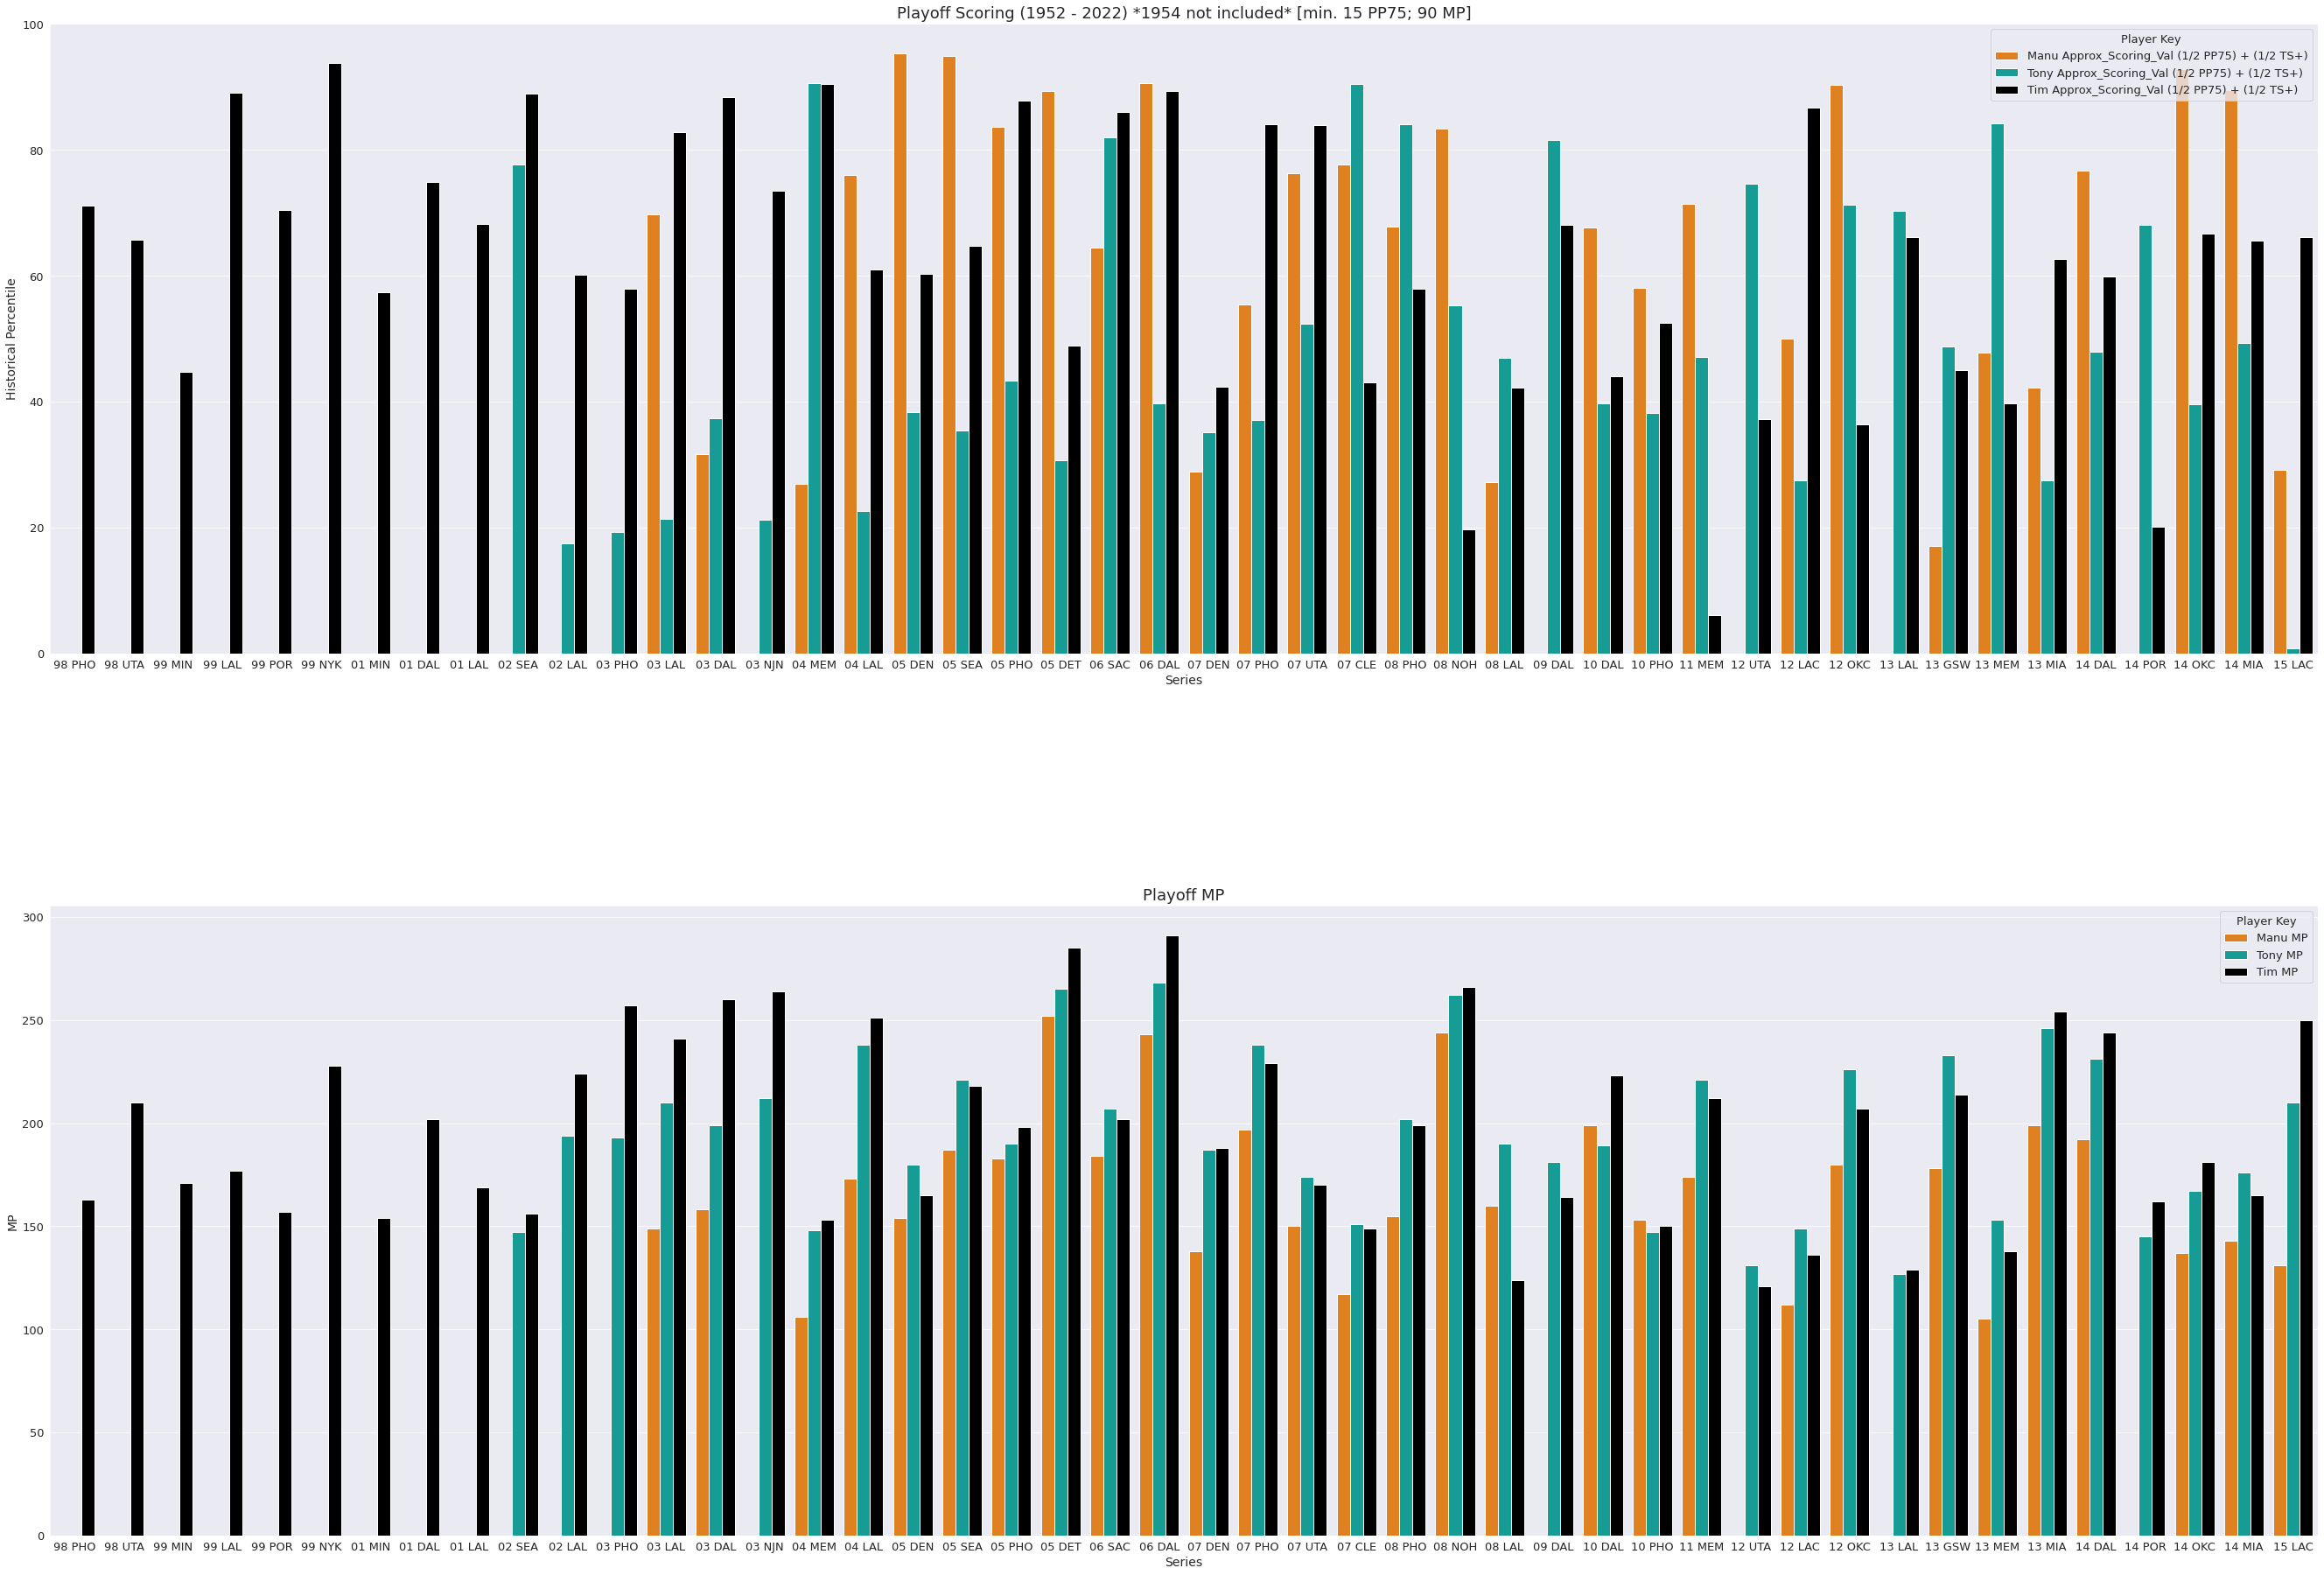

In [ ]:
#Spurs_Playoff_4_Plus_Percentile()
#Spurs_Playoff_Series_Percentile()
#Spurs_Playoff_Series_Percentile_Approx()
#Spurs_Playoff_Series_Percentile_No_First()
Big_3_Playoff_Series_Percentile_Approx()

**PLOT SHOOTING DISTRIBUTION DATA/PRINT MANUAL DATA**

In [ ]:
#@title Print Medians
def printmedians(pts_floor):
  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 300)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("2 Year Median PTS per 75 decline")
  print(med_pts)
  print("2 Year Median TS+ decline")
  print(med_ts)
  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 500)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("3 Year Median PTS per 75 decline")
  print(med_pts)
  print("3 Year Median TS+ decline")
  print(med_ts)
  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 800)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("4 Year Median PTS per 75 decline")
  print(med_pts)
  print("4 Year Median TS+ decline")
  print(med_ts)
  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1000)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("5 Year Median PTS per 75 decline")
  print(med_pts)
  print("5 Year Median TS+ decline")
  print(med_ts)
  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1200)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("6 Year Median PTS per 75 decline")
  print(med_pts)
  print("6 Year Median TS+ decline")
  print(med_ts)
  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1400)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("7 Year Median PTS per 75 decline")
  print(med_pts)
  print("7 Year Median TS+ decline")
  print(med_ts)
  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 1500)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("8 Year Median PTS per 75 decline")
  print(med_pts)
  print("8 Year Median TS+ decline")
  print(med_ts)
  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post'] >= pts_floor)]
  graph_data = graph_data[(graph_data['MP_post'] >= 2000)]
  med_pts = graph_data['PTS_change'].median()
  med_ts = graph_data['TS+_change'].median()
  print("10 Year Median PTS per 75 decline")
  print(med_pts)
  print("10 Year Median TS+ decline")
  print(med_ts)

In [ ]:
#@title Print Distribution of Scoring Changes
def printTSdistribution(all_some, pts_floor):
  if all_some == 0:
    # 2 year
    graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')

    # 3 year
    tmp_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 4 year
    tmp_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 5 year
    tmp_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 6 year
    tmp_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 7 year
    tmp_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 8 year
    tmp_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 10 year
    tmp_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()
  else:
    graph_data =  pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()

  graph_data['PTS_change'] = graph_data['PTS_change'].round(1)
  graph_data['TS+_change'] = graph_data['TS+_change'].round(1)

  plt.figure(figsize=(20,12), tight_layout=True)

  pd.cut(graph_data['TS+_change'], 
       bins=[-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], 
       labels = ['-17% or worse', '-16%', '-15%', '-14%', '-13%', '-12%', '-11%', '-10%', '-9%', '-8%', '-7%', '-6%', '-5%', '-4%',
                 '-3%', '-2%', '-1%', '0%', '+1%', '+2%', '+3%', '+4%', '+5%', '+6%',
                 '+7% or better'])\
  .value_counts(sort=False).plot.bar()
  title_string = f"Reg->Post Scoring Change; Multi Year Playoff Stretches; >= {pts_floor} PP75 Post (1974-2022)"
  plt.title(title_string)
  plt.xlabel('Change in TS+')
  plt.ylabel('Count')
  plt.show()
  print(graph_data['TS+_change'].quantile(0.98))

def printPTSdistribution(all_some, pts_floor):
  if all_some == 0:
    # 2 year
    graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')

    # 3 year
    tmp_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 4 year
    tmp_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 5 year
    tmp_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 6 year
    tmp_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 7 year
    tmp_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 8 year
    tmp_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)

    # 10 year
    tmp_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
    graph_data = graph_data.append(tmp_data)
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()
  else:
    graph_data =  pd.read_csv('/content/All_Scoring_Changes_300min.csv', encoding='utf8')
    graph_data = graph_data[(graph_data['MP_post'] >= 500)]
    graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
    graph_data = graph_data.dropna()

  graph_data['PTS_change'] = graph_data['PTS_change'].round(1)
  graph_data['TS+_change'] = graph_data['TS+_change'].round(1)

  plt.figure(figsize=(20,12), tight_layout=True)

  pd.cut(graph_data['PTS_change'], 
       bins=[-6, -5.5, -5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], 
       labels = ['-6 PTS or worse', '-5.5', '-5', '-4.5', '-4', '-3.5', '-3', '-2.5', '-2', '-1.5', '-1', '-0.5', '0', '+0.5', '+1', '+1.5', '+2', '+2.5', '+3', '+3.5', '+4', '+4.5% or better'])\
  .value_counts(sort=False).plot.bar()
  title_string = f"Reg->Post Scoring Change; Multi Year Playoff Stretches; >= {pts_floor} PP75 Post (1974-2022)"
  plt.title(title_string)
  plt.xlabel('Change in PTS per 75')
  plt.ylabel('Count')
  plt.show()
  print(graph_data['PTS_change'].quantile(0.8))

In [ ]:
#@title Round Format
player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

In [ ]:
#@title Manual comparisons function
sorted_playoffs_pts = era_opponent_adj_playoff_per_75_df.copy()
sorted_reg_pts = import_player_since74_per75_df.copy()

player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kawhi Leonard") & ((sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2019)  | (sorted_playoffs_pts.Year == 2021))]
player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kevin Durant") & ((sorted_playoffs_pts.Year == 2012) | (sorted_playoffs_pts.Year == 2017)  | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019) | (sorted_playoffs_pts.Year == 2021))]

#player_b = sorted_reg_pts[(sorted_reg_pts.Player == "Damian Lillard") & ((sorted_reg_pts.Year == 2014) | (sorted_reg_pts.Year == 2015)  | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2017) | (sorted_reg_pts.Year == 2019) | (sorted_reg_pts.Year == 2020) | (sorted_reg_pts.Year == 2021))]

#player_a = sorted_pts[(sorted_pts.Player == "Kawhi Leonard") & ((sorted_pts.Year == 2012) | (sorted_pts.Year == 2014)  | (sorted_pts.Year == 2019) | (sorted_pts.Year == 2016) | (sorted_pts.Year == 2015) | (sorted_pts.Year == 2017) | (sorted_pts.Year == 2020) | (sorted_pts.Year == 2021))]

#player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Klay Thompson") & ((sorted_playoffs_pts.Year == 2013) | (sorted_playoffs_pts.Year == 2014)  | (sorted_playoffs_pts.Year == 2015) | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant")]
#player_a = df[(df.Player == a)]
#player_b = df[(df.Player == b)]
total_mp_a = 0
total_pts_a = 0
total_ts_a = 0

total_mp_b = 0
total_pts_b = 0
total_ts_b = 0
mp_list_a = []
mp_list_b = []

# find total minutes a
for row in player_a['MP']:
  mp_list_a.append(row)
  total_mp_a += row
print(player_a.iat[0, 3], "\nminutes: ", total_mp_a)

# find total PTS a
i = 0
for row in player_a['PTS']:
  total_pts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

# find total TS+ a
i = 0
for row in player_a['TS%+']:
  total_ts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

print("PTS per 75: ", total_pts_a)
print("TS+: ",total_ts_a)

# find total minutes
for row in player_b['MP']:
  mp_list_b.append(row)
  total_mp_b += row
print("\n")
print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

# find total PTS
i = 0
for row in player_b['PTS']:
  total_pts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

# find total TS+
i = 0
for row in player_b['TS%+']:
  total_ts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

print("PTS per 75: ", total_pts_b)
print("TS+: ",total_ts_b)




In [ ]:
#@title def reg_playoff_comp(a, dfa, dfb) 
# def reg_playoff_comp(a, dfa, dfb) 
# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoff_comp(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  pts_list_a = []
  ts_list_a = []

  total_mp_b = 0
  pts_list_b = []
  ts_list_b = []

  mp_list_a = []
  mp_list_b = []


  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    pts_list_a.append(row)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    ts_list_a.append(row)
    i = i + 1

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nPlayoffs\n\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    pts_list_b.append(row)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    ts_list_b.append(row)
    i = i + 1
    j = i

  i = 0

  total_pts = 0
  total_ts = 0
  while i <= j-1:
    total_pts += ((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    print(pts_list_b[i] - pts_list_a[i])
    print(((pts_list_b[i] - pts_list_a[i]) * (mp_list_b[i] / total_mp_b)))
    total_ts += ((ts_list_b[i] - ts_list_a[i]) * (mp_list_b[i] / total_mp_b))
    i = i + 1

  print("\n\nRegular Season to Playoffs Change\n")
  if total_pts > 0:
    form_string = "PTS per 75: +{}".format(total_pts)
    print(form_string)
  else: 
    print("PTS per 75: ", total_pts)
  if total_ts > 0:
    form_string = "TS+ {}".format(total_ts)
    print(form_string)
  else:
    print("TS+: ",total_ts)

**SCORING PEAK FUNCTIONS**

In [ ]:
#@title Run Scoring Peaks

# 2
twoyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

twoyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 3 
threeyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 4 
fouryearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

fouryearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('four_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 5 
fiveyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 6 
sixyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

sixyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('six_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 7 
sevenyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

sevenyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('seven_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 8 
eightyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

eightyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 9 
nineyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('nine_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

nineyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('nine_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)


# 10 
tenyearpeak(era_opponent_adj_playoff_per_75_df, 'PTS')
import_player_PTS_peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_PTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_PTS_data.csv"
import_player_PTS_peaks_df.to_csv(outfile, index=False)

tenyearpeak(era_opponent_adj_playoff_per_75_df, 'TS%+')
import_player_TS_peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_player_TS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_TS%+_data.csv"
import_player_TS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import Scoring Peaks

# 2
import_adjpts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_twopeaks_df = import_adjpts_twopeaks_df.assign(TeamColor=0)

import_adjts_twopeaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_twopeaks_df = import_adjts_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_twopeaks_df['TeamColor'] = import_adjpts_twopeaks_df['Team'].map(team_colors)
import_adjts_twopeaks_df['TeamColor'] = import_adjts_twopeaks_df['Team'].map(team_colors)

import_adjpts_threepeaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_threepeaks_df = import_adjpts_threepeaks_df.assign(TeamColor=0)

import_adjts_threepeaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_threepeaks_df = import_adjts_threepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_threepeaks_df['TeamColor'] = import_adjpts_threepeaks_df['Team'].map(team_colors)
import_adjts_threepeaks_df['TeamColor'] = import_adjts_threepeaks_df['Team'].map(team_colors)

import_adjpts_4peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_4peaks_df = import_adjpts_4peaks_df.assign(TeamColor=0)

import_adjts_4peaks_df = pd.read_csv('four_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_4peaks_df = import_adjts_4peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_4peaks_df['TeamColor'] = import_adjpts_4peaks_df['Team'].map(team_colors)
import_adjts_4peaks_df['TeamColor'] = import_adjts_4peaks_df['Team'].map(team_colors)

import_adjpts_fivepeaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_fivepeaks_df = import_adjpts_fivepeaks_df.assign(TeamColor=0)

import_adjts_fivepeaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_fivepeaks_df = import_adjts_fivepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_fivepeaks_df['TeamColor'] = import_adjpts_fivepeaks_df['Team'].map(team_colors)
import_adjts_fivepeaks_df['TeamColor'] = import_adjts_fivepeaks_df['Team'].map(team_colors)

import_adjpts_6peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_6peaks_df = import_adjpts_6peaks_df.assign(TeamColor=0)

import_adjts_6peaks_df = pd.read_csv('six_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_6peaks_df = import_adjts_6peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_6peaks_df['TeamColor'] = import_adjts_6peaks_df['Team'].map(team_colors)
import_adjpts_6peaks_df['TeamColor'] = import_adjpts_6peaks_df['Team'].map(team_colors)

import_adjpts_7peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_7peaks_df = import_adjpts_7peaks_df.assign(TeamColor=0)

import_adjts_7peaks_df = pd.read_csv('seven_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_7peaks_df = import_adjts_7peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_7peaks_df['TeamColor'] = import_adjts_7peaks_df['Team'].map(team_colors)
import_adjpts_7peaks_df['TeamColor'] = import_adjpts_7peaks_df['Team'].map(team_colors)

import_adjpts_eightpeaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_eightpeaks_df = import_adjpts_eightpeaks_df.assign(TeamColor=0)

import_adjts_eightpeaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_eightpeaks_df = import_adjts_eightpeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_eightpeaks_df['TeamColor'] = import_adjpts_eightpeaks_df['Team'].map(team_colors)
import_adjts_eightpeaks_df['TeamColor'] = import_adjts_eightpeaks_df['Team'].map(team_colors)

import_adjpts_9peaks_df = pd.read_csv('nine_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_9peaks_df = import_adjpts_9peaks_df.assign(TeamColor=0)

import_adjts_9peaks_df = pd.read_csv('nine_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_9peaks_df = import_adjts_9peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_9peaks_df['TeamColor'] = import_adjpts_9peaks_df['Team'].map(team_colors)
import_adjts_9peaks_df['TeamColor'] = import_adjts_9peaks_df['Team'].map(team_colors)

import_adjpts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_10peaks_df = import_adjpts_10peaks_df.assign(TeamColor=0)

import_adjts_10peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_10peaks_df = import_adjts_10peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_10peaks_df['TeamColor'] = import_adjpts_10peaks_df['Team'].map(team_colors)
import_adjts_10peaks_df['TeamColor'] = import_adjts_10peaks_df['Team'].map(team_colors)

In [ ]:
#@title Output Scoring Peaks

# 2
at_least_400_min_2pts = import_adjpts_twopeaks_df[(import_adjpts_twopeaks_df['MP'] >= 300)]
at_least_400_min_2pts = at_least_400_min_2pts.reset_index(drop=True)

at_least_400_min_2ts = import_adjts_twopeaks_df[(import_adjts_twopeaks_df['MP'] >= 300)]
at_least_400_min_2ts = at_least_400_min_2ts.reset_index(drop=True)

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(6, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)
sorted_2pts = sorted_2pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

sorted_2pts['PTS'] = sorted_2pts['PTS'].round(2)
sorted_2pts['TS+'] = sorted_2pts['TS+'].round(2)

sorted_2pts = sorted_2pts.dropna()

print(sorted_2pts)

sorted_2pts.to_csv("Two_Year_scoring_Playoff_Peaks.csv", index=False)



# 3
at_least_400_min_pts = import_adjpts_threepeaks_df[(import_adjpts_threepeaks_df['MP'] >= 300)]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_adjts_threepeaks_df[(import_adjts_threepeaks_df['MP'] >= 300)]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)

sorted_3pts = at_least_400_min_pts.copy()
sorted_3pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_3pts = sorted_3pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_3pts = sorted_3pts.sort_values('PTS', ascending=False)
sorted_3pts = sorted_3pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_3pts = sorted_3pts.reindex(columns=columns_titles)

sorted_3pts['PTS'] = sorted_3pts['PTS'].round(2)
sorted_3pts['TS+'] = sorted_3pts['TS+'].round(2)

sorted_3pts = sorted_3pts.dropna()

print(sorted_3pts)

sorted_3pts.to_csv("Three_Year_scoring_Playoff_Peaks.csv", index=False)



# 4
at_least_400_min_pts = import_adjpts_4peaks_df[(import_adjpts_4peaks_df['MP'] >= 600)]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_adjts_4peaks_df[(import_adjts_4peaks_df['MP'] >= 600)]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)

sorted_3pts = at_least_400_min_pts.copy()
sorted_3pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_3pts = sorted_3pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_3pts = sorted_3pts.sort_values('PTS', ascending=False)
sorted_3pts = sorted_3pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_3pts = sorted_3pts.reindex(columns=columns_titles)

sorted_3pts['PTS'] = sorted_3pts['PTS'].round(2)
sorted_3pts['TS+'] = sorted_3pts['TS+'].round(2)

sorted_3pts = sorted_3pts.dropna()

print(sorted_3pts)

sorted_3pts.to_csv("Four_Year_scoring_Playoff_Peaks.csv", index=False)



# 5
at_least_800_min_pts = import_adjpts_fivepeaks_df[(import_adjpts_fivepeaks_df['MP'] >= 1000)]
at_least_800_min_ts = import_adjts_fivepeaks_df[(import_adjts_fivepeaks_df['MP'] >= 1000)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Five_Year_scoring_Playoff_Peaks.csv", index=False)



# 6
at_least_800_min_pts = import_adjpts_6peaks_df[(import_adjpts_6peaks_df['MP'] >= 1200)]
at_least_800_min_ts = import_adjts_6peaks_df[(import_adjts_6peaks_df['MP'] >= 1200)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Six_Year_scoring_Playoff_Peaks.csv", index=False)



# 7
at_least_800_min_pts = import_adjpts_7peaks_df[(import_adjpts_7peaks_df['MP'] >= 1400)]
at_least_800_min_ts = import_adjts_7peaks_df[(import_adjts_7peaks_df['MP'] >= 1400)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Seven_Year_scoring_Playoff_Peaks.csv", index=False)



# 8
at_least_1500_min_pts = import_adjpts_eightpeaks_df[(import_adjpts_eightpeaks_df['MP'] >= 1500)]
at_least_1500_min_ts = import_adjts_eightpeaks_df[(import_adjts_eightpeaks_df['MP'] >= 1500)]


sorted_8pts = at_least_1500_min_pts.copy()
sorted_8pts.insert(6, "TS+", at_least_1500_min_ts['PeakValue'])
sorted_8pts = sorted_8pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_8pts = sorted_8pts.sort_values('PTS', ascending=False)
sorted_8pts = sorted_8pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_8pts = sorted_8pts.reindex(columns=columns_titles)
sorted_8pts = sorted_8pts.reset_index(drop=True)

sorted_8pts['PTS'] = sorted_8pts['PTS'].round(2)
sorted_8pts['TS+'] = sorted_8pts['TS+'].round(2)

sorted_8pts = sorted_8pts.dropna()


print(sorted_8pts)

sorted_8pts.to_csv("Eight_Year_scoring_Playoff_Peaks_1500min.csv", index=False)



# 9
at_least_1500_min_pts = import_adjpts_9peaks_df[(import_adjpts_9peaks_df['MP'] >= 1700)]
at_least_1500_min_ts = import_adjts_9peaks_df[(import_adjts_9peaks_df['MP'] >= 1700)]


sorted_9pts = at_least_1500_min_pts.copy()
sorted_9pts.insert(6, "TS+", at_least_1500_min_ts['PeakValue'])
sorted_9pts = sorted_9pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_9pts = sorted_9pts.sort_values('PTS', ascending=False)
sorted_9pts = sorted_9pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_9pts = sorted_9pts.reindex(columns=columns_titles)
sorted_9pts = sorted_9pts.reset_index(drop=True)

sorted_9pts['PTS'] = sorted_9pts['PTS'].round(2)
sorted_9pts['TS+'] = sorted_9pts['TS+'].round(2)

sorted_9pts = sorted_9pts.dropna()


print(sorted_9pts)

sorted_9pts.to_csv("Nine_Year_scoring_Playoff_Peaks_1700min.csv", index=False)



# 10
at_least_2000_min_pts = import_adjpts_10peaks_df[(import_adjpts_10peaks_df['MP'] >= 2000)]
at_least_2000_min_ts = import_adjts_10peaks_df[(import_adjts_10peaks_df['MP'] >= 2000)]


sorted_10pts = at_least_2000_min_pts.copy()
sorted_10pts.insert(6, "TS+", at_least_2000_min_ts['PeakValue'])
sorted_10pts = sorted_10pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_10pts = sorted_10pts.sort_values('PTS', ascending=False)
sorted_10pts = sorted_10pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_10pts = sorted_10pts.reindex(columns=columns_titles)
sorted_10pts = sorted_10pts.reset_index(drop=True)
sorted_10pts['PTS'] = sorted_10pts['PTS'].round(2)
sorted_10pts['TS+'] = sorted_10pts['TS+'].round(2)

sorted_10pts = sorted_10pts.dropna()

print(sorted_10pts)

sorted_10pts.to_csv("Ten_Year_scoring_Playoff_Peaks_2000min.csv", index=False)

**BPM PEAK FILES**

In [ ]:
#@title Run BPM Peaks
twoyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

# 3
threeyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
threeyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#4
fouryearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('four_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
fouryearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('four_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#5
fiveyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
fiveyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('five_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#6
sixyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
sixyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('six_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#7
sevenyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('seven_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
sevenyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#
eightyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
eightyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#9
nineyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
nineyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

#10
tenyearpeak(new_df, 'BPM')
import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_BPM_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_BPM_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
tenyearpeak(new_df, 'OBPM')
import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_OBPM_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_OBPM_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import BPM Peaks
import_bpm_twopeaks_df = pd.read_csv('two_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_twopeaks_df = import_bpm_twopeaks_df.assign(TeamColor=0)

import_obpm_twopeaks_df = pd.read_csv('two_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_twopeaks_df = import_obpm_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_twopeaks_df['TeamColor'] = import_bpm_twopeaks_df['Team'].map(team_colors)
import_obpm_twopeaks_df['TeamColor'] = import_obpm_twopeaks_df['Team'].map(team_colors)

import_bpm_threepeaks_df = pd.read_csv('three_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_threepeaks_df = import_bpm_threepeaks_df.assign(TeamColor=0)

import_obpm_threepeaks_df = pd.read_csv('three_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_threepeaks_df = import_obpm_threepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_threepeaks_df['TeamColor'] = import_bpm_threepeaks_df['Team'].map(team_colors)
import_obpm_threepeaks_df['TeamColor'] = import_obpm_threepeaks_df['Team'].map(team_colors)

import_bpm_4peaks_df = pd.read_csv('four_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_4peaks_df = import_bpm_4peaks_df.assign(TeamColor=0)

import_obpm_4peaks_df = pd.read_csv('four_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_4peaks_df = import_obpm_4peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_4peaks_df['TeamColor'] = import_bpm_4peaks_df['Team'].map(team_colors)
import_obpm_4peaks_df['TeamColor'] = import_obpm_4peaks_df['Team'].map(team_colors)

import_bpm_fivepeaks_df = pd.read_csv('five_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_fivepeaks_df = import_bpm_fivepeaks_df.assign(TeamColor=0)

import_obpm_fivepeaks_df = pd.read_csv('five_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_fivepeaks_df = import_obpm_fivepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_fivepeaks_df['TeamColor'] = import_bpm_fivepeaks_df['Team'].map(team_colors)
import_obpm_fivepeaks_df['TeamColor'] = import_obpm_fivepeaks_df['Team'].map(team_colors)

import_bpm_6peaks_df = pd.read_csv('six_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_6peaks_df = import_bpm_6peaks_df.assign(TeamColor=0)

import_obpm_6peaks_df = pd.read_csv('six_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_6peaks_df = import_obpm_6peaks_df.assign(TeamColor=0)

# add team color for plotting
import_obpm_6peaks_df['TeamColor'] = import_obpm_6peaks_df['Team'].map(team_colors)
import_bpm_6peaks_df['TeamColor'] = import_bpm_6peaks_df['Team'].map(team_colors)

import_bpm_7peaks_df = pd.read_csv('seven_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_7peaks_df = import_bpm_7peaks_df.assign(TeamColor=0)

import_obpm_7peaks_df = pd.read_csv('seven_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_7peaks_df = import_obpm_7peaks_df.assign(TeamColor=0)

# add team color for plotting
import_obpm_7peaks_df['TeamColor'] = import_obpm_7peaks_df['Team'].map(team_colors)
import_bpm_7peaks_df['TeamColor'] = import_bpm_7peaks_df['Team'].map(team_colors)

import_bpm_eightpeaks_df = pd.read_csv('eight_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_eightpeaks_df = import_bpm_eightpeaks_df.assign(TeamColor=0)

import_obpm_eightpeaks_df = pd.read_csv('eight_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_eightpeaks_df = import_obpm_eightpeaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_eightpeaks_df['TeamColor'] = import_bpm_eightpeaks_df['Team'].map(team_colors)
import_obpm_eightpeaks_df['TeamColor'] = import_obpm_eightpeaks_df['Team'].map(team_colors)

import_bpm_9peaks_df = pd.read_csv('nine_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_9peaks_df = import_bpm_9peaks_df.assign(TeamColor=0)

import_obpm_9peaks_df = pd.read_csv('nine_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_9peaks_df = import_obpm_9peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_9peaks_df['TeamColor'] = import_bpm_9peaks_df['Team'].map(team_colors)
import_obpm_9peaks_df['TeamColor'] = import_obpm_9peaks_df['Team'].map(team_colors)

import_bpm_10peaks_df = pd.read_csv('ten_year_peak_BPM_data.csv', encoding='utf8')
import_bpm_10peaks_df = import_bpm_10peaks_df.assign(TeamColor=0)

import_obpm_10peaks_df = pd.read_csv('ten_year_peak_OBPM_data.csv', encoding='utf8')
import_obpm_10peaks_df = import_obpm_10peaks_df.assign(TeamColor=0)

# add team color for plotting
import_bpm_10peaks_df['TeamColor'] = import_bpm_10peaks_df['Team'].map(team_colors)
import_obpm_10peaks_df['TeamColor'] = import_obpm_10peaks_df['Team'].map(team_colors)

In [ ]:
#@title Output BPM Peaks

at_least_400_min_2bpm = import_bpm_twopeaks_df[(import_bpm_twopeaks_df['MP'] >= 300)]
at_least_400_min_2bpm = at_least_400_min_2bpm.reset_index(drop=True)

at_least_400_min_2obpm = import_obpm_twopeaks_df[(import_obpm_twopeaks_df['MP'] >= 300)]
at_least_400_min_2obpm = at_least_400_min_2obpm.reset_index(drop=True)

sorted_2bpm = at_least_400_min_2bpm.copy()
sorted_2bpm.insert(6, "OBPM", at_least_400_min_2obpm['PeakValue'])
sorted_2bpm = sorted_2bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_2bpm = sorted_2bpm.sort_values('BPM', ascending=False)
sorted_2bpm = sorted_2bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_2bpm = sorted_2bpm.reindex(columns=columns_titles)

sorted_2bpm['BPM'] = sorted_2bpm['BPM'].round(2)
sorted_2bpm['OBPM'] = sorted_2bpm['OBPM'].round(2)

sorted_2bpm = sorted_2bpm.dropna()

print(sorted_2bpm)

sorted_2bpm.to_csv("Two_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 3 year adjusted playoff scoring peaks (>= 400 min) Output File

# 400 minutes filter
at_least_400_min_bpm = import_bpm_threepeaks_df[(import_bpm_threepeaks_df['MP'] >= 300)]
at_least_400_min_bpm = at_least_400_min_bpm.reset_index(drop=True)

at_least_400_min_obpm = import_obpm_threepeaks_df[(import_obpm_threepeaks_df['MP'] >= 300)]
at_least_400_min_obpm = at_least_400_min_obpm.reset_index(drop=True)

sorted_3bpm = at_least_400_min_bpm.copy()
sorted_3bpm.insert(6, "OBPM", at_least_400_min_obpm['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('BPM', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['BPM'] = sorted_3bpm['BPM'].round(2)
sorted_3bpm['OBPM'] = sorted_3bpm['OBPM'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Three_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 4 year adjusted playoff scoring peaks (>= 600 min) Output File

# 400 minutes filter
at_least_400_min_bpm = import_bpm_4peaks_df[(import_bpm_4peaks_df['MP'] >= 300)]
at_least_400_min_bpm = at_least_400_min_bpm.reset_index(drop=True)

at_least_400_min_obpm = import_obpm_4peaks_df[(import_obpm_4peaks_df['MP'] >= 300)]
at_least_400_min_obpm = at_least_400_min_obpm.reset_index(drop=True)

sorted_3bpm = at_least_400_min_bpm.copy()
sorted_3bpm.insert(6, "OBPM", at_least_400_min_obpm['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('BPM', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['BPM'] = sorted_3bpm['BPM'].round(2)
sorted_3bpm['OBPM'] = sorted_3bpm['OBPM'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Four_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 5 year adjusted playoff scoring peaks (>=800 min) Output File

at_least_800_min_bpm = import_bpm_fivepeaks_df[(import_bpm_fivepeaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_fivepeaks_df[(import_obpm_fivepeaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Five_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 6 year adjusted playoff scoring peaks (>=1000 min) Output File

at_least_800_min_bpm = import_bpm_6peaks_df[(import_bpm_6peaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_6peaks_df[(import_obpm_6peaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Six_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 7 year adjusted playoff scoring peaks (>=1200 min) Output File

at_least_800_min_bpm = import_bpm_7peaks_df[(import_bpm_7peaks_df['MP'] >= 300)]
at_least_800_min_obpm = import_obpm_7peaks_df[(import_obpm_7peaks_df['MP'] >= 300)]


sorted_5bpm = at_least_800_min_bpm.copy()
sorted_5bpm.insert(6, "OBPM", at_least_800_min_obpm['PeakValue'])
sorted_5bpm = sorted_5bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_5bpm = sorted_5bpm.sort_values('BPM', ascending=False)
sorted_5bpm = sorted_5bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_5bpm = sorted_5bpm.reindex(columns=columns_titles)
sorted_5bpm = sorted_5bpm.reset_index(drop=True)

sorted_5bpm['BPM'] = sorted_5bpm['BPM'].round(2)
sorted_5bpm['OBPM'] = sorted_5bpm['OBPM'].round(2)

sorted_5bpm = sorted_5bpm.dropna()

print(sorted_5bpm)

sorted_5bpm.to_csv("Seven_Year_BPM_Playoff_Peaks.csv", index=False)

#@title 8 year adjusted playoff scoring peaks (>=1500 min) Output File

at_least_1500_min_bpm = import_bpm_eightpeaks_df[(import_bpm_eightpeaks_df['MP'] >= 300)]
at_least_1500_min_obpm = import_obpm_eightpeaks_df[(import_obpm_eightpeaks_df['MP'] >= 300)]


sorted_8bpm = at_least_1500_min_bpm.copy()
sorted_8bpm.insert(6, "OBPM", at_least_1500_min_obpm['PeakValue'])
sorted_8bpm = sorted_8bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_8bpm = sorted_8bpm.sort_values('BPM', ascending=False)
sorted_8bpm = sorted_8bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_8bpm = sorted_8bpm.reindex(columns=columns_titles)
sorted_8bpm = sorted_8bpm.reset_index(drop=True)

sorted_8bpm['BPM'] = sorted_8bpm['BPM'].round(2)
sorted_8bpm['OBPM'] = sorted_8bpm['OBPM'].round(2)

sorted_8bpm = sorted_8bpm.dropna()


print(sorted_8bpm)

sorted_8bpm.to_csv("Eight_Year_BPM_Playoff_Peaks_1500min.csv", index=False)

#@title 9 year adjusted playoff scoring peaks (>=1700 min) Output File

at_least_1500_min_bpm = import_bpm_9peaks_df[(import_bpm_9peaks_df['MP'] >= 300)]
at_least_1500_min_obpm = import_obpm_9peaks_df[(import_obpm_9peaks_df['MP'] >= 300)]


sorted_9bpm = at_least_1500_min_bpm.copy()
sorted_9bpm.insert(6, "OBPM", at_least_1500_min_obpm['PeakValue'])
sorted_9bpm = sorted_9bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_9bpm = sorted_9bpm.sort_values('BPM', ascending=False)
sorted_9bpm = sorted_9bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_9bpm = sorted_9bpm.reindex(columns=columns_titles)
sorted_9bpm = sorted_9bpm.reset_index(drop=True)

sorted_9bpm['BPM'] = sorted_9bpm['BPM'].round(2)
sorted_9bpm['OBPM'] = sorted_9bpm['OBPM'].round(2)

sorted_9bpm = sorted_9bpm.dropna()


print(sorted_9bpm)

sorted_9bpm.to_csv("Nine_Year_BPM_Playoff_Peaks_1700min.csv", index=False)

#@title 10 year adjusted playoff scoring peaks (>=2000 min) Output File

at_least_2000_min_bpm = import_bpm_10peaks_df[(import_bpm_10peaks_df['MP'] >= 300)]
at_least_2000_min_obpm = import_obpm_10peaks_df[(import_obpm_10peaks_df['MP'] >= 300)]


sorted_10bpm = at_least_2000_min_bpm.copy()
sorted_10bpm.insert(6, "OBPM", at_least_2000_min_obpm['PeakValue'])
sorted_10bpm = sorted_10bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "BPM", "MP": "MP", "TeamColor": "TeamColor", "OBPM": "OBPM", "G": "G"})

sorted_10bpm = sorted_10bpm.sort_values('BPM', ascending=False)
sorted_10bpm = sorted_10bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'BPM', 'OBPM', 'MP', 'G']
sorted_10bpm = sorted_10bpm.reindex(columns=columns_titles)
sorted_10bpm = sorted_10bpm.reset_index(drop=True)
sorted_10bpm['BPM'] = sorted_10bpm['BPM'].round(2)
sorted_10bpm['OBPM'] = sorted_10bpm['OBPM'].round(2)

sorted_10bpm = sorted_10bpm.dropna()

print(sorted_10bpm)

sorted_10bpm.to_csv("Ten_Year_BPM_Playoff_Peaks_2000min.csv", index=False)

**PBP PEAK FILES**

In [ ]:
#@title Run PBP Peaks
nineyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_OnCourt_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
nineyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_On-Off_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"nine_year_peak_On-Off_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import PBP Peaks
import_oncourt_9peaks_df = pd.read_csv('nine_year_peak_OnCourt_data.csv', encoding='utf8')
import_oncourt_9peaks_df = import_oncourt_9peaks_df.assign(TeamColor=0)

import_onoff_9peaks_df = pd.read_csv('nine_year_peak_On-Off_data.csv', encoding='utf8')
import_onoff_9peaks_df = import_onoff_9peaks_df.assign(TeamColor=0)

In [ ]:
#@title Output PBP Peaks

at_least_400_min_oncourt = import_oncourt_9peaks_df[(import_oncourt_9peaks_df['MP'] >= 3000)]
at_least_400_min_oncourt = at_least_400_min_oncourt.reset_index(drop=True)

at_least_400_min_onoff = import_onoff_9peaks_df[(import_onoff_9peaks_df['MP'] >= 3000)]
at_least_400_min_onoff = at_least_400_min_onoff.reset_index(drop=True)

sorted_3bpm = at_least_400_min_oncourt.copy()
sorted_3bpm.insert(6, "On-Off", at_least_400_min_onoff['PeakValue'])
sorted_3bpm = sorted_3bpm.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "On-Off": "On-Off", "G": "G"})

sorted_3bpm = sorted_3bpm.sort_values('On-Off', ascending=False)
sorted_3bpm = sorted_3bpm.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3bpm = sorted_3bpm.reindex(columns=columns_titles)

sorted_3bpm['On-Off'] = sorted_3bpm['On-Off'].round(2)
sorted_3bpm['OnCourt'] = sorted_3bpm['OnCourt'].round(2)

sorted_3bpm = sorted_3bpm.dropna()

print(sorted_3bpm)

sorted_3bpm.to_csv("Nine_Year_pbp_Playoff_Peaks_3000_min.csv", index=False)

In [ ]:
#@title Scrape NBA playoffs series possession data
def scrape_nba_player_series_data(url, player, player_ref):
                       
  wd.get(url)   
  html = wd.page_source
  soup = BeautifulSoup(html, features="lxml")
  time.sleep(10)

  for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'div_other_scores'})
          hrefs = second_div.findAll('td', attrs={'class': 'right gamelink'})
          hrefs = str(hrefs)
          ref_urls = re.findall(r'/\d+\w+\D\w+', hrefs)
          urls = []
          for ref_url in ref_urls:
            ref_url = "https://www.basketball-reference.com/boxscores/pbp" + ref_url
            urls.append(ref_url)
  def_possessions = 0
  missing_poss = 0
  for game_url in urls:

    wd.get(game_url)   
    html = wd.page_source
    soup = BeautifulSoup(html, features="lxml")

    for first_div in soup.find_all('div', attrs={'id': 'content'}):
            second_div = first_div.find('div', attrs={'id': 'all_pbp'})
            first_table = second_div.find('table', attrs={'id': 'pbp'})
            body = first_table.find('tbody')
    # grab rows
    rows = body.findAll('tr')[0:]

    

    total_poss = 0
    player_out_wait = 0
    beg_q = 0
    extra_poss = 0
    non_shooting = 0


    possession_enders = ['Defensive rebound', 'makes 2-pt', 'makes 3-pt', 'Turnover', 'Shooting foul']
    fts_no_shooting_foul = ['free throw 1 of 2']

    player_out = [f'enters the game for <a href="{player_ref}">{player}']
    player_in = [f'{player}']

    hes_back_but_subtly = [f'{player}</a> misses 2-pt']
    for row in rows:
      row = str(row)


      if player_out_wait == 1:
        if f'{player}</a> misses 2-pt' in row:
          total_poss = total_poss + extra_poss
          extra_poss = 0
          player_out_wait = 0
          beg_q = 0

      if 'Q' in row:
        beg_q = 1

      if any(iny in row for iny in player_in):
        player_out_wait = 0
      if any(outy in row for outy in player_out):
        player_out_wait = 1

      if (any(end_poss in row for end_poss in fts_no_shooting_foul) and player_out_wait == 0 and non_shooting == 1):
        total_poss = total_poss + 1

      if ('foul' in row and 'Shooting' not in row):
        non_shooting = 1

      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 0):
        total_poss = total_poss + 1
        non_shooting = 0
      
      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 1 and beg_q == 1):
        extra_poss = extra_poss + 1
        non_shooting = 0
      
    missing_poss = missing_poss + total_poss

    #@title Default possessions

    total_poss = 0
    player_out_wait = 0
    extra_poss = 0


    possession_enders = ['Defensive rebound', 'makes 2-pt', 'makes 3-pt', 'Turnover', 'Shooting foul']
    fts_no_shooting_foul = ['free throw 1 of 2']

    player_out = [f'enters the game for <a href="{player_ref}">{player}']
    player_in = [f'{player}']

    hes_back_but_subtly = [f'{player}</a> misses 2-pt']

    for row in rows:
      row = str(row)

      if any(iny in row for iny in player_in):
        player_out_wait = 0
      if any(outy in row for outy in player_out):
        player_out_wait = 1

      if (any(end_poss in row for end_poss in possession_enders) and player_out_wait == 0):
        total_poss = total_poss + 1
    def_possessions = def_possessions + total_poss
  print("Total Default:")
  print(def_possessions/2)
  print("\nTotal Missing:")
  print(missing_poss/2)

In [ ]:
scrape_nba_player_series_data("https://www.basketball-reference.com/playoffs/1998-nba-western-conference-semifinals-spurs-vs-jazz.html", 'T. Duncan', '/players/d/duncati01.html')

Total Default:
354.5

Total Missing:
371.5


In [ ]:
five = pd.read_csv('/content/Single_Playoffs_Adjusted_Scoring.csv')
five['MP'] = five['MP'].astype(int)
five['PTS per 75'] = five['PTS per 75'].round(2)
five = five.sort_values('Year', ascending=True)

five = five[(five['Player'] == 'Lou Williams')]
print(five)

outfile = f"top_scorers.csv"
five.to_csv(outfile, index=False)

**PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title 2 year peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '777' '15'
def twoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = 0
    prev_min = 0
    prev_g = 0
    prevYearTeam = 0
    prevyear = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_g
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back * (prev_min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prev_back = 0
            prev_min = 0
            prev_g = 0
            prevYearTeam = 0
            indexlist = []

          # can finally store years as this player has had 2 consecutive seasons
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear , present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear , present_year)

          if two_seasons_count == original_year+2 and len(indexlist) >=2:
            two_seasons_count = player['Year']

          if present_year == original_year:
            prev_back = inner_row[valuestring]
            prevYearTeam = inner_row['Tm']
            prev_min = inner_row['MP']
            prevyear = inner_row['Year']
            prev_g = inner_row['G']
          if present_year > original_year:
            prev_back = inner_row[valuestring]
            prevYearTeam = inner_row['Tm']
            prev_min = inner_row['MP']
            prevyear = inner_row['Year']
            prev_g = inner_row['G']


          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >= 2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min, games]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 3 year peaks function

# def threeyearpeak(df, valuestring):
# returns a dataframe containing 3 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 3 year stretches of 'valuestring' AND the listed years from each 3 year stretch + minutes played across the 3 seasons.
# EX: threeyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '712' '22'
def threeyearpeak(df, valuestring):
  three_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 3 year peaks); begin as 0's
    for i in range(0, 2):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    three_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_three_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_three_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[1]

          if inner_row['Year'] != present_year:
            for i in range(0, 2):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 3 consecutive seasons
          if present_year >= original_year+2 and len(indexlist) >=3:
            if (prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[1] , present_year)
            else:
              present_peak_years = '{}, {}, {}'.format(prevyear[1] , prevyear[0] , present_year)

          if three_seasons_count == original_year+3 and len(indexlist) >=3:
            three_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 1
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 1
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          three_seasons_count = three_seasons_count + 1

          if len(indexlist) >= 3:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_three_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_three_year_peak_val, running_min, games]], columns=cols)
            three_year_peak = three_year_peak.append(df_temp)
            outfile = f"three_year_peak_{valuestring}_data.csv"
            three_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 4 year peaks function

# def fouryearpeak(df, valuestring):
# returns a dataframe containing 4 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 4 year stretches of 'valuestring' AND the listed years from each 4 year stretch + minutes played across the 5 seasons.
# EX: fouryearpeak(import_player_since74_per100_df, 'PTS') returns 4 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-19', 'Kris Middleton', 'MIL' '22.11', '1213' '28'
def fouryearpeak(df, valuestring):
  four_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 4 year peaks); begin as 0's
    for i in range(0, 3):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    four_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_four_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_four_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[2]

          if inner_row['Year'] != present_year:
            for i in range(0, 3):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 4 consecutive seasons
          if present_year >= original_year+3 and len(indexlist) >=4:
            if (prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[2] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}'.format(prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if four_seasons_count == original_year+4 and len(indexlist) >=4:
            four_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 2
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 2
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          four_seasons_count = four_seasons_count + 1

          if len(indexlist) >= 4:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_four_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_four_year_peak_val, running_min, games]], columns=cols)
            four_year_peak = four_year_peak.append(df_temp)
            outfile = f"four_year_peak_{valuestring}_data.csv"
            four_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 5 year peaks function

# def fiveyearpeak(df, valuestring):
# returns a dataframe containing 5 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 5 year stretches of 'valuestring' AND the listed years from each 5 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 5 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-20', 'Kris Middleton', 'MIL' '22.11', '1639 '34'
def fiveyearpeak(df, valuestring):
  five_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 5 year peaks); begin as 0's
    for i in range(0, 4):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    five_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_five_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_five_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[3]

          if inner_row['Year'] != present_year:
            for i in range(0, 4):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 5 consecutive seasons
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[3] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}'.format(prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if five_seasons_count == original_year+5 and len(indexlist) >=5:
            five_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 3
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 3
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          five_seasons_count = five_seasons_count + 1

          if len(indexlist) >= 5:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_five_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_five_year_peak_val, running_min, games]], columns=cols)
            five_year_peak = five_year_peak.append(df_temp)
            outfile = f"five_year_peak_{valuestring}_data.csv"
            five_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 6 year peaks function

# def sixyearpeak(df, valuestring):
# returns a dataframe containing 6 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 6 year stretches of 'valuestring' AND the listed years from each 6 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 6 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-21', 'Kris Middleton', 'MIL' '22.11', '1119' '46'
def sixyearpeak(df, valuestring):
  six_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 6 year peaks); begin as 0's
    for i in range(0, 5):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    six_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_six_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_six_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)) + (prev_back[4] * (prev_min[4] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[4]

          if inner_row['Year'] != present_year:
            for i in range(0, 5):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 6 consecutive seasons
          if present_year >= original_year+5 and len(indexlist) >=6:
            if (prevyear[4]  == (prevyear[3] - 1) and prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[4] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}'.format(prevyear[4] , prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if six_seasons_count == original_year+6 and len(indexlist) >=6:
            six_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 4
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 4
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          six_seasons_count = six_seasons_count + 1

          if len(indexlist) >= 6:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[4] and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_six_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_six_year_peak_val, running_min, games]], columns=cols)
            six_year_peak = six_year_peak.append(df_temp)
            outfile = f"six_year_peak_{valuestring}_data.csv"
            six_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 7 year peaks function

# def sevenyearpeak(df, valuestring):
# returns a dataframe containing 7 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 7 year stretches of 'valuestring' AND the listed years from each 7 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 7 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-22', 'Kris Middleton', 'MIL' '22.11', '1467' '66'
def sevenyearpeak(df, valuestring):
  seven_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 7 year peaks); begin as 0's
    for i in range(0, 6):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    seven_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_seven_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_seven_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)) + (prev_back[4] * (prev_min[4] / running_min)) + (prev_back[5] * (prev_min[5] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[5]

          if inner_row['Year'] != present_year:
            for i in range(0, 6):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 7 consecutive seasons
          if present_year >= original_year+6 and len(indexlist) >=7:
            if (prevyear[5]  == (prevyear[4] - 1) and prevyear[4]  == (prevyear[3] - 1) and prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[5] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}'.format(prevyear[5] , prevyear[4] , prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if seven_seasons_count == original_year+7 and len(indexlist) >=7:
            seven_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 5
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 5
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          seven_seasons_count = seven_seasons_count + 1

          if len(indexlist) >= 7:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[5] and inner_row['Tm'] == prevYearTeam[4] and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_seven_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_seven_year_peak_val, running_min, games]], columns=cols)
            seven_year_peak = seven_year_peak.append(df_temp)
            outfile = f"seven_year_peak_{valuestring}_data.csv"
            seven_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 8 year peaks function

# def eightyearpeak(df, valuestring):
# returns a dataframe containing 8 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 8 year stretches of 'valuestring' AND the listed years from each 8 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 8 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2013-20', 'Kris Middleton', 'MIL' '22.11', '2139' '66'
def eightyearpeak(df, valuestring):
  eight_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 8 year peaks); begin as 0's
    for i in range(0, 7):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eight_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_eight_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_eight_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)) + (prev_back[4] * (prev_min[4] / running_min)) + (prev_back[5] * (prev_min[5] / running_min)) + (prev_back[6] * (prev_min[6] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[6]

          if inner_row['Year'] != present_year:
            for i in range(0, 7):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 8 consecutive seasons
          if present_year >= original_year+7 and len(indexlist) >=8:
            if (prevyear[6]  == (prevyear[5] - 1) and prevyear[5]  == (prevyear[4] - 1) and prevyear[4]  == (prevyear[3] - 1) and prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[6] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}'.format(prevyear[6] , prevyear[5] , prevyear[4] , prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if eight_seasons_count == original_year+8 and len(indexlist) >=8:
            eight_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 6
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 6
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          eight_seasons_count = eight_seasons_count + 1

          if len(indexlist) >= 8:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[6] and inner_row['Tm'] == prevYearTeam[5] and inner_row['Tm'] == prevYearTeam[4] and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_eight_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_eight_year_peak_val, running_min, games]], columns=cols)
            eight_year_peak = eight_year_peak.append(df_temp)
            outfile = f"eight_year_peak_{valuestring}_data.csv"
            eight_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 9 year peaks function

# def nineyearpeak(df, valuestring):
# returns a dataframe containing 9 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 9 year stretches of 'valuestring' AND the listed years from each 9 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 9 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2012-20', 'Kris Middleton', 'MIL' '22.11', '2585' '66'
def nineyearpeak(df, valuestring):
  nine_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 9 year peaks); begin as 0's
    for i in range(0, 8):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    nine_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_nine_year_peak_val = 0
    running_min = 0
    games = 0

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_nine_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)) + (prev_back[4] * (prev_min[4] / running_min)) + (prev_back[5] * (prev_min[5] / running_min)) + (prev_back[6] * (prev_min[6] / running_min)) + (prev_back[7] * (prev_min[7] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[7]

          if inner_row['Year'] != present_year:
            for i in range(0, 8):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 9 consecutive seasons
          if present_year >= original_year+8 and len(indexlist) >=9:
            if (prevyear[7]  == (prevyear[6] - 1) and prevyear[6]  == (prevyear[5] - 1) and prevyear[5]  == (prevyear[4] - 1) and prevyear[4]  == (prevyear[3] - 1) and prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[7] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prevyear[7] , prevyear[6] , prevyear[5] , prevyear[4] , prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if nine_seasons_count == original_year+9 and len(indexlist) >=9:
            nine_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 7
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 7
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          nine_seasons_count = nine_seasons_count + 1

          if len(indexlist) >= 9:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[7] and inner_row['Tm'] == prevYearTeam[6] and inner_row['Tm'] == prevYearTeam[5] and inner_row['Tm'] == prevYearTeam[4] and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_nine_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_nine_year_peak_val, running_min, games]], columns=cols)
            nine_year_peak = nine_year_peak.append(df_temp)
            outfile = f"nine_year_peak_{valuestring}_data.csv"
            nine_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 10 year peaks function

# def tenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '2976', '76'
def tenyearpeak(df, valuestring):
  ten_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous seasons' values
    prev_back = []
    prev_min = []
    prev_g = []
    prevYearTeam = []
    prevyear = []

    # store values from previous seasons (relevant in formulating 10 year peaks); begin as 0's
    for i in range(0, 9):
      prev_back.append(0)
      prev_min.append(0)
      prev_g.append(0)
      prevYearTeam.append(0)
      prevyear.append(0)

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    ten_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    indexlist = []
    running_ten_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []

    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + sum(prev_min))
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + sum(prev_g)
          running_ten_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_back[0] * (prev_min[0] / running_min)) + (prev_back[1] * (prev_min[1] / running_min)) + (prev_back[2] * (prev_min[2] / running_min)) + (prev_back[3] * (prev_min[3] / running_min)) + (prev_back[4] * (prev_min[4] / running_min)) + (prev_back[5] * (prev_min[5] / running_min)) + (prev_back[6] * (prev_min[6] / running_min)) + (prev_back[7] * (prev_min[7] / running_min)) + (prev_back[8] * (prev_min[8] / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam[8]

          if inner_row['Year'] != present_year:
            for i in range(0, 9):
              prev_back.append(0)
              prev_min.append(0)
              prev_g.append(0)
              prevYearTeam.append(0)
            indexlist = []

          # can finally store years as this player has had 10 consecutive seasons
          if present_year >= original_year+9 and len(indexlist) >=10:
            if (prevyear[8] == (prevyear[7] - 1) and prevyear[7]  == (prevyear[6] - 1) and prevyear[6]  == (prevyear[5] - 1) and prevyear[5]  == (prevyear[4] - 1) and prevyear[4]  == (prevyear[3] - 1) and prevyear[3]  == (prevyear[2] - 1) and prevyear[2]  == (prevyear[1] - 1) and prevyear[1]  == (prevyear[0] - 1) and prevyear[0]  == (present_year - 1)):
              present_peak_years = '{} - {}'.format(prevyear[8] , present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prevyear[8] , prevyear[7] , prevyear[6] , prevyear[5] , prevyear[4] , prevyear[3] , prevyear[2] , prevyear[1] , prevyear[0] , present_year)

          if ten_seasons_count == original_year+10 and len(indexlist) >=10:
            ten_seasons_count = player['Year']
          if present_year == original_year+1:
            i = 8
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1

          if present_year == original_year:
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']
          if present_year > original_year:
            i = 8
            while i >= 1:
              prev_back[i] = prev_back[i-1]
              prevYearTeam[i] = prevYearTeam[i-1]
              prev_min[i] = prev_min[i-1]
              prevyear[i] = prevyear[i-1]
              prev_g[i] = prev_g[i-1]
              i = i - 1
            prev_back[0] = inner_row[valuestring]
            prevYearTeam[0] = inner_row['Tm']
            prev_min[0] = inner_row['MP']
            prevyear[0] = inner_row['Year']
            prev_g[0] = inner_row['G']

          ten_seasons_count = ten_seasons_count + 1

          if len(indexlist) >= 10:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            running_min = int(running_min)
            games = int(games)
            if (inner_row['Tm'] == old_team and inner_row['Tm'] == prevYearTeam[7] and inner_row['Tm'] == prevYearTeam[6] and inner_row['Tm'] == prevYearTeam[5] and inner_row['Tm'] == prevYearTeam[4] and inner_row['Tm'] == prevYearTeam[3] and inner_row['Tm'] == prevYearTeam[2] and inner_row['Tm'] == prevYearTeam[1] and prevYearTeam[0] == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_ten_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_ten_year_peak_val, running_min, games]], columns=cols)
            ten_year_peak = ten_year_peak.append(df_temp)
            outfile = f"ten_year_peak_{valuestring}_data.csv"
            ten_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

**SMALL USE CASE PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title 2 year fragmented peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def fragtwoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes played
    prev_1back = 0
    prev_1min = 0

    # peak start and end season
    present_peak_years = [0, 0]

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevyear = 0
    prevYearTeam = 0

    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev_1back = 0
            prev_1min = 0
            prevyear = 0
            indexlist = []


          # can finally store years as this player has had 2 consecutive seasons (not reached after 2 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+2 and len(indexlist) >=2:
            two_seasons_count = player['Year']

          # move present value to previous year's value
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP']
            if (old_team == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title Manual Data Peak Functions

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def twoyearpeak_manual_data(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0



    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.

    prevyear = 0


    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev_1back = 0
            prev_1min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+3 and len(indexlist) >=3:
            two_seasons_count = player['Year']
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 3 year peaks (manual data) function

# def threeyearpeak(df, valuestring):
# returns a dataframe containing 3 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 3 year stretches of 'valuestring' AND the listed years from each 3 year stretch + minutes played across the 3 seasons.
# EX: threeyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '7120'
def threeyearpeak_manual_data(df, valuestring):
  three_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue and minutes
    prev_2back = 0
    prev_2min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    three_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # previous two years; e.g. 2014, 2015 before 2016. 2016, 2019 if these were the two most recent seasons for a player before 2020.
    prevyear = 0
    prev2year = 0

    indexlist = []
    running_three_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min)
          if running_min == 0:
            running_min = 1
          running_three_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+2 and len(indexlist) >=3:
            if (prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev2year, present_year)
            else:
              present_peak_years = '{}, {}, {}'.format(prev2year, prevyear, present_year)

          if three_seasons_count == original_year+3 and len(indexlist) >=3:
            three_seasons_count = player['Year']
          if present_year == original_year+1:
            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          three_seasons_count = three_seasons_count + 1

          if len(indexlist) >=3:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_three_year_peak_val, running_min]], columns=cols)
            three_year_peak = three_year_peak.append(df_temp)
            outfile = f"three_year_peak_{valuestring}_data.csv"
            three_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 4 year peaks (manual data) function

# returns a dataframe containing 4 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 4 year stretches of 'valuestring' AND the listed years from each 4 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 4 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-19', 'Kris Middleton', 'MIL' '22.11', '12139'
def fouryearpeak_manual_data(df, valuestring):
  four_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0


    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    four_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0


    indexlist = []
    running_four_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min)
          if running_min == 0:
            running_min = 1
          running_four_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+3 and len(indexlist) >=4:
            if (prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev3year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}'.format(prev3year, prev2year, prevyear, present_year)

          if four_seasons_count == original_year+4 and len(indexlist) >=4:
            four_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          four_seasons_count = four_seasons_count + 1

          if len(indexlist) >=4:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_four_year_peak_val, running_min]], columns=cols)
            four_year_peak = four_year_peak.append(df_temp)
            outfile = f"four_year_peak_{valuestring}_data.csv"
            four_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 5 year peaks (manual data) function

# def fiveyearpeak(df, valuestring):
# returns a dataframe containing 5 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 5 year stretches of 'valuestring' AND the listed years from each 5 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 5 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def fiveyearpeak_manual_data(df, valuestring):
  five_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    five_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0


    indexlist = []
    running_five_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min)
          if running_min == 0:
            running_min = 1
          running_five_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev4year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}'.format(prev4year, prev3year, prev2year, prevyear, present_year)

          if five_seasons_count == original_year+5 and len(indexlist) >=5:
            five_seasons_count = player['Year']
          if present_year == original_year+1:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          five_seasons_count = five_seasons_count + 1

          if len(indexlist) >=5:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_five_year_peak_val, running_min]], columns=cols)
            five_year_peak = five_year_peak.append(df_temp)
            outfile = f"five_year_peak_{valuestring}_data.csv"
            five_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 6 year peaks (manual data) function

# def sixyearpeak(df, valuestring):
# returns a dataframe containing 6 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 6 year stretches of 'valuestring' AND the listed years from each 6 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 6 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-21', 'Kris Middleton', 'MIL' '22.11', '12139'
def sixyearpeak_manual_data(df, valuestring):
  six_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    six_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0


    indexlist = []
    running_six_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min)
          if running_min == 0:
            running_min = 1
          running_six_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+5 and len(indexlist) >=6:
            if (prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev5year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}'.format(prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if six_seasons_count == original_year+6 and len(indexlist) >=6:
            six_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          six_seasons_count = six_seasons_count + 1

          if len(indexlist) >=6:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_six_year_peak_val, running_min]], columns=cols)
            six_year_peak = six_year_peak.append(df_temp)
            outfile = f"six_year_peak_{valuestring}_data.csv"
            six_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 7 year peaks (manual data) function

# def sevenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def sevenyearpeak_manual_data(df, valuestring):
  seven_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0


    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    seven_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0


    indexlist = []
    running_seven_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min)
          if running_min == 0:
            running_min = 1
          running_seven_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+6 and len(indexlist) >=7:
            if (prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev6year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}'.format(prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if seven_seasons_count == original_year+7 and len(indexlist) >=7:
            seven_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          seven_seasons_count = seven_seasons_count + 1

          if len(indexlist) >=7:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_seven_year_peak_val, running_min]], columns=cols)
            seven_year_peak = seven_year_peak.append(df_temp)
            outfile = f"seven_year_peak_{valuestring}_data.csv"
            seven_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 8 year peaks (manual data) function

# def eightyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def eightyearpeak_manual_data(df, valuestring):
  eight_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eight_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0


    indexlist = []
    running_eight_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min)
          if running_min == 0:
            running_min = 1
          running_eight_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+7 and len(indexlist) >=8:
            if (prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev7year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}'.format(prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if eight_seasons_count == original_year+8 and len(indexlist) >=8:
            eight_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          eight_seasons_count = eight_seasons_count + 1

          if len(indexlist) >=8:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_eight_year_peak_val, running_min]], columns=cols)
            eight_year_peak = eight_year_peak.append(df_temp)
            outfile = f"eight_year_peak_{valuestring}_data.csv"
            eight_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 9 year peaks (manual data) function

# def nineyearpeak(df, valuestring):
# returns a dataframe containing 9 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 9 year stretches of 'valuestring' AND the listed years from each 9 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 9 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def nineyearpeak_manual_data(df, valuestring):
  nine_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    nine_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0


    indexlist = []
    running_nine_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min)
          if running_min == 0:
            running_min = 1
          running_nine_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+8 and len(indexlist) >=9:
            if (prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev8year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if nine_seasons_count == original_year+9 and len(indexlist) >=9:
            nine_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back

            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          nine_seasons_count = nine_seasons_count + 1

          if len(indexlist) >=9:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_nine_year_peak_val, running_min]], columns=cols)
            nine_year_peak = nine_year_peak.append(df_temp)
            outfile = f"nine_year_peak_{valuestring}_data.csv"
            nine_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 10 year peaks (manual data) function

# def tenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def tenyearpeak_manual_data(df, valuestring):
  ten_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0

    # 9 seasons ago's peakvalue
    prev_9back = 0
    prev_9min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    ten_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0
    prev9year = 0


    indexlist = []
    running_ten_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min + prev_9min)
          if running_min == 0:
            running_min = 1
          running_ten_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)) + (prev_9back * (prev_9min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev9year = 0
            prev_9back = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            prev_9min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+9 and len(indexlist) >=10:
            if (prev9year == (prev8year-1) and prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev9year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev9year, prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if ten_seasons_count == original_year+10 and len(indexlist) >=10:
            ten_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back

            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          ten_seasons_count = ten_seasons_count + 1

          if len(indexlist) >=10:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_ten_year_peak_val, running_min]], columns=cols)
            ten_year_peak = ten_year_peak.append(df_temp)
            outfile = f"ten_year_peak_{valuestring}_data.csv"
            ten_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])
#@title 11 year peaks (manual data) function

# def elevenyearpeak(df, valuestring):
# returns a dataframe containing 11 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 11 year stretches of 'valuestring' AND the listed years from each 11 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 11 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-21', 'Kris Middleton', 'MIL' '22.11', '12139'
def elevenyearpeak_manual_data(df, valuestring):
  eleven_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0

    # 9 seasons ago's peakvalue
    prev_9back = 0
    prev_9min = 0

    prev_10back = 0
    prev_10min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eleven_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0
    prev9year = 0
    prev10year = 0


    indexlist = []
    running_eleven_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min + prev_9min + prev_10min)
          if running_min == 0:
            running_min = 1
          running_eleven_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)) + (prev_9back * (prev_9min / running_min))+ (prev_10back * (prev_10min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev9year = 0
            prev10year = 0
            prev_10back = 0
            prev_9back = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            prev_9min = 0
            prev_10min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+10 and len(indexlist) >=11:
            if (prev10year == (prev9year-1) and prev9year == (prev8year-1) and prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev10year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev10year, prev9year, prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if eleven_seasons_count == original_year+11 and len(indexlist) >=11:
            eleven_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_10back = prev_9back
            prev_10min = prev_9min
            prev10year = prev9year

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back

            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_10back = prev_9back
            prev_10min = prev_9min
            prev10year = prev9year

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          eleven_seasons_count = eleven_seasons_count + 1

          if len(indexlist) >=11:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_eleven_year_peak_val, running_min]], columns=cols)
            eleven_year_peak = eleven_year_peak.append(df_temp)
            outfile = f"eleven_year_peak_{valuestring}_data.csv"
            eleven_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

**RUN YEAR MANUAL SUBSETS**

In [ ]:
#@title Adjusted Playoff TS+ of Manual Subset
def manual_adjust_scoring_efficiency(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP'])

      years_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg']) - opp_def_rtg

        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'rOffRtg'] = relOffRtg


        if player_df.loc[i, 'Year'] not in years_list:
          years_list.append(player_df.loc[i, 'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'TS%', 'PTS', 'PTS_coeff'])
      for year in years_list:
        tmp_sub_df = player_df[(player_df['Year'] == year)]

        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
         #PTS
        iter = 0
        for ind_pts in tmp_sub_df['PP75']:
          ind_pts = float(ind_pts)
          total_pts += float(ind_pts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        iter = 0
        #coeff
        for ind_coeff in tmp_sub_df['PTS_coeff']:
          ind_coeff = float(ind_coeff)
          total_coeff += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
        total_pts = total_pts * total_coeff


        # NetRtg
        iter = 0
        for ind_coeff in tmp_sub_df['NetRtg']:
          ind_net = float(ind_coeff)
          total_net += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        # OffRtg
        iter = 0
        for ind_coeff in tmp_sub_df['rOffRtg']:
          ind_off = float(ind_coeff)
          total_off += float(ind_coeff) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        new_row = {'Player':player, 'Year':year,  'PP75':total_pts, 'TS+':total_ts, 'NetRtg':total_net, 'rOffRtg': total_off, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Print Manual Peaks
def manu_tony_compare(player, sit):

  manu_only_one_adjusted = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

  twoyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('two_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  twoyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  threeyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_NetRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  fouryearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('four_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('four_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  fouryearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('four_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"four_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  fiveyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('five_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  fiveyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  sixyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('six_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  sixyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('six_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"six_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)


  sevenyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('seven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  sevenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"seven_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  eightyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('eight_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  eightyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eight_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  nineyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('nine_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('nine_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  nineyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('nine_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"nine_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  tenyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('ten_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  tenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"ten_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)



  elevenyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('eleven_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
  import_player_longTS_peaks_df = pd.read_csv('eleven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_TS+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'NetRtg')
  import_player_longNetRtg_peaks_df = pd.read_csv('eleven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_longNetRtg_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_NetRtg_data.csv"
  import_player_longNetRtg_peaks_df.to_csv(outfile, index=False)
  elevenyearpeak_manual_data(manu_only_one_adjusted, 'rOffRtg')
  import_player_longTS_peaks_df = pd.read_csv('eleven_year_peak_rOffRtg_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"eleven_year_peak_rOffRtg_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)


  import_pts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_ts_twopeaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_peaks_df = pd.read_csv('two_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_peaks_df = pd.read_csv('two_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg3_peaks_df = pd.read_csv('three_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg3_peaks_df = pd.read_csv('three_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_4peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_4peaks_df = pd.read_csv('four_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_4peaks_df = pd.read_csv('four_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_4peaks_df = pd.read_csv('four_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_5peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_5peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_5peaks_df = pd.read_csv('five_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_5peaks_df = pd.read_csv('five_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_6peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_6peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_6peaks_df = pd.read_csv('six_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_6peaks_df = pd.read_csv('six_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_7peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_7peaks_df = pd.read_csv('seven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_7peaks_df = pd.read_csv('seven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_7peaks_df = pd.read_csv('seven_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_8peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_8peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_8peaks_df = pd.read_csv('eight_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_8peaks_df = pd.read_csv('eight_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_9peaks_df = pd.read_csv('nine_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_9peaks_df = pd.read_csv('nine_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_9peaks_df = pd.read_csv('nine_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_9peaks_df = pd.read_csv('nine_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_10peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_10peaks_df = pd.read_csv('ten_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_10peaks_df = pd.read_csv('ten_year_peak_rOffRtg_data.csv', encoding='utf8')

  import_player_pts_11peaks_df = pd.read_csv('eleven_year_peak_PTS_data.csv', encoding='utf8')
  import_player_ts_11peaks_df = pd.read_csv('eleven_year_peak_TS+_data.csv', encoding='utf8')
  import_player_NetRtg_11peaks_df = pd.read_csv('eleven_year_peak_NetRtg_data.csv', encoding='utf8')
  import_player_rOffRtg_11peaks_df = pd.read_csv('eleven_year_peak_rOffRtg_data.csv', encoding='utf8')














  #2 year playoff scoring peaks Output File
  peaks_df = import_pts_twopeaks_df.copy()
  peaks_df.insert(4, "TS+", import_ts_twopeaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Two")
  print(peaks_df)

  outfile = f"{player}_2_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #3 year playoff scoring peaks Output File
  peaks_df = import_player_pts_peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg3_peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg3_peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Three")
  print(peaks_df)

  outfile = f"{player}_3_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #4 year playoff scoring peaks Output File
  peaks_df = import_player_pts_4peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_4peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_4peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_4peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Four")
  print(peaks_df)

  outfile = f"{player}_4_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #5 year playoff scoring peaks Output File
  peaks_df = import_player_pts_5peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_5peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_5peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_5peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Five")
  print(peaks_df)

  outfile = f"{player}_5_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #6 year playoff scoring peaks Output File
  peaks_df = import_player_pts_6peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_6peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_6peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_6peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Six")
  print(peaks_df)

  outfile = f"{player}_6_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #7 year playoff scoring peaks Output File
  peaks_df = import_player_pts_7peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_7peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_7peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_7peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Seven")
  print(peaks_df)

  outfile = f"{player}_7_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

  #8 year playoff scoring peaks Output File
  peaks_df = import_player_pts_8peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_8peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_8peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_8peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Eight")
  print(peaks_df)

  outfile = f"{player}_8_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #9 year playoff scoring peaks Output File
  peaks_df = import_player_pts_9peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_9peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_9peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_9peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Nine")
  print(peaks_df)

  outfile = f"{player}_9_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)


  #10 year playoff scoring peaks Output File
  peaks_df = import_player_pts_10peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_10peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_10peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_10peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Ten")
  print(peaks_df)

  outfile = f"{player}_10_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)



  #11 year playoff scoring peaks Output File
  peaks_df = import_player_pts_11peaks_df.copy()
  peaks_df.insert(4, "TS+", import_player_ts_11peaks_df['PeakValue'])
  peaks_df.insert(5, "NetRtg", import_player_NetRtg_11peaks_df['PeakValue'])
  peaks_df.insert(6, "rOffRtg", import_player_rOffRtg_11peaks_df['PeakValue'])

  peaks_df = peaks_df.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+", "NetRtg": "NetRtg", "rOffRtg": "rOffRtg"})

  peaks_df = peaks_df.sort_values('PTS', ascending=False)
  columns_titles = ['Player', 'Years', 'PTS', 'TS+', "NetRtg", "rOffRtg", 'MP']
  peaks_df = peaks_df.reindex(columns=columns_titles)

  print("Eleven")
  print(peaks_df)

  outfile = f"{player}_11_{sit}_scoring_Playoff_Peaks.csv"
  peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Inflate Scoring for Manual Subset
new_df = pd.DataFrame()
per_75_coeff['Year'] = per_75_coeff['Year'].astype(int)
manu_one_on['Year'] = manu_one_on['Year'].astype(float)
manu_one_on['PP75'] = manu_one_on['PP75'].astype(float)
for i, row in manu_one_on.iterrows():
  sub_coeff = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))
  new_df = new_df.append(row)
new_df['Year'] = new_df['Year'].astype(int)
new_df['PP75'] = new_df['PP75'].astype(float)
new_df['TS%'] = new_df['TS%'].astype(float)
new_df['MP'] = new_df['MP'].astype(int)
new_df['Opp'] = new_df['Opp'].astype(str)

pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

manual_adjust_scoring_efficiency(new_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Tim Duncan')

#Manu Ginóbili

In [ ]:
#@title Output Year Percentiles
from scipy import stats
graph_data =  era_opponent_adj_playoff_per_75_df.copy()
graph_data = graph_data[(graph_data['PTS'] >= 15)]
graph_data = graph_data[(graph_data['MP'] >= 90)]

final_season_df = pd.DataFrame(columns = ['Year', 'PP75', 'TS+', 'MP'])

this_df = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
for idx, row in this_df.iterrows():
  year = int(row['Year'])
  pts = row['PP75']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS%+'], ts)

  
  new_row = {'Year':year,  'PP75':pts_percentile, 'TS+':ts_percentile,'MP':int(mp)}
  final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

In [ ]:
manu_tony_compare("Tony", "Only_One")
# Manu Ginóbili

**RUN SERIES MANUAL SUBSETS**

In [ ]:
#@title Adjusted Playoff TS+ of Manual Subset (Series)
def manual_adjust_scoring_efficiency_series(player_df, opp_ts_df, opp_defrtg_df, opp_literal_defrtg, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Series', 'PP75', 'TS+', 'NetRtg', 'rOffRtg', 'MP'])

      series_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75


      player_df['TS%'] = player_df['TS%'].astype(float)

      opp_ts_df['Team'] = opp_ts_df['Team'].astype(str)
      opp_ts_df['Year'] = opp_ts_df['Year'].astype(int)
      opp_defrtg_df['Team'] = opp_defrtg_df['Team'].astype(str)
      opp_defrtg_df['Year'] = opp_defrtg_df['Year'].astype(int)
      opp_literal_defrtg['Team'] = opp_literal_defrtg['Team'].astype(str)
      opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(int)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']

        opponent_ts = opp_ts_df[(opp_ts_df['Team'] == current_opp) & (opp_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)

        opponent_def = opp_defrtg_df[(opp_defrtg_df['Team'] == current_opp) & ((opp_defrtg_df['Year'] == current_year))]
        pts_coeff = float(opponent_def['PTS_coeff'])

        opponent_literal_def = opp_literal_defrtg[(opp_literal_defrtg['Team'] == current_opp) & ((opp_literal_defrtg['Year'] == current_year))]
        opp_def_rtg = float(opponent_literal_def['DefRtg'])

        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        relOffRtg = float(row['OffRtg']) - opp_def_rtg

        player_df.loc[i,'TS+'] = tsplus
        player_df.loc[i,'PTS_coeff'] = pts_coeff
        player_df.loc[i,'rOffRtg'] = relOffRtg


      for idx, row in player_df.iterrows():
        total_pts = 0
        total_ts = 0
        total_mp = 0
        total_coeff = 0
        total_net = 0
        total_off = 0

        total_mp = int(row['MP'])
        total_ts = float(row['TS+'])
        total_pts = float(row['PP75'])
        total_coeff = float(row['PTS_coeff'])
        total_pts = total_pts * total_coeff


        total_net = float(row['NetRtg'])
        total_off = float(row['rOffRtg'])

        total_pts = '%.2f' % round(total_pts, 2)
        total_ts = '%.2f' % round(total_ts, 2)
        total_off = '%.2f' % round(total_off, 2)
        total_net = '%.2f' % round(total_net, 2)

        series = str(row['Year'])
        series = series + " "
        series = series + str(row['Opp'])

        new_row = {'Player':player, 'Series':series,  'PP75':total_pts, 'TS+':total_ts, 'NetRtg':total_net, 'rOffRtg': total_off, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Series_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Inflate Scoring for Manual Subset (Series)
new_df = pd.DataFrame()
per_75_coeff['Year'] = per_75_coeff['Year'].astype(int)
manu_one_on['Year'] = manu_one_on['Year'].astype(float)
manu_one_on['PP75'] = manu_one_on['PP75'].astype(float)
for i, row in manu_one_on.iterrows():
  sub_coeff = per_75_coeff[(per_75_coeff['Year'] == row['Year'])]
  row['PP75'] = float((row['PP75'] * sub_coeff['Coefficient']))
  new_df = new_df.append(row)
new_df['Year'] = new_df['Year'].astype(int)
new_df['PP75'] = new_df['PP75'].astype(float)
new_df['TS%'] = new_df['TS%'].astype(float)
new_df['MP'] = new_df['MP'].astype(int)
new_df['Opp'] = new_df['Opp'].astype(str)

pd.options.mode.chained_assignment = None
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
team_ts_allowed_df['TS% Allowed'] = team_ts_allowed_df['TS% Allowed'].astype(float)
team_ts_allowed_df['Year'] = team_ts_allowed_df['Year'].astype(int)

opp_literal_defrtg = pd.read_csv('/content/NBA_Team_defrtg_Allowed_df.csv', index_col=False, encoding='utf8')
opp_literal_defrtg['Year'] = opp_literal_defrtg['Year'].astype(int)


opponent_adj_pts_coeff = pd.read_csv('/content/opponent_adj_pts_coeff.csv', index_col=False, encoding='utf8')
opponent_adj_pts_coeff['Year'] = opponent_adj_pts_coeff['Year'].astype(int)

manual_adjust_scoring_efficiency_series(new_df, team_ts_allowed_df, opponent_adj_pts_coeff, opp_literal_defrtg, 'Tim Duncan')

#Manu Ginóbili

In [ ]:
#@title Output Series Percentiles
from scipy import stats
graph_data =  era_opponent_adj_playoff_per_75_df.copy()
graph_data = graph_data[(graph_data['PTS'] >= 15)]
graph_data = graph_data[(graph_data['MP'] >= 90)]

final_season_df = pd.DataFrame(columns = ['Series', 'PP75', 'TS+', 'MP'])

this_df = pd.read_csv('/content/NBA_Playoff_Series_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')
for idx, row in this_df.iterrows():
  series = row['Series']
  pts = row['PP75']
  ts = row['TS+']
  mp = row['MP']
  pts_percentile = stats.percentileofscore(graph_data['PTS'], pts)
  ts_percentile = stats.percentileofscore(graph_data['TS%+'], ts)

  
  new_row = {'Series':series,  'PP75':pts_percentile, 'TS+':ts_percentile,'MP':int(mp)}
  final_season_df = final_season_df.append(new_row, ignore_index=True)
  outfile = f"Percentiles.csv"
  final_season_df.to_csv(outfile, index=False)

**MANUAL SUBSETS**

MANU

In [ ]:
#@title Manu Scoring numbers with both of Tim and Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

manu_one_on = tmp_df.copy()

# 2004
tmp_df.loc[len(tmp_df)] = ['23.08', '.5938', '50', 'MEM', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['23.38', '.6081', '106', 'LAL', '2004', '6.16', '96.52']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2005
tmp_df.loc[len(tmp_df)] = ['33.08', '.6719', '66', 'DEN', '2005', '13.0', '121.8']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.29', '.6705', '106', 'SEA', '2005', '21.34', '122.92']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.43', '.6327', '112', 'PHO', '2005', '2.40', '121.68']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['24.82', '.5593', '161', 'DET', '2005', '-0.93', '103.60']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2006
tmp_df.loc[len(tmp_df)] = ['30.66', '.6154', '112', 'SAC', '2006', '20.24', '125.00']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['26.95', '.5859', '154', 'DAL', '2006', '7.45', '115.96']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2007
tmp_df.loc[len(tmp_df)] = ['17.65', '.4194', '78', 'DEN', '2007', '-3.83', '108.50']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.76', '.5784', '114', 'PHO', '2007', '1.48', '108.30']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['26.58', '.6667', '79', 'UTA', '2007', '7.58', '122.15']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.61', '.6613', '65', 'CLE', '2007', '14.18', '108.20']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2008
tmp_df.loc[len(tmp_df)] = ['19.51', '.5128', '105', 'PHO', '2008', '3.80', '109.27']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['30.31', '.5655', '169', 'NOH', '2008', '-10.07', '100.94']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['17.59', '.5484', '102', 'LAL', '2008', '-3.62', '98.99']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2010
tmp_df.loc[len(tmp_df)] = ['43.83', '.6481', '91', 'DAL', '2010', '11.94', '123.46']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.02', '.7368', '89', 'PHO', '2010', '5.88', '119.10']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2011
tmp_df.loc[len(tmp_df)] = ['26.70', '.5795', '102', 'MEM', '2011', '-1.04', '97.91']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2012
tmp_df.loc[len(tmp_df)] = ['14.29', '.4375', '50', 'UTA', '2012', '-0.19', '109.18']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.20', '.7083', '67', 'LAC', '2012', '30.88', '116.0']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['24.79', '.6591', '117', 'OKC', '2012', '8.79', '110.08']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2013
tmp_df.loc[len(tmp_df)] = ['14.47', '.6111', '41', 'LAL', '2013', '19.74', '119.74']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['12.95', '.3103', '73', 'GSW', '2013', '-13.80', '90.65']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['14.47', '.5500', '41', 'MEM', '2013', '-17.26', '101.32']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.93', '.6622', '98', 'MIA', '2013', '-1.84', '111.64']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2014
tmp_df.loc[len(tmp_df)] = ['24.19', '.5375', '97', 'DAL', '2014', '12.92', '116.67']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['22.81', '.4483', '57', 'POR', '2014', '-2.40', '110.53']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.06', '.7321', '66', 'OKC', '2014', '6.0', '120.61']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['22.78', '.5469', '87', 'MIA', '2014', '27.22', '128.48']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

manu_one_on = manu_one_on.reset_index(drop=True)

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with both of Tim/Tony on (5+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['5.26', '.5000', '9', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['25.86', '.6667', '64', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['39.73', '.7250', '38', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['56.45', '1.1000', '38', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['31.68', '.6892', '79', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['28.14', '.6023', '116', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['27.73', '.5333', '67', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['13.51', '.3462', '42', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['19.44', '.4762', '56', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['16.92', '.5500', '35', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['30.65', '.7083', '31', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['39.53', '.7727', '22', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['14.71', '.5000', '34', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['32.35', '.6048', '131', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['15.31', '.3889', '51', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['21.90', '.4792', '58', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['21.67', '.6500', '31', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['22.52', '.5435', '60', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['28.21', '.5500', '19', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['25.81', '.5000', '16', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['8.62', '.5000', '32', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['0', '.0000', '3', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['13.61', '.5000', '18', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '5', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['27.85', '.7333', '41', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['40.63', '1.0833', '16', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['30.00', '.5192', '46', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['30.00', '.7500', '20', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['46.15', '.7500', '14', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['18.27', '.4048', '56', 'MEM', '2004', '15.14', '106.73']

tmp_df.loc[len(tmp_df)] = ['34.17', '.7000', '66', 'LAL', '2004', '0.0', '107.50']

# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '76', 'DEN', '2005', '18.88', '109.22']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '79', 'SEA', '2005', '7.79', '119.59']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '67', 'PHO', '2005', '12.23', '110.69']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '86', 'DET', '2005', '11.78', '108.97']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '46', 'SAC', '2006', '1.14', '110.23']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '81', 'DAL', '2006', '2.70', '110.81']


# 2007
tmp_df.loc[len(tmp_df)] = ['32.31', '.5263', '35', 'DEN', '2007', '7.74', '110.77']

tmp_df.loc[len(tmp_df)] = ['23.19', '.5167', '71', 'PHO', '2007', '-7.50', '108.70']

tmp_df.loc[len(tmp_df)] = ['30.21', '.5370', '54', 'UTA', '2007', '9.22', '104.17']

tmp_df.loc[len(tmp_df)] = ['36.51', '.5750', '36', 'CLE', '2007', '50.79', '123.81']

# 2008
tmp_df.loc[len(tmp_df)] = ['42.05', '.5606', '42', 'PHO', '2008', '-0.21', '109.09']

tmp_df.loc[len(tmp_df)] = ['42.72', '.7333', '60', 'NOH', '2008', '28.35', '120.39']

tmp_df.loc[len(tmp_df)] = ['27.72', '.5192', '55', 'LAL', '2008', '-7.09', '100.99']

# 2010
tmp_df.loc[len(tmp_df)] = ['22.99', '.4457', '102', 'DAL', '2010', '-5.21', '98.93']

tmp_df.loc[len(tmp_df)] = ['16.49', '.4444', '49', 'PHO', '2010', '-19.89', '94.85']

# 2011
tmp_df.loc[len(tmp_df)] = ['51.95', '.7800', '38', 'MEM', '2011', '31.20', '128.57']

# 2012
tmp_df.loc[len(tmp_df)] = ['16.67', '.4000', '13', 'UTA', '2012', '-43.30', '95.83']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '10', 'LAC', '2012', '-17.73', '55.50']

tmp_df.loc[len(tmp_df)] = ['45.95', '.6071', '18', 'OKC', '2012', '-49.03', '108.11']

# 2013
tmp_df.loc[len(tmp_df)] = ['45.83', '.9167', '12', 'LAL', '2013', '29.17', '137.50']

tmp_df.loc[len(tmp_df)] = ['25.79', '.5256', '83', 'GSW', '2013', '46.44', '130.82']

tmp_df.loc[len(tmp_df)] = ['21.62', '.8889', '41', 'MEM', '2013', '35.38', '117.57']

tmp_df.loc[len(tmp_df)] = ['17.91', '.4444', '75', 'MIA', '2013', '-11.91', '102.99']

# 2014
tmp_df.loc[len(tmp_df)] = ['48.39', '.6471', '44', 'DAL', '2014', '26.18', '120.43']

tmp_df.loc[len(tmp_df)] = ['20.97', '.4333', '29', 'POR', '2014', '30.05', '98.39']

tmp_df.loc[len(tmp_df)] = ['31.71', '.6842', '39', 'OKC', '2014', '24.56', '110.98']

tmp_df.loc[len(tmp_df)] = ['15.38', '.5000', '20', 'MIA', '2014', '14.76', '102.56']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on (3+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['17.65', '.4000', '29', 'MEM', '2004', '0.0', '90.20']

tmp_df.loc[len(tmp_df)] = ['28.00', '.4750', '42', 'LAL', '2004', '-2.26', '105.33']

# 2005
tmp_df.loc[len(tmp_df)] = ['47.19', '.7000', '47', 'DEN', '2005', '26.97', '112.36']

tmp_df.loc[len(tmp_df)] = ['55.56', '.8125', '40', 'SEA', '2005', '14.38', '131.94']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '67', 'PHO', '2005', '12.23', '110.69']

tmp_df.loc[len(tmp_df)] = ['43.97', '.7250', '84', 'DET', '2005', '11.39', '109.22']

# 2006
tmp_df.loc[len(tmp_df)] = ['8.70', '.3000', '36', 'SAC', '2006', '-21.74', '102.90']

tmp_df.loc[len(tmp_df)] = ['40.17', '.6528', '63', 'DAL', '2006', '3.42', '108.55']

# 2007
tmp_df.loc[len(tmp_df)] = ['30.36', '.5333', '30', 'DEN', '2007', '-1.60', '108.93']

tmp_df.loc[len(tmp_df)] = ['16', '.4167', '52', 'PHO', '2007', '-9.67', '107.0']

tmp_df.loc[len(tmp_df)] = ['37.21', '.6667', '24', 'UTA', '2007', '16.59', '123.26']

tmp_df.loc[len(tmp_df)] = ['34.48', '.5000', '17', 'CLE', '2007', '72.41', '124.14']

# 2008
tmp_df.loc[len(tmp_df)] = ['28.07', '.5000', '26', 'PHO', '2008', '-16.43', '101.75']

tmp_df.loc[len(tmp_df)] = ['44.00', '.7500', '42', 'NOH', '2008', '18.33', '113.33']

tmp_df.loc[len(tmp_df)] = ['29.55', '.5000', '25', 'LAL', '2008', '-21.28', '100.00']

# 2010
tmp_df.loc[len(tmp_df)] = ['23.53', '.4872', '93', 'DAL', '2010', '-6.47', '98.82']

tmp_df.loc[len(tmp_df)] = ['10.53', '.3333', '28', 'PHO', '2010', '-34.31', '87.72']

# 2011
tmp_df.loc[len(tmp_df)] = ['55.77', '.7250', '26', 'MEM', '2011', '17.31', '117.31']

# 2012
tmp_df.loc[len(tmp_df)] = ['26.67', '.5000', '9', 'UTA', '2012', '-46.27', '106.67']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '6', 'LAC', '2012', '-24.18', '61.54']

tmp_df.loc[len(tmp_df)] = ['55.56', '.4545', '8', 'OKC', '2012', '-30.72', '122.22']

# 2013
tmp_df.loc[len(tmp_df)] = ['60.00', '1.1250', '7', 'LAL', '2013', '40.00', '133.33']

tmp_df.loc[len(tmp_df)] = ['23.76', '.4444', '54', 'GSW', '2013', '44.55', '124.75']

tmp_df.loc[len(tmp_df)] = ['11.63', '.8333', '23', 'MEM', '2013', '61.60', '137.21']

tmp_df.loc[len(tmp_df)] = ['7.46', '.2083', '39', 'MIA', '2013', '-24.64', '94.03']

# 2014
tmp_df.loc[len(tmp_df)] = ['62.22', '.6750', '21', 'DAL', '2014', '28.89', '120.00']

tmp_df.loc[len(tmp_df)] = ['15.91', '.3889', '22', 'POR', '2014', '20.98', '97.73']

tmp_df.loc[len(tmp_df)] = ['38.89', '.7000', '26', 'OKC', '2014', '30.34', '111.11']

tmp_df.loc[len(tmp_df)] = ['19.05', '.6667', '12', 'MIA', '2014', '41.67', '100.00']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['0', '.000', '4', 'MEM', '2004', '6.94', '44.44']

tmp_df.loc[len(tmp_df)] = ['39.58', '.5667', '25', 'LAL', '2004', '8.67', '116.67']

# 2005
tmp_df.loc[len(tmp_df)] = ['55.81', '.7059', '26', 'DEN', '2005', '16.90', '104.65']

tmp_df.loc[len(tmp_df)] = ['73.33', '1.2222', '16', 'SEA', '2005', '66.25', '160.00']

tmp_df.loc[len(tmp_df)] = ['36.47', '.5000', '44', 'PHO', '2005', '11.87', '114.12']

tmp_df.loc[len(tmp_df)] = ['49.25', '.8056', '42', 'DET', '2005', '28.14', '120.90']

# 2006
tmp_df.loc[len(tmp_df)] = ['16.67', '.3333', '13', 'SAC', '2006', '-52.88', '62.50']

tmp_df.loc[len(tmp_df)] = ['50.00', '.7857', '11', 'DAL', '2006', '-9.09', '90.91']

# 2007
tmp_df.loc[len(tmp_df)] = ['28.00', '.3889', '13', 'DEN', '2007', '-41.50', '96.00']

tmp_df.loc[len(tmp_df)] = ['21.25', '.5000', '27', 'PHO', '2007', '-30.22', '101.92']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '7', 'UTA', '2007', '33.33', '120.00']

tmp_df.loc[len(tmp_df)] = ['18.18', '.2500', '6', 'CLE', '2007', '92.42', '109.09']

# 2008
tmp_df.loc[len(tmp_df)] = ['22.71', '.5000', '10', 'PHO', '2008', '-19.26', '104.55']

tmp_df.loc[len(tmp_df)] = ['38.46', '.7143', '29', 'NOH', '2008', '20.94', '117.31']

tmp_df.loc[len(tmp_df)] = ['13.33', '.2500', '8', 'LAL', '2008', '-37.92', '93.33']

# 2010
tmp_df.loc[len(tmp_df)] = ['17.27', '.3800', '61', 'DAL', '2010', '-41.56', '85.71']

tmp_df.loc[len(tmp_df)] = ['4.76', '.2500', '20', 'PHO', '2010', '-6.40', '91.82']

# 2011
tmp_df.loc[len(tmp_df)] = ['56.25', '.7500', '14', 'MEM', '2011', '20.00', '100.00']

# 2012
tmp_df.loc[len(tmp_df)] = ['33.33', '.5000', '6', 'UTA', '2012', '-97.73', '75.00']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '3', 'LAC', '2012', '-66.67', '66.67']

tmp_df.loc[len(tmp_df)] = ['37.50', '.3750', '4', 'OKC', '2012', '-100.00', '100.00']

# 2013
tmp_df.loc[len(tmp_df)] = ['75.00', '1.500', '4', 'LAL', '2013', '62.50', '162.50']

tmp_df.loc[len(tmp_df)] = ['19.35', '.4286', '16', 'GSW', '2013', '41.94', '106.45']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '14', 'MEM', '2013', '42.63', '138.46']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '19', 'MIA', '2013', '-49.88', '75.76']

# 2014
tmp_df.loc[len(tmp_df)] = ['68.42', '.8571', '8', 'DAL', '2014', '2.79', '126.32']

tmp_df.loc[len(tmp_df)] = ['22.58', '.5000', '16', 'POR', '2014', '9.68', '90.32']

tmp_df.loc[len(tmp_df)] = ['32.43', '.6000', '18', 'OKC', '2014', '11.58', '97.30']

tmp_df.loc[len(tmp_df)] = ['28.57', '.6667', '8', 'MIA', '2014', '50.89', '107.14']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['18.75', '.5000', '16', 'MEM', '2004', '6.94', '44.44']

tmp_df.loc[len(tmp_df)] = ['28.00', '.6146', '121', 'LAL', '2004', '8.67', '116.67']

# 2005
tmp_df.loc[len(tmp_df)] = ['35.62', '.6500', '77', 'DEN', '2005', '16.90', '104.65']

tmp_df.loc[len(tmp_df)] = ['46.72', '.9483', '69', 'SEA', '2005', '66.25', '160.00']

tmp_df.loc[len(tmp_df)] = ['28.28', '.5600', '149', 'PHO', '2005', '11.87', '114.12']

tmp_df.loc[len(tmp_df)] = ['28.03', '.6250', '171', 'DET', '2005', '28.14', '120.90']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.76', '.5435', '107', 'SAC', '2006', '-52.88', '62.50']

tmp_df.loc[len(tmp_df)] = ['27.03', '.5833', '102', 'DAL', '2006', '-9.09', '90.91']

# 2007
tmp_df.loc[len(tmp_df)] = ['19.63', '.4306', '82', 'DEN', '2007', '-41.50', '96.00']

tmp_df.loc[len(tmp_df)] = ['24.42', '.5909', '112', 'PHO', '2007', '-30.22', '101.92']

tmp_df.loc[len(tmp_df)] = ['25.00', '.5893', '71', 'UTA', '2007', '33.33', '120.00']

tmp_df.loc[len(tmp_df)] = ['28.00', '.5833', '42', 'CLE', '2007', '92.42', '109.09']

# 2008
tmp_df.loc[len(tmp_df)] = ['13.10', '.4074', '85', 'PHO', '2008', '-19.26', '104.55']

tmp_df.loc[len(tmp_df)] = ['34.23', '.6146', '180', 'NOH', '2008', '20.94', '117.31']

tmp_df.loc[len(tmp_df)] = ['14.86', '.4310', '89', 'LAL', '2008', '-37.92', '93.33']

# 2010
tmp_df.loc[len(tmp_df)] = ['28.42', '.5098', '102', 'DAL', '2010', '-41.56', '85.71']

tmp_df.loc[len(tmp_df)] = ['27.06', '.6618', '84', 'PHO', '2010', '-6.40', '91.82']

# 2011
tmp_df.loc[len(tmp_df)] = ['32.11', '.6224', '98', 'MEM', '2011', '20.00', '100.00']

# 2012
tmp_df.loc[len(tmp_df)] = ['21.88', '.5000', '49', 'UTA', '2012', '-97.73', '75.00']

tmp_df.loc[len(tmp_df)] = ['18.06', '.5909', '38', 'LAC', '2012', '-66.67', '66.67']

tmp_df.loc[len(tmp_df)] = ['21.25', '.5893', '80', 'OKC', '2012', '-100.00', '100.00']

# 2013
tmp_df.loc[len(tmp_df)] = ['22.92', '.7857', '26', 'LAL', '2013', '62.50', '162.50']

tmp_df.loc[len(tmp_df)] = ['16.67', '.3913', '58', 'GSW', '2013', '41.94', '106.45']

tmp_df.loc[len(tmp_df)] = ['10.29', '.5000', '37', 'MEM', '2013', '42.63', '138.46']

tmp_df.loc[len(tmp_df)] = ['26.23', '.6857', '96', 'MIA', '2013', '-49.88', '75.76']

# 2014
tmp_df.loc[len(tmp_df)] = ['35.54', '.6833', '63', 'DAL', '2014', '2.79', '126.32']

tmp_df.loc[len(tmp_df)] = ['21.68', '.4306', '70', 'POR', '2014', '9.68', '90.32']

tmp_df.loc[len(tmp_df)] = ['34.38', '.5893', '49', 'OKC', '2014', '11.58', '97.30']

tmp_df.loc[len(tmp_df)] = ['34.78', '.7273', '51', 'MIA', '2014', '50.89', '107.14']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['12.96', '.4107', '182', 'PHO', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['24.31', '.6364', '149', 'LAL', '2003', '-24.93', '86.63']

tmp_df.loc[len(tmp_df)] = ['18.77', '.5472', '158', 'DAL', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['16.05', '.4643', '171', 'NJN', '2003', '-24.93', '86.63']

# 2004
tmp_df.loc[len(tmp_df)] = ['21.32', '.5000', '106', 'MEM', '2004', '6.94', '44.44']

tmp_df.loc[len(tmp_df)] = ['27.24', '.5833', '173', 'LAL', '2004', '8.67', '116.67']

# 2005
tmp_df.loc[len(tmp_df)] = ['38.13', '.6420', '154', 'DEN', '2005', '16.90', '104.65']

tmp_df.loc[len(tmp_df)] = ['35.76', '.7000', '187', 'SEA', '2005', '66.25', '160.00']

tmp_df.loc[len(tmp_df)] = ['30.41', '.6033', '183', 'PHO', '2005', '11.87', '114.12']

tmp_df.loc[len(tmp_df)] = ['30.39', '.6139', '252', 'DET', '2005', '28.14', '120.90']

# 2006
tmp_df.loc[len(tmp_df)] = ['26.09', '.5779', '184', 'SAC', '2006', '-52.88', '62.50']

tmp_df.loc[len(tmp_df)] = ['33.48', '.6271', '243', 'DAL', '2006', '-9.09', '90.91']

# 2007
tmp_df.loc[len(tmp_df)] = ['25.19', '.4710', '138', 'DEN', '2007', '-41.50', '96.00']

tmp_df.loc[len(tmp_df)] = ['27.37', '.5464', '197', 'PHO', '2007', '-30.22', '101.92']

tmp_df.loc[len(tmp_df)] = ['30.56', '.6143', '150', 'UTA', '2007', '33.33', '120.00']

tmp_df.loc[len(tmp_df)] = ['33.81', '.5635', '117', 'CLE', '2007', '92.42', '109.09']

# 2008
tmp_df.loc[len(tmp_df)] = ['29.35', '.5617', '155', 'PHO', '2008', '-19.26', '104.55']

tmp_df.loc[len(tmp_df)] = ['33.04', '.6025', '244', 'NOH', '2008', '20.94', '117.31']

tmp_df.loc[len(tmp_df)] = ['20.72', '.5259', '160', 'LAL', '2008', '-37.92', '93.33']

# 2010
tmp_df.loc[len(tmp_df)] = ['31.75', '.5550', '199', 'DAL', '2010', '-41.56', '85.71']

tmp_df.loc[len(tmp_df)] = ['26.32', '.5735', '153', 'PHO', '2010', '-6.40', '91.82']

# 2011
tmp_df.loc[len(tmp_df)] = ['31.21', '.5795', '174', 'MEM', '2011', '20.00', '100.00']

# 2012
tmp_df.loc[len(tmp_df)] = ['17.71', '.4583', '99', 'UTA', '2012', '-97.73', '75.00']

tmp_df.loc[len(tmp_df)] = ['25.69', '.5490', '112', 'LAC', '2012', '-66.67', '66.67']

tmp_df.loc[len(tmp_df)] = ['30.25', '.6667', '180', 'OKC', '2012', '-100.00', '100.00']

# 2013
tmp_df.loc[len(tmp_df)] = ['29.41', '.6250', '78', 'LAL', '2013', '62.50', '162.50']

tmp_df.loc[len(tmp_df)] = ['22.29', '.4471', '178', 'GSW', '2013', '41.94', '106.45']

tmp_df.loc[len(tmp_df)] = ['20.30', '.5714', '105', 'MEM', '2013', '42.63', '138.46']

tmp_df.loc[len(tmp_df)] = ['21.66', '.5548', '199', 'MIA', '2013', '-49.88', '75.76']

# 2014
tmp_df.loc[len(tmp_df)] = ['32.89', '.6050', '192', 'DAL', '2014', '2.79', '126.32']

tmp_df.loc[len(tmp_df)] = ['18.38', '.3893', '113', 'POR', '2014', '9.68', '90.32']

tmp_df.loc[len(tmp_df)] = ['32.73', '.6567', '137', 'OKC', '2014', '11.58', '97.30']

tmp_df.loc[len(tmp_df)] = ['32.53', '.6574', '143', 'MIA', '2014', '50.89', '107.14']

tmp_df.loc[len(tmp_df)] = ['21.88', '.5283', '131', 'LAC', '2015', '-24.93', '86.63']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu MISC numbers


#@title Manu Finals Scoring numbers with only 1 of Tim/Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['18.27', '.4750', '58', 'NJN', '2003', '31.94', '110.58']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '86', 'DET', '2005', '11.78', '108.97']

tmp_df.loc[len(tmp_df)] = ['36.51', '.5750', '36', 'CLE', '2007', '50.79', '123.81']

tmp_df.loc[len(tmp_df)] = ['17.91', '.4444', '75', 'MIA', '2013', '-11.91', '102.99']

tmp_df.loc[len(tmp_df)] = ['15.38', '.5000', '20', 'MIA', '2014', '14.76', '102.56']

manu_one_on = tmp_df.copy()

print(manu_one_on)

#@title Manu Scoring numbers when he starts (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2005
tmp_df.loc[len(tmp_df)] = ['19.51', '.5714', '20', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['52.38', '.9118', '35', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['28.28', '.5600', '149', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['28.03', '.6250', '171', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.76', '.5435', '107', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['25', '.5758', '86', 'DAL', '2006']

# 2008
tmp_df.loc[len(tmp_df)] = ['33.33', '.5959', '143', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['4.35', '.1429', '23', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['28.42', '.5098', '102', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['27.06', '.6618', '84', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['32.11', '.6224', '98', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['40.26', '.6200', '39', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['26.72', '.7381', '60', 'MIA', '2013']

# 2017
tmp_df.loc[len(tmp_df)] = ['5.56', '.2000', '16', 'GSW', '2017']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Manu Finals Scoring numbers with only 1 of Tim/Tony on games 1 and 2

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['53.85', '.8750', '8', 'DET', '2005']

tmp_df.loc[len(tmp_df)] = ['83.33', '1.1667', '11', 'DET', '2005']

tmp_df.loc[len(tmp_df)] = ['50.00', '.9231', '32', 'DET', '2005']


manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Manu Finals Scoring numbers with only 1 of Tim/Tony on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['31.43', '.7857', '19', 'NJN', '2003']

# 2005
tmp_df.loc[len(tmp_df)] = ['49.25', '.8056', '42', 'DET', '2005']

# 2007
tmp_df.loc[len(tmp_df)] = ['18.18', '.2500', '6', 'CLE', '2007']

# 2013
tmp_df.loc[len(tmp_df)] = ['0', '.0', '19', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['28.57', '.6667', '8', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)




#@title Manu 07 numbers
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2007
tmp_df.loc[len(tmp_df)] = ['25.19', '.4710', '138', 'DEN', '2007', '2.84', '107.89']

#g1-4
tmp_df.loc[len(tmp_df)] = ['19.67', '.4123', '123', 'PHO', '2007', '-7.02', '105.33']

#g5 1Q
tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '6', 'PHO', '2007', '-100.00', '33.33']

#g5 2Q
tmp_df.loc[len(tmp_df)] = ['26.67', '.5000', '9', 'PHO', '2007', '0.00', '106.67']

#g5 3Q
tmp_df.loc[len(tmp_df)] = ['35.00', '.7000', '10', 'PHO', '2007', '25.00', '115.00']

#g5 4Q
tmp_df.loc[len(tmp_df)] = ['62.50', '1.0714', '12', 'PHO', '2007', '37.50', '133.33']

#g6
tmp_df.loc[len(tmp_df)] = ['43.42', '.7857', '36', 'PHO', '2007', '14.42', '118.42']

tmp_df.loc[len(tmp_df)] = ['30.56', '.6143', '150', 'UTA', '2007', '8.27', '112.15']

tmp_df.loc[len(tmp_df)] = ['33.81', '.5635', '117', 'CLE', '2007', '20.62', '110.48']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Manu 05 numbers
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2005
tmp_df.loc[len(tmp_df)] = ['38.13', '.6420', '154', 'DEN', '2005', '15.39', '114.05']

tmp_df.loc[len(tmp_df)] = ['35.76', '.7000', '187', 'SEA', '2005', '13.25', '120.06']

tmp_df.loc[len(tmp_df)] = ['30.41', '.6033', '183', 'PHO', '2005', '9.20', '120.0']

tmp_df.loc[len(tmp_df)] = ['30.39', '.6139', '252', 'DET', '2005', '2.71', '104.64']

manu_one_on = tmp_df.copy()

print(manu_one_on)




#@title Manu 07 numbers (3+ starters)
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2007
#g5 3Q
tmp_df.loc[len(tmp_df)] = ['35.00', '.7000', '10', 'PHO', '2007', '25.00', '115.00']

#g5 4Q
tmp_df.loc[len(tmp_df)] = ['62.50', '1.0714', '12', 'PHO', '2007', '37.50', '133.33']

#g6
tmp_df.loc[len(tmp_df)] = ['37.93', '.7333', '27', 'PHO', '2007', '13.73', '117.24']

tmp_df.loc[len(tmp_df)] = ['30.05', '.6860', '106', 'UTA', '2007', '8.08', '123.15']

tmp_df.loc[len(tmp_df)] = ['32.00', '.5882', '68', 'CLE', '2007', '31.20', '111.20']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Manu 07 numbers (0-2 starters)
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2007

#g6
tmp_df.loc[len(tmp_df)] = ['61.11', '.9167', '9', 'PHO', '2007', '16.67', '122.22']

tmp_df.loc[len(tmp_df)] = ['31.76', '.5000', '44', 'UTA', '2007', '8.50', '85.88']

tmp_df.loc[len(tmp_df)] = ['36.47', '.5345', '49', 'CLE', '2007', '5.96', '109.41']

manu_one_on = tmp_df.copy()

print(manu_one_on)

#@title Manu alone

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
#tmp_df.loc[len(tmp_df)] = ['17.74', '.4024', '105', 'NJN', '2003', '-14.96', '90.86']

# 2004
tmp_df.loc[len(tmp_df)] = ['100.00', '1.000', '1', 'MEM', '2004', '-100.00', '100.00']

tmp_df.loc[len(tmp_df)] = ['00.00', '.0000', '1', 'LAL', '2004', '00.00', '0.0']

# 2005
tmp_df.loc[len(tmp_df)] = ['48.00', '.5000', '12', 'DEN', '2005', '3.70', '100.00']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '2', 'SEA', '2005', '-175.00', '0.00']

tmp_df.loc[len(tmp_df)] = ['75.00', '.7500', '3', 'PHO', '2005', '150.00', '225.00']

tmp_df.loc[len(tmp_df)] = ['00.00', '.00', '5', 'DET', '2005', '-37.50', '62.50']

# 2006
tmp_df.loc[len(tmp_df)] = ['31.11', '.5833', '25', 'SAC', '2006', '30.17', '108.89']

tmp_df.loc[len(tmp_df)] = ['80.00', '.8571', '8', 'DAL', '2006', '-28.72', '86.67']

# 2007
tmp_df.loc[len(tmp_df)] = ['39.58', '.5000', '26', 'DEN', '2007', '17.64', '102.08']

tmp_df.loc[len(tmp_df)] = ['66.67', '.5000', '12', 'PHO', '2007', '11.11', '100.00']

tmp_df.loc[len(tmp_df)] = ['50.00', '.6538', '17', 'UTA', '2007', '6.42', '88.24']

tmp_df.loc[len(tmp_df)] = ['28.00', '.2971', '16', 'CLE', '2007', '-23.11', '88.00']

# 2008
tmp_df.loc[len(tmp_df)] = ['82.35', '.7778', '8', 'PHO', '2008', '-11.76', '100.00']

tmp_df.loc[len(tmp_df)] = ['28.57', '.5000', '15', 'NOH', '2008', '26.29', '114.29']

tmp_df.loc[len(tmp_df)] = ['0.00', '.000', '3', 'LAL', '2008', '-87.50', '0.00']

# 2010
tmp_df.loc[len(tmp_df)] = ['0.00', '.000', '6', 'DAL', '2010', '-40.00', '60.00']

tmp_df.loc[len(tmp_df)] = ['24.14', '.2500', '15', 'PHO', '2010', '-44.83', '68.97']

# 2011
tmp_df.loc[len(tmp_df)] = ['19.35', '.3158', '31', 'MEM', '2011', '-8.06', '103.23']

# 2012
tmp_df.loc[len(tmp_df)] = ['22.86', '.5000', '36', 'UTA', '2012', '47.14', '110.00']

tmp_df.loc[len(tmp_df)] = ['30.14', '.4783', '35', 'LAC', '2012', '-36.99', '97.26']

tmp_df.loc[len(tmp_df)] = ['38.04', '.7147', '45', 'OKC', '2012', '-21.09', '108.70']

# 2013
tmp_df.loc[len(tmp_df)] = ['43.50', '.5476', '25', 'LAL', '2013', '50.94', '126.42']

tmp_df.loc[len(tmp_df)] = ['39.53', '.5000', '22', 'GSW', '2013', '-0.05', '113.95']

tmp_df.loc[len(tmp_df)] = ['27.66', '.4063', '23', 'MEM', '2013', '8.51', '100.00']

tmp_df.loc[len(tmp_df)] = ['15.69', '.4444', '27', 'MIA', '2013', '-38.22', '86.27']

# 2014
tmp_df.loc[len(tmp_df)] = ['34.69', '.6538', '52', 'DAL', '2014', '-10.62', '109.18']

tmp_df.loc[len(tmp_df)] = ['6.90', '.1667', '28', 'POR', '2014', '31.88', '148.28']

tmp_df.loc[len(tmp_df)] = ['35.38', '.5250', '33', 'OKC', '2014', '-0.29', '118.46']

tmp_df.loc[len(tmp_df)] = ['46.88', '.9375', '36', 'MIA', '2014', '56.45', '143.75']

manu_one_on = tmp_df.copy()

print(manu_one_on)

Tony

In [ ]:
#@title Tony Scoring numbers with both of Tim and Manu on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['28.57', '.6190', '50', 'MEM', '2004', '36.35', '128.57']

tmp_df.loc[len(tmp_df)] = ['23.88', '.4211', '106', 'LAL', '2004', '6.16', '96.52']

# 2005
tmp_df.loc[len(tmp_df)] = ['24.06', '.4706', '66', 'DEN', '2005', '13.0', '121.8']

tmp_df.loc[len(tmp_df)] = ['21.34', '.4667', '106', 'SEA', '2005', '21.34', '122.92']

tmp_df.loc[len(tmp_df)] = ['27.43', '.4844', '112', 'PHO', '2005', '2.40', '121.68']

tmp_df.loc[len(tmp_df)] = ['24.82', '.5476', '161', 'DET', '2005', '-0.93', '103.60']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.94', '.5288', '112', 'SAC', '2006', '20.24', '125.00']

tmp_df.loc[len(tmp_df)] = ['24.47', '.5149', '154', 'DAL', '2006', '7.45', '115.96']

# 2007
tmp_df.loc[len(tmp_df)] = ['29.41', '.5233', '78', 'DEN', '2007', '-3.83', '108.50']

tmp_df.loc[len(tmp_df)] = ['17.90', '.3942', '114', 'PHO', '2007', '1.48', '108.30']

tmp_df.loc[len(tmp_df)] = ['34.18', '.6136', '79', 'UTA', '2007', '7.58', '122.15']

tmp_df.loc[len(tmp_df)] = ['31.97', '.5735', '65', 'CLE', '2007', '14.18', '108.20']

# 2008
tmp_df.loc[len(tmp_df)] = ['32.20', '.6000', '105', 'PHO', '2008', '3.80', '109.27']

tmp_df.loc[len(tmp_df)] = ['24.06', '.5746', '169', 'NOH', '2008', '-10.07', '100.94']

tmp_df.loc[len(tmp_df)] = ['25.03', '.5556', '102', 'LAL', '2008', '-3.62', '98.99']

# 2010
tmp_df.loc[len(tmp_df)] = ['25.31', '.5125', '91', 'DAL', '2010', '11.94', '123.46']

tmp_df.loc[len(tmp_df)] = ['28.65', '.5930', '89', 'PHO', '2010', '5.88', '119.10']

# 2011
tmp_df.loc[len(tmp_df)] = ['30.37', '.6042', '102', 'MEM', '2011', '-1.04', '97.91']

# 2012
tmp_df.loc[len(tmp_df)] = ['43.88', '.6719', '50', 'UTA', '2012', '-0.19', '109.18']

tmp_df.loc[len(tmp_df)] = ['26.40', '.4583', '67', 'LAC', '2012', '30.88', '116.0']

tmp_df.loc[len(tmp_df)] = ['31.09', '.5362', '117', 'OKC', '2012', '8.79', '110.08']

# 2013
tmp_df.loc[len(tmp_df)] = ['44.74', '.5690', '41', 'LAL', '2013', '19.74', '119.74']

tmp_df.loc[len(tmp_df)] = ['25.90', '.4500', '73', 'GSW', '2013', '-13.80', '90.65']

tmp_df.loc[len(tmp_df)] = ['34.21', '.5652', '41', 'MEM', '2013', '-17.26', '101.32']

tmp_df.loc[len(tmp_df)] = ['25.93', '.5698', '98', 'MIA', '2013', '-1.84', '111.64']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.18', '.5179', '97', 'DAL', '2014', '12.92', '116.67']

tmp_df.loc[len(tmp_df)] = ['27.19', '.5741', '57', 'POR', '2014', '-2.40', '110.53']

tmp_df.loc[len(tmp_df)] = ['25.95', '.6296', '66', 'OKC', '2014', '6.0', '120.61']

tmp_df.loc[len(tmp_df)] = ['32.28', '.6375', '87', 'MIA', '2014', '27.22', '128.48']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with only 1 of Tim/Manu on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
#tmp_df.loc[len(tmp_df)] = ['17.74', '.4024', '105', 'NJN', '2003', '-14.96', '90.86']

# 2004
tmp_df.loc[len(tmp_df)] = ['31.98', '.6875', '94', 'MEM', '2004', '15.11', '114.53']

tmp_df.loc[len(tmp_df)] = ['22.94', '.4310', '125', 'LAL', '2004', '-16.40', '89.91']

# 2005
tmp_df.loc[len(tmp_df)] = ['28.65', '.5000', '105', 'DEN', '2005', '7.27', '105.21']

tmp_df.loc[len(tmp_df)] = ['31.31', '.5536', '108', 'SEA', '2005', '-0.51', '114.14']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '71', 'PHO', '2005', '-3.88', '106.98']

tmp_df.loc[len(tmp_df)] = ['14.97', '.3235', '95', 'DET', '2005', '-4.0', '113.61']

# 2006
tmp_df.loc[len(tmp_df)] = ['48.18', '.6226', '73', 'SAC', '2006', '-3.09', '117.52']

tmp_df.loc[len(tmp_df)] = ['32.67', '.4648', '105', 'DAL', '2006', '-7.77', '109.41']

# 2007
tmp_df.loc[len(tmp_df)] = ['23.08', '.4773', '102', 'DEN', '2007', '18.46', '110.44']

tmp_df.loc[len(tmp_df)] = ['34.63', '.5714', '121', 'PHO', '2007', '4.79', '108.23']

tmp_df.loc[len(tmp_df)] = ['27.65', '.4700', '94', 'UTA', '2007', '7.65', '107.65']

tmp_df.loc[len(tmp_df)] = ['41.67', '.6395', '80', 'CLE', '2007', '-3.12', '103.03']

# 2008
tmp_df.loc[len(tmp_df)] = ['45.88', '.5821', '92', 'PHO', '2008', '1.69', '107.65']

tmp_df.loc[len(tmp_df)] = ['37.58', '.5000', '93', 'NOH', '2008', '12.40', '119.11']

tmp_df.loc[len(tmp_df)] = ['27.74', '.4674', '83', 'LAL', '2008', '-3.81', '101.29']

# 2009
tmp_df.loc[len(tmp_df)] = ['42.32', '.5825', '149', 'DAL', '2009', '-0.65', '111.99']

# 2010
tmp_df.loc[len(tmp_df)] = ['24.81', '.4714', '73', 'DAL', '2010', '-1.73', '108.27']

tmp_df.loc[len(tmp_df)] = ['22.55', '.4107', '53', 'PHO', '2010', '-24.51', '101.96']

# 2011
tmp_df.loc[len(tmp_df)] = ['26.23', '.4898', '97', 'MEM', '2011', '-9.11', '107.65']

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '73', 'UTA', '2012', '33.82', '116.43']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '73', 'LAC', '2012', '24.51', '119.40']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '92', 'OKC', '2012', '1.43', '111.83']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '82', 'LAL', '2013', '19.43', '111.04']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '141', 'GSW', '2013', '10.50', '111.61']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '97', 'MEM', '2013', '28.25', '112.43']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '135', 'MIA', '2013', '1.02', '107.11']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '126', 'DAL', '2014', '0.70', '111.21']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '81', 'POR', '2014', '15.54', '107.10']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '91', 'OKC', '2014', '2.39', '107.47']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '64', 'MIA', '2014', '4.57', '114.05']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with only 1 of Tim/Manu on (3+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '63', 'MEM', '2004', '14.55', '114.55']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '121', 'LAL', '2004', '-20.18', '86.79']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '91', 'DEN', '2005', '11.90', '105.36']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '82', 'SEA', '2005', '-1.77', '116.89']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '71', 'PHO', '2005', '-3.88', '106.98']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '92', 'DET', '2005', '-0.56', '116.43']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '66', 'SAC', '2006', '-4.97', '115.20']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '93', 'DAL', '2006', '-10.43', '107.39']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '98', 'DEN', '2007', '18.18', '110.92']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '106', 'PHO', '2007', '7.08', '108.54']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '75', 'UTA', '2007', '8.45', '114.29']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '66', 'CLE', '2007', '7.62', '105.71']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '82', 'PHO', '2008', '1.31', '105.88']

tmp_df.loc[len(tmp_df)] = ['41.46', '.5313', '73', 'NOH', '2008', '14.04', '117.07']

tmp_df.loc[len(tmp_df)] = ['31.68', '.4848', '55', 'LAL', '2008', '-8.43', '107.92']

# 2009
tmp_df.loc[len(tmp_df)] = ['33.60', '.5667', '139', 'DAL', '2009', '-1.93', '110.28']

# 2010
tmp_df.loc[len(tmp_df)] = ['19.44', '.3889', '59', 'DAL', '2010', '0.0', '110.19']

tmp_df.loc[len(tmp_df)] = ['20.63', '.4063', '33', 'PHO', '2010', '-40.39', '98.41']

# 2011
tmp_df.loc[len(tmp_df)] = ['28.29', '.5000', '79', 'MEM', '2011', '-19.63', '101.32']

# 2012
tmp_df.loc[len(tmp_df)] = ['27.93', '.4844', '58', 'UTA', '2012', '42.16', '121.62']

tmp_df.loc[len(tmp_df)] = ['25.00', '.5000', '59', 'LAC', '2012', '23.17', '124.07']

tmp_df.loc[len(tmp_df)] = ['32.39', '.5750', '78', 'OKC', '2012', '2.34', '110.56']

# 2013
tmp_df.loc[len(tmp_df)] = ['29.71', '.4750', '75', 'LAL', '2013', '22.39', '112.32']

tmp_df.loc[len(tmp_df)] = ['33.64', '.5462', '114', 'GSW', '2013', '0.0', '106.54']

tmp_df.loc[len(tmp_df)] = ['34.56', '.5875', '77', 'MEM', '2013', '26.94', '108.82']

tmp_df.loc[len(tmp_df)] = ['20.33', '.3700', '103', 'MIA', '2013', '-5.12', '103.30']

# 2014
tmp_df.loc[len(tmp_df)] = ['30.81', '.4692', '108', 'DAL', '2014', '-0.25', '108.08']

tmp_df.loc[len(tmp_df)] = ['34.69', '.5000', '78', 'POR', '2014', '13.61', '106.80']

tmp_df.loc[len(tmp_df)] = ['23.94', '.4722', '74', 'OKC', '2014', '4.96', '107.04']

tmp_df.loc[len(tmp_df)] = ['22.02', '.4286', '60', 'MIA', '2014', '-4.70', '107.34']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with only 1 of Tim/Manu on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]



# 2004
tmp_df.loc[len(tmp_df)] = ['34.74', '.8684', '55', 'MEM', '2004', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['20.93', '.4186', '97', 'LAL', '2004', '-24.93', '86.63']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.27', '.4714', '70', 'DEN', '2005', '1.50', '99.17']

tmp_df.loc[len(tmp_df)] = ['30.56', '.5893', '62', 'SEA', '2005', '6.83', '119.44']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4630', '59', 'PHO', '2005', '-2.49', '104.72']

tmp_df.loc[len(tmp_df)] = ['12.94', '.2895', '57', 'DET', '2005', '-5.75', '116.47']

# 2006
tmp_df.loc[len(tmp_df)] = ['37.84', '.5385', '42', 'SAC', '2006', '5.06', '113.51']

tmp_df.loc[len(tmp_df)] = ['25', '.4138', '49', 'DAL', '2006', '-3.75', '108.33']

# 2007
tmp_df.loc[len(tmp_df)] = ['19.29', '.4091', '79', 'DEN', '2007', '13.25', '102.14']

tmp_df.loc[len(tmp_df)] = ['36.77', '.5938', '84', 'PHO', '2007', '4.01', '107.10']

tmp_df.loc[len(tmp_df)] = ['22.55', '.4107', '58', 'UTA', '2007', '11.88', '114.71']

tmp_df.loc[len(tmp_df)] = ['44.19', '.6129', '53', 'CLE', '2007', '12.67', '102.33']

# 2008
tmp_df.loc[len(tmp_df)] = ['46.28', '.5600', '65', 'PHO', '2008', '4.92', '107.44']

tmp_df.loc[len(tmp_df)] = ['39.60', '.5128', '61', 'NOH', '2008', '0', '115.84']

tmp_df.loc[len(tmp_df)] = ['29.63', '.4800', '44', 'LAL', '2008', '-10.95', '102.47']

# 2009
tmp_df.loc[len(tmp_df)] = ['46.03', '.6397', '103', 'DAL', '2009', '-0.84', '112.70']

# 2010
tmp_df.loc[len(tmp_df)] = ['21.05', '.4444', '20', 'DAL', '2010', '21.34', '110.53']

tmp_df.loc[len(tmp_df)] = ['10.34', '.2143', '14', 'PHO', '2010', '-68.86', '65.52']

# 2011
tmp_df.loc[len(tmp_df)] = ['23.76', '.4286', '51', 'MEM', '2011', '-19.55', '99.01']

# 2012
tmp_df.loc[len(tmp_df)] = ['28.44', '.4844', '56', 'UTA', '2012', '42.63', '119.27']

tmp_df.loc[len(tmp_df)] = ['24.73', '.5000', '51', 'LAC', '2012', '19.45', '127.96']

tmp_df.loc[len(tmp_df)] = ['33.06', '.5694', '68', 'OKC', '2012', '0', '108.87']

# 2013
tmp_df.loc[len(tmp_df)] = ['23.14', '.3939', '66', 'LAL', '2013', '18.93', '109.09']

tmp_df.loc[len(tmp_df)] = ['19.35', '.4286', '77', 'GSW', '2013', '-18.87', '95.89']

tmp_df.loc[len(tmp_df)] = ['33.02', '.5645', '60', 'MEM', '2013', '14.05', '102.83']

tmp_df.loc[len(tmp_df)] = ['20.44', '.3889', '77', 'MIA', '2013', '5.19', '107.30']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.61', '.4900', '84', 'DAL', '2014', '5.18', '107.74']

tmp_df.loc[len(tmp_df)] = ['34.45', '.4881', '65', 'POR', '2014', '8.36', '105.04']

tmp_df.loc[len(tmp_df)] = ['25.81', '.4848', '64', 'OKC', '2014', '2.47', '108.87']

tmp_df.loc[len(tmp_df)] = ['19.57', '.3600', '51', 'MIA', '2014', '-9.96', '106.52']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]



# 2004
tmp_df.loc[len(tmp_df)] = ['32.20', '.8261', '66', 'MEM', '2004', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['21.25', '.3906', '195', 'LAL', '2004', '-24.93', '86.63']

# 2005
tmp_df.loc[len(tmp_df)] = ['23.25', '.4141', '123', 'DEN', '2005', '1.50', '99.17']

tmp_df.loc[len(tmp_df)] = ['23.79', '.5213', '118', 'SEA', '2005', '6.83', '119.44']

tmp_df.loc[len(tmp_df)] = ['28.40', '.5000', '169', 'PHO', '2005', '-2.49', '104.72']

tmp_df.loc[len(tmp_df)] = ['18.89', '.4394', '185', 'DET', '2005', '-5.75', '116.47']

# 2006
tmp_df.loc[len(tmp_df)] = ['27.78', '.5282', '148', 'SAC', '2006', '5.06', '113.51']

tmp_df.loc[len(tmp_df)] = ['21.71', '.4516', '140', 'DAL', '2006', '-3.75', '108.33']

# 2007
tmp_df.loc[len(tmp_df)] = ['24.30', '.4539', '152', 'DEN', '2007', '13.25', '102.14']

tmp_df.loc[len(tmp_df)] = ['26.48', '.5000', '169', 'PHO', '2007', '4.01', '107.10']

tmp_df.loc[len(tmp_df)] = ['29.33', '.5690', '120', 'UTA', '2007', '11.88', '114.71']

tmp_df.loc[len(tmp_df)] = ['41.40', '.5909', '92', 'CLE', '2007', '12.67', '102.33']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.15', '.5787', '141', 'PHO', '2008', '4.92', '107.44']

tmp_df.loc[len(tmp_df)] = ['27.51', '.5200', '208', 'NOH', '2008', '0', '115.84']

tmp_df.loc[len(tmp_df)] = ['26.97', '.5242', '124', 'LAL', '2008', '-10.95', '102.47']

# 2009
tmp_df.loc[len(tmp_df)] = ['46.03', '.6397', '103', 'DAL', '2009', '-0.84', '112.70']

# 2010
tmp_df.loc[len(tmp_df)] = ['19.66', '.4600', '64', 'DAL', '2010', '21.34', '110.53']

tmp_df.loc[len(tmp_df)] = ['26.62', '.5395', '76', 'PHO', '2010', '-68.86', '65.52']

# 2011
tmp_df.loc[len(tmp_df)] = ['29.43', '.5417', '139', 'MEM', '2011', '-19.55', '99.01']

# 2012
tmp_df.loc[len(tmp_df)] = ['25.73', '.5636', '94', 'UTA', '2012', '42.63', '119.27']

tmp_df.loc[len(tmp_df)] = ['28.85', '.5000', '85', 'LAC', '2012', '19.45', '127.96']

tmp_df.loc[len(tmp_df)] = ['29.96', '.5333', '140', 'OKC', '2012', '0', '108.87']

# 2013
tmp_df.loc[len(tmp_df)] = ['27.98', '.4327', '91', 'LAL', '2013', '18.93', '109.09']

tmp_df.loc[len(tmp_df)] = ['27.20', '.4706', '127', 'GSW', '2013', '-18.87', '95.89']

tmp_df.loc[len(tmp_df)] = ['27.89', '.5000', '82', 'MEM', '2013', '14.05', '102.83']

tmp_df.loc[len(tmp_df)] = ['20.94', '.4603', '149', 'MIA', '2013', '5.19', '107.30']

# 2014
tmp_df.loc[len(tmp_df)] = ['30.20', '.4744', '132', 'DAL', '2014', '5.18', '107.74']

tmp_df.loc[len(tmp_df)] = ['31.28', '.5379', '117', 'POR', '2014', '8.36', '105.04']

tmp_df.loc[len(tmp_df)] = ['24.86', '.5366', '92', 'OKC', '2014', '2.47', '108.87']

tmp_df.loc[len(tmp_df)] = ['20.00', '.3804', '95', 'MIA', '2014', '-9.96', '106.52']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2002
tmp_df.loc[len(tmp_df)] = ['32.21', '.5733', '147', 'SEA', '2002', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['19.77', '.4792', '194', 'LAL', '2002', '-24.93', '86.63']

# 2003
tmp_df.loc[len(tmp_df)] = ['22.44', '.4355', '193', 'PHO', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['22.65', '.4731', '210', 'LAL', '2003', '-24.93', '86.63']

tmp_df.loc[len(tmp_df)] = ['25.31', '.4850', '199', 'DAL', '2003', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['21.43', '.4468', '212', 'NJN', '2003', '-24.93', '86.63']


# 2004
tmp_df.loc[len(tmp_df)] = ['31.00', '.6364', '148', 'MEM', '2004', '10.53', '112.63']

tmp_df.loc[len(tmp_df)] = ['23.09', '.4202', '238', 'LAL', '2004', '-24.93', '86.63']

# 2005
tmp_df.loc[len(tmp_df)] = ['26.69', '.4840', '180', 'DEN', '2005', '1.50', '99.17']

tmp_df.loc[len(tmp_df)] = ['26.43', '.5096', '221', 'SEA', '2005', '6.83', '119.44']

tmp_df.loc[len(tmp_df)] = ['27.64', '.4904', '190', 'PHO', '2005', '-2.49', '104.72']

tmp_df.loc[len(tmp_df)] = ['21.95', '.4907', '265', 'DET', '2005', '-5.75', '116.47']

# 2006
tmp_df.loc[len(tmp_df)] = ['34.28', '.5833', '207', 'SAC', '2006', '5.06', '113.51']

tmp_df.loc[len(tmp_df)] = ['28.03', '.4732', '268', 'DAL', '2006', '-3.75', '108.33']

# 2007
tmp_df.loc[len(tmp_df)] = ['26.30', '.4892', '187', 'DEN', '2007', '13.25', '102.14']

tmp_df.loc[len(tmp_df)] = ['26.77', '.4921', '238', 'PHO', '2007', '4.01', '107.10']

tmp_df.loc[len(tmp_df)] = ['30.61', '.5372', '174', 'UTA', '2007', '11.88', '114.71']

tmp_df.loc[len(tmp_df)] = ['36.84', '.6049', '151', 'CLE', '2007', '12.67', '102.33']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.84', '.5781', '202', 'PHO', '2008', '4.92', '107.44']

tmp_df.loc[len(tmp_df)] = ['28.45', '.5397', '262', 'NOH', '2008', '0', '115.84']

tmp_df.loc[len(tmp_df)] = ['26.87', '.5160', '190', 'LAL', '2008', '-10.95', '102.47']

# 2009
tmp_df.loc[len(tmp_df)] = ['43.07', '.5813', '181', 'DAL', '2009', '-0.84', '112.70']

# 2010
tmp_df.loc[len(tmp_df)] = ['27.38', '.4948', '189', 'DAL', '2010', '21.34', '110.53']

tmp_df.loc[len(tmp_df)] = ['26.99', '.5065', '147', 'PHO', '2010', '-68.86', '65.52']

# 2011
tmp_df.loc[len(tmp_df)] = ['28.43', '.5221', '221', 'MEM', '2011', '-19.55', '99.01']

# 2012
tmp_df.loc[len(tmp_df)] = ['33.07', '.5753', '131', 'UTA', '2012', '42.63', '119.27']

tmp_df.loc[len(tmp_df)] = ['25.09', '.4595', '149', 'LAC', '2012', '19.45', '127.96']

tmp_df.loc[len(tmp_df)] = ['29.45', '.5466', '226', 'OKC', '2012', '0', '108.87']

# 2013
tmp_df.loc[len(tmp_df)] = ['37.55', '.5380', '127', 'LAL', '2013', '18.93', '109.09']

tmp_df.loc[len(tmp_df)] = ['30.41', '.4963', '233', 'GSW', '2013', '-18.87', '95.89']

tmp_df.loc[len(tmp_df)] = ['34.22', '.5741', '153', 'MEM', '2013', '14.05', '102.83']

tmp_df.loc[len(tmp_df)] = ['24.02', '.4701', '246', 'MIA', '2013', '5.19', '107.30']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.81', '.5148', '231', 'DAL', '2014', '5.18', '107.74']

tmp_df.loc[len(tmp_df)] = ['32.17', '.5476', '145', 'POR', '2014', '8.36', '105.04']

tmp_df.loc[len(tmp_df)] = ['24.31', '.5197', '167', 'OKC', '2014', '2.47', '108.87']

tmp_df.loc[len(tmp_df)] = ['27.52', '.5422', '176', 'MIA', '2014', '-9.96', '106.52']

tmp_df.loc[len(tmp_df)] = ['19.00', '.3838', '210', 'LAC', '2015', '-9.96', '106.52']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony MISC numbers


#@title Tony Scoring numbers with only 1 of Tim/Manu on (At most 2 starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['28.57', '.5238', '40', 'MEM', '2004', '20.68', '116.88']

tmp_df.loc[len(tmp_df)] = ['30.43', '.4667', '28', 'LAL', '2004', '14.42', '102.17']

# 2005
tmp_df.loc[len(tmp_df)] = ['30.99', '.5500', '36', 'DEN', '2005', '17.03', '115.49']

tmp_df.loc[len(tmp_df)] = ['32.22', '.5179', '47', 'SEA', '2005', '-9.46', '107.78']

tmp_df.loc[len(tmp_df)] = ['34.78', '.6667', '12', 'PHO', '2005', '-15.94', '117.39']

tmp_df.loc[len(tmp_df)] = ['17.74', '.3667', '38', 'DET', '2005', '-0.32', '109.68']

# 2006
tmp_df.loc[len(tmp_df)] = ['60.32', '.7037', '31', 'SAC', '2006', '-12.78', '122.22']

tmp_df.loc[len(tmp_df)] = ['39.62', '.5000', '56', 'DAL', '2006', '-11.12', '110.38']

# 2007
tmp_df.loc[len(tmp_df)] = ['35.77', '.6818', '24', 'DEN', '2007', '35.77', '138.10']

tmp_df.loc[len(tmp_df)] = ['30.26', '.5227', '37', 'PHO', '2007', '6.30', '110.53']

tmp_df.loc[len(tmp_df)] = ['35.29', '.5455', '36', 'UTA', '2007', '1.54', '97.06']

tmp_df.loc[len(tmp_df)] = ['36.96', '.7083', '28', 'CLE', '2007', '-35.19', '104.35']

# 2008
tmp_df.loc[len(tmp_df)] = ['44.90', '.6471', '27', 'PHO', '2008', '-6.12', '108.16']

tmp_df.loc[len(tmp_df)] = ['33.93', '.4750', '32', 'NOH', '2008', '21.43', '125.00']

tmp_df.loc[len(tmp_df)] = ['25.68', '.4524', '40', 'LAL', '2008', '4.00', '100.00']

# 2009
tmp_df.loc[len(tmp_df)] = ['33.33', '.4483', '46', 'DAL', '2009', '-0.13', '110.26']

# 2010
tmp_df.loc[len(tmp_df)] = ['26.32', '.4808', '53', 'DAL', '2010', '-10.91', '107.37']

tmp_df.loc[len(tmp_df)] = ['27.40', '.4762', '38', 'PHO', '2010', '-6.42', '116.44']

# 2011
tmp_df.loc[len(tmp_df)] = ['29.27', '.5714', '46', 'MEM', '2011', '-3.66', '118.29']

# 2012
tmp_df.loc[len(tmp_df)] = ['16.13', '.4167', '17', 'UTA', '2012', '3.23', '106.45']

tmp_df.loc[len(tmp_df)] = ['26.83', '.4583', '22', 'LAC', '2012', '34.88', '100.00']

tmp_df.loc[len(tmp_df)] = ['18.18', '.5714', '24', 'OKC', '2012', '-0.97', '118.18']

# 2013
tmp_df.loc[len(tmp_df)] = ['69.70', '.7857', '17', 'LAL', '2013', '21.21', '118.18']

tmp_df.loc[len(tmp_df)] = ['45.45', '.6923', '63', 'GSW', '2013', '46.15', '130.58']

tmp_df.loc[len(tmp_df)] = ['39.68', '.6250', '37', 'MEM', '2013', '51.43', '128.57']

tmp_df.loc[len(tmp_df)] = ['26.47', '.4091', '58', 'MIA', '2013', '-4.68', '106.86']

# 2014
tmp_df.loc[len(tmp_df)] = ['32.47', '.5435', '42', 'DAL', '2014', '-7.43', '118.18']

tmp_df.loc[len(tmp_df)] = ['38.89', '.6364', '16', 'POR', '2014', '40.36', '113.89']

tmp_df.loc[len(tmp_df)] = ['16.00', '.3636', '27', 'OKC', '2014', '2.08', '104.00']

tmp_df.loc[len(tmp_df)] = ['51.72', '.8333', '14', 'MIA', '2014', '53.93', '137.93']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Tony Scoring numbers with only 1 of Tim/Manu on (Exactly 3 starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['26.67', '.3333', '8', 'MEM', '2004', '38.43', '126.67']

tmp_df.loc[len(tmp_df)] = ['35.00', '.5000', '23', 'LAL', '2004', '-0.60', '87.50']

# 2005
tmp_df.loc[len(tmp_df)] = ['29.79', '.5833', '22', 'DEN', '2005', '41.79', '121.28']

tmp_df.loc[len(tmp_df)] = ['27.50', '.4231', '20', 'SEA', '2005', '-25.00', '110.00']

tmp_df.loc[len(tmp_df)] = ['34.78', '.6667', '12', 'PHO', '2005', '-15.94', '117.39']

tmp_df.loc[len(tmp_df)] = ['16.36', '.3462', '35', 'DET', '2005', '8.96', '116.36']

# 2006
tmp_df.loc[len(tmp_df)] = ['60.78', '.7750', '24', 'SAC', '2006', '-19.85', '117.65']

tmp_df.loc[len(tmp_df)] = ['45.00', '.5000', '44', 'DAL', '2006', '-17.85', '106.25']

# 2007
tmp_df.loc[len(tmp_df)] = ['32.35', '.6875', '19', 'DEN', '2007', '38.49', '147.06']

tmp_df.loc[len(tmp_df)] = ['31.82', '.5833', '22', 'PHO', '2007', '18.29', '113.64']

tmp_df.loc[len(tmp_df)] = ['38.71', '.6667', '18', 'UTA', '2007', '-3.23', '112.90']

tmp_df.loc[len(tmp_df)] = ['52.63', '.6250', '13', 'CLE', '2007', '-17.84', '121.05']

# 2008
tmp_df.loc[len(tmp_df)] = ['31.25', '.5000', '18', 'PHO', '2008', '-11.76', '100.00']

tmp_df.loc[len(tmp_df)] = ['50.00', '.6111', '12', 'NOH', '2008', '43.56', '122.73']

tmp_df.loc[len(tmp_df)] = ['40.00', '.5000', '12', 'LAL', '2008', '-8.43', '130.00']

# 2009
tmp_df.loc[len(tmp_df)] = ['28.13', '.4091', '36', 'DAL', '2009', '-4.94', '103.13']

# 2010
tmp_df.loc[len(tmp_df)] = ['18.57', '.3611', '39', 'DAL', '2010', '-20.30', '110.00']

tmp_df.loc[len(tmp_df)] = ['29.41', '.5556', '19', 'PHO', '2010', '-16.39', '126.47']

# 2011
tmp_df.loc[len(tmp_df)] = ['37.25', '.6333', '28', 'MEM', '2011', '-19.61', '250.00']

# 2012
tmp_df.loc[len(tmp_df)] = ['0.0', '.00', '2', 'UTA', '2012', '110.00', '121.62']

tmp_df.loc[len(tmp_df)] = ['26.67', '.5000', '9', 'LAC', '2012', '41.18', '100.00']

tmp_df.loc[len(tmp_df)] = ['27.78', '.6250', '10', 'OKC', '2012', '7.22', '122.22']

# 2013
tmp_df.loc[len(tmp_df)] = ['76.47', '.8571', '9', 'LAL', '2013', '47.06', '135.29']

tmp_df.loc[len(tmp_df)] = ['45.59', '.7308', '37', 'GSW', '2013', '45.59', '129.41']

tmp_df.loc[len(tmp_df)] = ['40.00', '.6667', '17', 'MEM', '2013', '71.94', '130.00']

tmp_df.loc[len(tmp_df)] = ['20.00', '.3214', '26', 'MIA', '2013', '-35.97', '91.11']

# 2014
tmp_df.loc[len(tmp_df)] = ['27.91', '.4000', '24', 'DAL', '2014', '-17.78', '109.30']

tmp_df.loc[len(tmp_df)] = ['35.71', '.5556', '13', 'POR', '2014', '36.51', '114.29']

tmp_df.loc[len(tmp_df)] = ['11.11', '.3333', '10', 'OKC', '2014', '20.76', '94.44']

tmp_df.loc[len(tmp_df)] = ['35.29', '1.000', '9', 'MIA', '2014', '23.53', '111.76']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Tony Finals Scoring numbers with only 1 of Tim/Manu on (3+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['15.20', '.3714', '96', 'NJN', '2003']

# 2005
tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '92', 'DET', '2005']

# 2007
tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '66', 'CLE', '2007']

# 2013
tmp_df.loc[len(tmp_df)] = ['20.33', '.3700', '103', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['22.02', '.4286', '60', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)



#@title Tony 07 numbers
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2007

tmp_df.loc[len(tmp_df)] = ['26.30', '.4892', '187', 'DEN', '2007', '6.35', '108.09']

tmp_df.loc[len(tmp_df)] = ['26.77', '.4921', '238', 'PHO', '2007', '1.63', '107.49']

tmp_df.loc[len(tmp_df)] = ['30.61', '.5372', '174', 'UTA', '2007', '7.49', '114.55']

tmp_df.loc[len(tmp_df)] = ['36.84', '.6049', '151', 'CLE', '2007', '3.73', '104.89']

manu_one_on = tmp_df.copy()

print(manu_one_on)




#@title Tony alone

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
#tmp_df.loc[len(tmp_df)] = ['17.74', '.4024', '105', 'NJN', '2003', '-14.96', '90.86']

# 2004
tmp_df.loc[len(tmp_df)] = ['36.50', '.3000', '4', 'MEM', '2004', '33.93', '62.50']

tmp_df.loc[len(tmp_df)] = ['14.29', '.2500', '7', 'LAL', '2004', '-21.43', '85.71']

# 2005
tmp_df.loc[len(tmp_df)] = ['25.00', '.4000', '8', 'DEN', '2005', '18.75', '27.27']

tmp_df.loc[len(tmp_df)] = ['18.18', '.3333', '7', 'SEA', '2005', '-99.39', '114.14']

tmp_df.loc[len(tmp_df)] = ['50.00', '.5000', '7', 'PHO', '2005', '-13.33', '100.00']

tmp_df.loc[len(tmp_df)] = ['35.29', '.5000', '9', 'DET', '2005', '22.88', '111.76']

# 2006
tmp_df.loc[len(tmp_df)] = ['30.77', '.6667', '21', 'SAC', '2006', '-17.95', '102.56']

tmp_df.loc[len(tmp_df)] = ['31.58', '.2727', '9', 'DAL', '2006', '-90.16', '31.58']

# 2007
tmp_df.loc[len(tmp_df)] = ['0.00', '0.00', '7', 'DEN', '2007', '-63.64', '63.64']

tmp_df.loc[len(tmp_df)] = ['57.14', '.4000', '4', 'PHO', '2007', '-100.00', '57.14']

tmp_df.loc[len(tmp_df)] = ['0.00', '0.000', '1', 'UTA', '2007', '-50.00', '100.00']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5000', '6', 'CLE', '2007', '-23.72', '91.67']

# 2008
tmp_df.loc[len(tmp_df)] = ['36.36', '.3333', '5', 'PHO', '2008', '11.69', '72.73']

tmp_df.loc[len(tmp_df)] = ['57.14', '.6667', '4', 'LAL', '2008', '-22.22', '100.00']

# 2009
tmp_df.loc[len(tmp_df)] = ['46.15', '.5769', '32', 'DAL', '2009', '-25.06', '84.62']

# 2010
tmp_df.loc[len(tmp_df)] = ['40.38', '.5000', '25', 'DAL', '2010', '-12.02', '94.23']

tmp_df.loc[len(tmp_df)] = ['44.44', '.3333', '5', 'PHO', '2010', '-31.31', '122.22']

# 2011
tmp_df.loc[len(tmp_df)] = ['29.27', '.3750', '22', 'MEM', '2011', '-8.31', '78.05']

# 2012
tmp_df.loc[len(tmp_df)] = ['31.25', '.8333', '8', 'UTA', '2012', '-37.50', '87.50']

tmp_df.loc[len(tmp_df)] = ['12.50', '.2500', '9', 'LAC', '2012', '-6.25', '93.75']

tmp_df.loc[len(tmp_df)] = ['19.35', '.5000', '17', 'OKC', '2012', '-49.68', '90.32']

# 2013
tmp_df.loc[len(tmp_df)] = ['57.14', '.6667', '4', 'LAL', '2013', '10.71', '85.71']

tmp_df.loc[len(tmp_df)] = ['26.32', '.3125', '20', 'GSW', '2013', '-15.52', '94.74']

tmp_df.loc[len(tmp_df)] = ['26.92', '.5000', '15', 'MEM', '2013', '-39.56', '96.15']

tmp_df.loc[len(tmp_df)] = ['20.00', '.6000', '14', 'MIA', '2013', '-4.07', '103.33']

# 2014
tmp_df.loc[len(tmp_df)] = ['36.84', '.5833', '9', 'DAL', '2014', '15.17', '121.05']

tmp_df.loc[len(tmp_df)] = ['35.29', '.7500', '8', 'POR', '2014', '17.65', '117.65']

tmp_df.loc[len(tmp_df)] = ['25.00', '.5000', '10', 'OKC', '2014', '20.00', '125.00']

tmp_df.loc[len(tmp_df)] = ['12.50', '.3333', '24', 'MIA', '2014', '-25.00', '97.92']

manu_one_on = tmp_df.copy()

print(manu_one_on)

**TIM**

In [ ]:
#@title Tim
tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

manu_one_on = tmp_df.copy()

# 1998
#easy
tmp_df.loc[len(tmp_df)] = ['26.6', '.5730', '163', 'PHO', '1998', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['29.6', '.5485', '210', 'UTA', '1998', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)


# 1999
tmp_df.loc[len(tmp_df)] = ['24.67', '.516', '171', 'MIN', '1999', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['34.2688331', '.600', '177', 'LAL', '1999', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.47', '.547', '157', 'POR', '1999', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.349469', '.5999', '228', 'NYK', '1999', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.47', '.512', '154', 'MIN', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['35.6', '.5400', '202', 'DAL', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['29.3', '.547', '169', 'LAL', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['37.73', '.5988', '156', 'SEA', '2002', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['36.07', '.486', '224', 'LAL', '2002', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['22.95', '.5773', '257', 'PHO', '2003', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['37', '.575', '241', 'LAL', '2003', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['33.4', '.5957', '260', 'DAL', '2003', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['29.71', '.5410', '264', 'NJN', '2003', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['35.66', '.5988', '153', 'MEM', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['27.25', '.534', '251', 'LAL', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['35.83', '.5140', '165', 'DEN', '2005', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['38.52', '.5393', '218', 'SEA', '2005', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['36.44', '.5855', '198', 'PHO', '2005', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['29.81', '.471', '285', 'DET', '2005', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

#easy
tmp_df.loc[len(tmp_df)] = ['29.57', '.6471', '202', 'SAC', '2006', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['42.7221172', '.5938', '291', 'DAL', '2006', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2007
tmp_df.loc[len(tmp_df)] = ['29.19', '.4856', '188', 'DEN', '2007', '13.25', '102.14']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['36.14', '.5919', '229', 'PHO', '2007', '4.01', '107.10']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['34.94', '.6193', '170', 'UTA', '2007', '11.88', '114.71']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.97', '.4803', '149', 'CLE', '2007', '12.67', '102.33']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2008
tmp_df.loc[len(tmp_df)] = ['32.55', '.5167', '199', 'PHO', '2008', '4.92', '107.44']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['22.20', '.4820', '266', 'NOH', '2008', '0', '115.84']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['29.55', '.4628', '124', 'LAL', '2008', '-10.95', '102.47']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2009
tmp_df.loc[len(tmp_df)] = ['33.79', '.5562', '164', 'DAL', '2009', '-0.84', '112.70']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2010
tmp_df.loc[len(tmp_df)] = ['27.25', '.5142', '223', 'DAL', '2010', '21.34', '110.53']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.27', '.5473', '150', 'PHO', '2010', '-68.86', '65.52']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2011
tmp_df.loc[len(tmp_df)] = ['19.05', '.4935', '212', 'MEM', '2011', '-19.55', '99.01']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2012
tmp_df.loc[len(tmp_df)] = ['24.46', '.5278', '121', 'UTA', '2012', '42.63', '119.27']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.47', '.6176', '136', 'LAC', '2012', '19.45', '127.96']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.25', '.4766', '207', 'OKC', '2012', '0', '108.87']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2013
tmp_df.loc[len(tmp_df)] = ['29.29', '.5556', '129', 'LAL', '2013', '18.93', '109.09']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['28.96', '.4916', '214', 'GSW', '2013', '-18.87', '95.89']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['24.90', '.4921', '138', 'MEM', '2013', '14.05', '102.83']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['28.03', '.5500', '254', 'MIA', '2013', '5.19', '107.30']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2014
tmp_df.loc[len(tmp_df)] = ['25.80', '.6050', '244', 'DAL', '2014', '5.18', '107.74']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['21.90', '.4929', '162', 'POR', '2014', '8.36', '105.04']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['29.89', '.5515', '181', 'OKC', '2014', '2.47', '108.87']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.67', '.6111', '165', 'MIA', '2014', '-9.96', '106.52']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.88', '.5952', '250', 'LAC', '2015', '-9.96', '106.52']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
manu_one_on = manu_one_on.reset_index(drop=True)

print(manu_one_on)

In [ ]:
#@title Kobe/Shaq series

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

manu_one_on = tmp_df.copy()


# Shaq
tmp_df.loc[len(tmp_df)] = ['44.7497547', '.5938', '1', 'IND', '2000', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.67', '.5885', '163', 'SAC', '2001', '7.35', '105.81']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['37.24', '.5455', '156', 'SAS', '2001', '22.70', '114.48']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)



#Kobe
tmp_df.loc[len(tmp_df)] = ['40.00', '.588', '173', 'SAC', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['42.36', '.571', '168', 'SAS', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.83', '.501', '234', 'PHI', '2001', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.42', '.486', '218', 'SAS', '2002', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['30.89', '.491', '308', 'SAC', '2002', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['31.85', '.623', '174', 'NJN', '2002', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['39.27', '.533', '261', 'SAS', '2003', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['30.05', '.507', '233', 'HOU', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.64', '.534', '264', 'SAS', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.81', '.519', '255', 'MIN', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.49', '.456', '231', 'DET', '2004', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)
            
tmp_df.loc[len(tmp_df)] = ['38.42', '.585', '201', 'SAS', '2008', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.56', '.505', '258', 'BOS', '2008', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '219', 'ORL', '2009', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.31', '.528', '288', 'BOS', '2010', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# Kobe rOffRtg

tmp_df.loc[len(tmp_df)] = ['38.42', '.585', '157', 'DEN', '2008', '36.35', '118.75']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.42', '.585', '247', 'UTA', '2008', '36.35', '118.40']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.42', '.585', '201', 'SAS', '2008', '36.35', '106.05']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['31.56', '.505', '258', 'BOS', '2008', '36.35', '103.89']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '203', 'UTA', '2009', '36.35', '113.28']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '266', 'HOU', '2009', '36.35', '111.65']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '252', 'DEN', '2009', '36.35', '116.39']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '219', 'ORL', '2009', '36.35', '112.28']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '2221', 'OKC', '2010', '36.35', '107.66']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '164', 'UTA', '2010', '36.35', '118.87']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['40.60', '.525', '249', 'PHO', '2010', '36.35', '127.41']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['38.31', '.528', '288', 'BOS', '2010', '36.35', '104.02']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)



# LeBron
tmp_df.loc[len(tmp_df)] = ['40.75', '.528', '288', 'SAS', '2014', '36.35', '128.57']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)





manu_one_on = manu_one_on.reset_index(drop=True)

print(manu_one_on)

Tony/Manu On/Off numbers

In [ ]:
#@title Manu/Tony Peak rOffRtg On/Off

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# everything besides OffRtg and MP dummy values

# Manu On

# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '154', 'DEN', '2005', '18.88', '114.05']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '187', 'SEA', '2005', '7.79', '120.06']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '183', 'PHO', '2005', '12.23', '120.00']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '252', 'DET', '2005', '11.78', '104.64']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '184', 'SAC', '2006', '1.14', '119.13']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '243', 'DAL', '2006', '2.70', '113.26']



# Manu Off
# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '91', 'DEN', '2005', '18.88', '100.00']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '101', 'SEA', '2005', '7.79', '99.44']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '57', 'PHO', '2005', '12.23', '105.10']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '89', 'DET', '2005', '11.78', '98.62']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '109', 'SAC', '2006', '1.14', '114.43']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '103', 'DAL', '2006', '2.70', '98.98']



# Manu On (no Bruce!)

# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '57', 'DEN', '2005', '18.88', '108.70']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '61', 'SEA', '2005', '7.79', '124.14']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '69', 'PHO', '2005', '12.23', '128.26']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '59', 'DET', '2005', '11.78', '99.04']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '80', 'SAC', '2006', '1.14', '120.13']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '60', 'DAL', '2006', '2.70', '126.50']






# Tony On

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '131', 'UTA', '2012', '33.82', '111.81']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '149', 'LAC', '2012', '24.51', '116.36']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '226', 'OKC', '2012', '1.43', '109.36']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '127', 'LAL', '2013', '19.43', '113.08']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '233', 'GSW', '2013', '10.50', '103.60']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '153', 'MEM', '2013', '28.25', '107.75']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '246', 'MIA', '2013', '1.02', '108.73']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '231', 'DAL', '2014', '0.70', '113.96']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '145', 'POR', '2014', '15.54', '109.09']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '167', 'OKC', '2014', '2.39', '113.85']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '176', 'MIA', '2014', '4.57', '118.65']





# Tony Off

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '61', 'UTA', '2012', '33.82', '107.86']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '43', 'LAC', '2012', '24.51', '101.11']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '62', 'OKC', '2012', '1.43', '102.38']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '65', 'LAL', '2013', '19.43', '114.73']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '70', 'GSW', '2013', '10.50', '112.59']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '49', 'MEM', '2013', '28.25', '107.29']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '95', 'MIA', '2013', '1.02', '106.29']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '105', 'DAL', '2014', '0.70', '107.69']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '95', 'POR', '2014', '15.54', '120.83']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '126', 'OKC', '2014', '2.39', '111.90']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '64', 'MIA', '2014', '4.57', '123.89']





manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu/Tony Peak rOffRtg On/Off 4+ starters

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# everything besides OffRtg dummy values

# Manu On

# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '77', 'DEN', '2005', '18.88', '110.27']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '69', 'SEA', '2005', '7.79', '140.16']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '149', 'PHO', '2005', '12.23', '120.20']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '171', 'DET', '2005', '11.78', '104.15']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '107', 'SAC', '2006', '1.14', '118.18']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '102', 'DAL', '2006', '2.70', '108.65']



# Manu Off
# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '56', 'DEN', '2005', '18.88', '91.75']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '56', 'SEA', '2005', '7.79', '94.85']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '42', 'PHO', '2005', '12.23', '102.78']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '53', 'DET', '2005', '11.78', '98.75']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '61', 'SAC', '2006', '1.14', '114.41']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '54', 'DAL', '2006', '2.70', '108.57']



# Tony On

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '94', 'UTA', '2012', '33.82', '114.13']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '85', 'LAC', '2012', '24.51', '123.72']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '140', 'OKC', '2012', '1.43', '110.49']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '91', 'LAL', '2013', '19.43', '113.69']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '127', 'GSW', '2013', '10.50', '96.23']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '82', 'MEM', '2013', '28.25', '100.68']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '149', 'MIA', '2013', '1.02', '110.47']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '132', 'DAL', '2014', '0.70', '113.47']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '117', 'POR', '2014', '15.54', '109.25']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '92', 'OKC', '2014', '2.39', '112.99']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '95', 'MIA', '2014', '4.57', '112.57']







# Tony Off

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '15', 'UTA', '2012', '33.82', '103.57']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '2', 'LAC', '2012', '24.51', '0']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '8', 'OKC', '2012', '1.43', '61.11']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '13', 'LAL', '2013', '19.43', '88.46']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '18', 'GSW', '2013', '10.50', '111.43']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '14', 'MEM', '2013', '28.25', '115.38']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '28', 'MIA', '2013', '1.02', '94.12']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '14', 'DAL', '2014', '0.70', '143.33']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '47', 'POR', '2014', '15.54', '122.34']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '32', 'OKC', '2014', '2.39', '100.00']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '14', 'MIA', '2014', '4.57', '150.00']





manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title rOffRtg Tim/Tony On; Manu Off

# PTS TS+ dummy values

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['31.98', '.6875', '68', 'MEM', '2004', '10.83', '110.00']

tmp_df.loc[len(tmp_df)] = ['22.94', '.4310', '102', 'LAL', '2004', '-19.82', '86.36']

# 2005
tmp_df.loc[len(tmp_df)] = ['24.06', '.4706', '56', 'DEN', '2005', '-3.99', '97.00']

tmp_df.loc[len(tmp_df)] = ['21.34', '.4667', '60', 'SEA', '2005', '-6.59', '105.56']

tmp_df.loc[len(tmp_df)] = ['27.43', '.4844', '40', 'PHO', '2005', '-13.28', '112.12']

tmp_df.loc[len(tmp_df)] = ['24.82', '.5476', '62', 'DET', '2005', '-11.47', '111.83']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.94', '.5288', '53', 'SAC', '2006', '-3.29', '114.89']

tmp_df.loc[len(tmp_df)] = ['24.47', '.5149', '71', 'DAL', '2006', '-9.72', '112.59']

# 2007
tmp_df.loc[len(tmp_df)] = ['29.41', '.5233', '87', 'DEN', '2007', '18.27', '107.95']

tmp_df.loc[len(tmp_df)] = ['17.90', '.3942', '82', 'PHO', '2007', '5.23', '105.23']

tmp_df.loc[len(tmp_df)] = ['34.18', '.6136', '60', 'UTA', '2007', '10.51', '112.38']

tmp_df.loc[len(tmp_df)] = ['31.97', '.5735', '61', 'CLE', '2007', '-14.29', '97.96']

# 2008
tmp_df.loc[len(tmp_df)] = ['32.20', '.6000', '72', 'PHO', '2008', '-3.80', '106.20']

tmp_df.loc[len(tmp_df)] = ['24.06', '.5746', '65', 'NOH', '2008', '7.53', '120.37']

tmp_df.loc[len(tmp_df)] = ['25.03', '.5556', '64', 'LAL', '2008', '2.59', '103.42']


manu_one_on = tmp_df.copy()

print(manu_one_on)

Klay

In [ ]:
#@title Kobe Scoring numbers vs Spurs (Tim On)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2001
tmp_df.loc[len(tmp_df)] = ['40.69', '.5673', '157', 'SAS', '2001', '15', '15']

# 2002
tmp_df.loc[len(tmp_df)] = ['32.80', '.4766', '209', 'SAS', '2002', '15', '15']

# 2003
tmp_df.loc[len(tmp_df)] = ['38.90', '.5185', '232', 'SAS', '2003', '15', '15']

# 2004
tmp_df.loc[len(tmp_df)] = ['32.30', '.5271', '232', 'SAS', '2004', '15', '15']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.42', '.5862', '188', 'SAS', '2008', '15', '15']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Kobe Scoring numbers vs Spurs (Tim Off)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2001
tmp_df.loc[len(tmp_df)] = ['62.5', '.5833', '11', 'SAS', '2001', '15', '15']

# 2002
tmp_df.loc[len(tmp_df)] = ['47.06', '.6667', '9', 'SAS', '2002', '15', '15']

# 2003
tmp_df.loc[len(tmp_df)] = ['42.11', '.6000', '29', 'SAS', '2003', '15', '15']

# 2004
tmp_df.loc[len(tmp_df)] = ['34.92', '.5526', '31', 'SAS', '2004', '15', '15']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.46', '.6250', '13', 'SAS', '2008', '15', '15']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Klay Scoring numbers with Curry off

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2015
tmp_df.loc[len(tmp_df)] = ['18.87', '.3571', '28', 'NOP', '2015', '-37.74', '90.57']

tmp_df.loc[len(tmp_df)] = ['31.43', '.7000', '41', 'MEM', '2015', '-1.62', '120.00']

tmp_df.loc[len(tmp_df)] = ['45.90', '.6364', '32', 'HOU', '2015', '29.46', '126.23']

tmp_df.loc[len(tmp_df)] = ['42.86', '.5833', '27', 'CLE', '2015', '-24.29', '87.76']

# 2016
tmp_df.loc[len(tmp_df)] = ['34.26', '.5774', '141', 'HOU', '2016', '20.08', '115.57']

tmp_df.loc[len(tmp_df)] = ['38.32', '.5707', '133', 'POR', '2016', '4.83', '112.41']

tmp_df.loc[len(tmp_df)] = ['30.65', '.4524', '35', 'OKC', '2016', '-24.19', '90.32']

tmp_df.loc[len(tmp_df)] = ['31.68', '.8000', '56', 'CLE', '2016', '-4.22', '104.95']

# 2017
tmp_df.loc[len(tmp_df)] = ['29.41', '.4762', '37', 'POR', '2017', '4.14', '113.24']

tmp_df.loc[len(tmp_df)] = ['15.00', '.3333', '43', 'UTA', '2017', '-2.59', '90.00']

tmp_df.loc[len(tmp_df)] = ['21.05', '.5000', '37', 'SAS', '2017', '9.03', '115.79']

tmp_df.loc[len(tmp_df)] = ['20.69', '.3750', '44', 'CLE', '2017', '5.51', '95.40']

# 2018
tmp_df.loc[len(tmp_df)] = ['30.21', '.6348', '196', 'SAS', '2018', '8.54', '113.10']

tmp_df.loc[len(tmp_df)] = ['30.86', '.4821', '83', 'NOP', '2018', '-8.48', '99.43']

tmp_df.loc[len(tmp_df)] = ['42.62', '.5909', '32', 'HOU', '2018', '-17.20', '108.20']

tmp_df.loc[len(tmp_df)] = ['37.84', '.7000', '21', 'CLE', '2018', '44.93', '132.43']

# 2019
tmp_df.loc[len(tmp_df)] = ['30.22', '.7000', '68', 'LAC', '2019', '0.31', '121.58']

tmp_df.loc[len(tmp_df)] = ['35.71', '.6250', '53', 'HOU', '2019', '-7.48', '109.18']

tmp_df.loc[len(tmp_df)] = ['26.98', '.3542', '36', 'POR', '2019', '-12.55', '96.83']

tmp_df.loc[len(tmp_df)] = ['25.42', '.5769', '31', 'TOR', '2019', '-16.95', '106.78']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Klay Scoring numbers with Curry on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2015
tmp_df.loc[len(tmp_df)] = ['37.04', '.618', '124', 'NOP', '2015', '23.46', '123.46']

tmp_df.loc[len(tmp_df)] = ['23.42', '.5519', '183', 'MEM', '2015', '10.26', '101.93']

tmp_df.loc[len(tmp_df)] = ['23.02', '.4692', '126', 'HOU', '2015', '0', '106.79']

tmp_df.loc[len(tmp_df)] = ['19.22', '.4933', '200', 'CLE', '2015', '10.40', '109.61']

# 2016
tmp_df.loc[len(tmp_df)] = ['28.57', '.8182', '28', 'HOU', '2016', '35.81', '107.94']

tmp_df.loc[len(tmp_df)] = ['38.46', '.9259', '58', 'POR', '2016', '17.18', '133.85']

tmp_df.loc[len(tmp_df)] = ['35.90', '.5540', '207', 'OKC', '2016', '0.21', '110.26']

tmp_df.loc[len(tmp_df)] = ['28.07', '.5198', '191', 'CLE', '2016', '-9.82', '102.41']

# 2017
tmp_df.loc[len(tmp_df)] = ['24.09', '.4796', '101', 'POR', '2017', '33.15', '125.45']

tmp_df.loc[len(tmp_df)] = ['21.78', '.6111', '95', 'UTA', '2017', '18.23', '120.79']

tmp_df.loc[len(tmp_df)] = ['12.84', '.3889', '101', 'SAS', '2017', '20.22', '128.44']

tmp_df.loc[len(tmp_df)] = ['22.38', '.6413', '139', 'CLE', '2017', '6.64', '126.92']

# 2018
tmp_df.loc[len(tmp_df)] = ['30.40', '.4787', '100', 'NOP', '2018', '17.16', '111.89']

tmp_df.loc[len(tmp_df)] = ['23.71', '.6250', '234', 'HOU', '2018', '10.54', '112.93']

tmp_df.loc[len(tmp_df)] = ['20.75', '.5952', '127', 'CLE', '2018', '15.26', '126.56']

# 2019
tmp_df.loc[len(tmp_df)] = ['19.20', '.5083', '148', 'LAC', '2019', '0.38', '113.31']

tmp_df.loc[len(tmp_df)] = ['20.20', '.5263', '196', 'HOU', '2019', '5.11', '117.68']

tmp_df.loc[len(tmp_df)] = ['25.65', '.5074', '129', 'POR', '2019', '5.77', '117.84']

tmp_df.loc[len(tmp_df)] = ['36.16', '.7278', '157', 'TOR', '2019', '-0.31', '113.21']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce Off/Manu On (3+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '114', 'PHO', '2003', '23.51', '110.50']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '37', 'LAL', '2003', '-30.56', '84.51']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '77', 'DAL', '2003', '27.20', '115.79']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '75', 'NJN', '2003', '11.74', '102.01']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '27', 'MEM', '2004', '5.37', '84.62']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '74', 'LAL', '2004', '10.27', '103.42']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '23', 'DEN', '2005', '23.57', '104.00']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '31', 'SEA', '2005', '34.12', '144.64']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '69', 'PHO', '2005', '25.18', '128.26']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '57', 'DET', '2005', '8.70', '100.00']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '66', 'SAC', '2006', '3.59', '117.19']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '40', 'DAL', '2006', '12.58', '118.99']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '53', 'DEN', '2007', '3.05', '114.81']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '45', 'PHO', '2007', '2.04', '120.22']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '46', 'UTA', '2007', '17.44', '129.07']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '9', 'CLE', '2007', '27.78', '94.44']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '84', 'PHO', '2008', '2.56', '112.87']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '52', 'NOH', '2008', '10.62', '117.00']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '22', 'LAL', '2008', '-32.00', '102.04']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce On/Manu On (3+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '44', 'PHO', '2003', '-4.40', '85.71']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '65', 'LAL', '2003', '19.53', '119.53']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '68', 'DAL', '2003', '0.15', '104.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '52', 'NJN', '2003', '13.38', '97.92']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '28', 'MEM', '2004', '34.69', '132.65']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '69', 'LAL', '2004', '-12.46', '90.00']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '86', 'DEN', '2005', '11.03', '117.90']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '95', 'SEA', '2005', '14.20', '120.12']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '114', 'PHO', '2005', '-0.17', '114.98']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '192', 'DET', '2005', '0.47', '106.13']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '97', 'SAC', '2006', '14.59', '117.32']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '92', 'DAL', '2006', '1.35', '109.64']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '66', 'DEN', '2007', '-10.57', '98.37']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '123', 'PHO', '2007', '-4.87', '101.22']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '59', 'UTA', '2007', '1.10', '118.80']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '59', 'CLE', '2007', '32.54', '114.02']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '43', 'PHO', '2008', '-16.51', '95.12']

tmp_df.loc[len(tmp_df)] = ['41.46', '.5313', '162', 'NOH', '2008', '-9.33', '99.67']

tmp_df.loc[len(tmp_df)] = ['31.68', '.4848', '98', 'LAL', '2008', '-3.86', '95.58']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce Off/Manu On (4+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '78', 'PHO', '2003', '24.00', '106.90']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '12', 'LAL', '2003', '0.38', '104.55']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '42', 'DAL', '2003', '44.06', '114.81']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '49', 'NJN', '2003', '16.00', '112.87']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '11', 'MEM', '2004', '35.00', '95.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '61', 'LAL', '2004', '6.77', '105.04']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '12', 'DEN', '2005', '4.00', '100.00']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '13', 'SEA', '2005', '60.87', '173.91']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '46', 'PHO', '2005', '20.56', '126.37']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '14', 'DET', '2005', '-32.39', '82.61']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '26', 'SAC', '2006', '9.80', '131.37']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '9', 'DAL', '2006', '0.0', '100.00']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '29', 'DEN', '2007', '-8.53', '112.90']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '19', 'PHO', '2007', '5.07', '137.50']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '29', 'UTA', '2007', '30.22', '133.93']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '6', 'CLE', '2007', '3.33', '83.33']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '56', 'PHO', '2008', '5.19', '111.61']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '35', 'NOH', '2008', '-14.50', '104.55']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '10', 'LAL', '2008', '27.30', '136.00']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce On/Manu On (4+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '16', 'PHO', '2003', '-3.12', '81.25']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '40', 'LAL', '2003', '19.33', '123.08']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '21', 'DAL', '2003', '-8.93', '88.57']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '36', 'NJN', '2003', '-0.09', '93.85']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '5', 'MEM', '2004', '-1.28', '83.33']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '60', 'LAL', '2004', '-4.72', '95.28']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '65', 'DEN', '2005', '7.69', '112.61']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '55', 'SEA', '2005', '41.41', '132.32']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '102', 'PHO', '2005', '-3.00', '117.48']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '157', 'DET', '2005', '4.51', '106.02']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '81', 'SAC', '2006', '15.18', '113.61']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '92', 'DAL', '2006', '1.35', '109.64']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '53', 'DEN', '2007', '-17.15', '99.01']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '92', 'PHO', '2007', '-10.11', '100.56']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '42', 'UTA', '2007', '-1.60', '115.48']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '36', 'CLE', '2007', '62.97', '130.16']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '29', 'PHO', '2008', '-38.91', '82.14']

tmp_df.loc[len(tmp_df)] = ['41.46', '.5313', '145', 'NOH', '2008', '-8.64', '101.85']

tmp_df.loc[len(tmp_df)] = ['31.68', '.4848', '79', 'LAL', '2008', '-8.67', '91.33']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce Off (4+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2002
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '20', 'SEA', '2002', '63.89', '152.78']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '15', 'LAL', '2002', '4.28', '93.94']

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '80', 'PHO', '2003', '20.05', '104.03']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '12', 'LAL', '2003', '0.38', '104.55']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '42', 'DAL', '2003', '44.66', '113.41']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '52', 'NJN', '2003', '11.16', '112.15']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '11', 'MEM', '2004', '30.48', '90.48']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '70', 'LAL', '2004', '2.23', '102.99']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '14', 'DEN', '2005', '4.29', '90.00']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '19', 'SEA', '2005', '45.36', '151.61']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '46', 'PHO', '2005', '20.56', '126.37']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '18', 'DET', '2005', '-48.89', '68.97']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '45', 'SAC', '2006', '0', '124.72']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '11', 'DAL', '2006', '3.70', '108.70']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '29', 'DEN', '2007', '-8.53', '112.90']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '21', 'PHO', '2007', '2.72', '129.55']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '34', 'UTA', '2007', '30.39', '136.36']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '11', 'CLE', '2007', '4.74', '110.00']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '68', 'PHO', '2008', '6.39', '117.16']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '43', 'NOH', '2008', '-19.05', '102.47']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '10', 'LAL', '2008', '27.30', '136.00']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce On (4+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2002
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '112', 'SEA', '2002', '10.78', '112.31']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '132', 'LAL', '2002', '0.01', '100.43']

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '97', 'PHO', '2003', '-19.25', '84.18']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '148', 'LAL', '2003', '13.92', '112.82']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '106', 'DAL', '2003', '0', '103.54']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '122', 'NJN', '2003', '-4.59', '94.04']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '62', 'MEM', '2004', '8.21', '110.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '131', 'LAL', '2004', '-22.28', '86.27']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '118', 'DEN', '2005', '-1.21', '104.69']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '106', 'SEA', '2005', '9.01', '114.89']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '144', 'PHO', '2005', '-5.13', '113.67']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '206', 'DET', '2005', '-1.85', '105.88']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '123', 'SAC', '2006', '13.19', '113.64']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '145', 'DAL', '2006', '-2.66', '108.61']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '136', 'DEN', '2007', '0.01', '100.81']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '163', 'PHO', '2007', '-6.44', '102.30']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '93', 'UTA', '2007', '1.75', '112.28']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '57', 'CLE', '2007', '24.78', '115.31']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '78', 'PHO', '2008', '-6.84', '95.86']

tmp_df.loc[len(tmp_df)] = ['41.46', '.5313', '184', 'NOH', '2008', '-5.69', '104.22']

tmp_df.loc[len(tmp_df)] = ['31.68', '.4848', '121', 'LAL', '2008', '-8.81', '95.57']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce Off (5+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2002
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '2', 'SEA', '2002', '140.00', '180.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '4', 'LAL', '2002', '-77.50', '60.00']

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '10', 'PHO', '2003', '30.26', '125.00']
tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '6', 'LAL', '2003', '-23.08', '100.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '9', 'DAL', '2003', '66.11', '105.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '13', 'NJN', '2003', '16.67', '91.67']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '4', 'MEM', '2004', '96.43', '125.00']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '27', 'LAL', '2004', '39.87', '115.38']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '6', 'DEN', '2005', '55.24', '146.15']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '11', 'SEA', '2005', '64.74', '170.00']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '6', 'PHO', '2005', '39.39', '166.67']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '4', 'DET', '2005', '-114.29', '42.86']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '15', 'SAC', '2006', '-24.01', '124.14']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '2', 'DAL', '2006', '0', '75.00']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '16', 'DEN', '2007', '14.96', '121.21']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '10', 'PHO', '2007', '4.21', '120.00']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '18', 'UTA', '2007', '38.05', '146.88']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '1', 'CLE', '2007', '-100.00', '0']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '21', 'PHO', '2008', '-4.29', '110.00']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '18', 'NOH', '2008', '-39.78', '93.55']

tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '5', 'LAL', '2008', '55.56', '133.33']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Bruce On (5+ opp. starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year', 'NetRtg', 'OffRtg'])
tmp_df = tmp_df.iloc[0:0]

# 2002
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '73', 'SEA', '2002', '24.83', '114.06']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '83', 'LAL', '2002', '-7.02', '93.66']

# 2003
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '51', 'PHO', '2003', '-9.48', '86.17']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '127', 'LAL', '2003', '14.10', '112.82']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '44', 'DAL', '2003', '9.30', '110.47']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '84', 'NJN', '2003', '-8.01', '87.42']

# 2004
tmp_df.loc[len(tmp_df)] = ['33.64', '.7400', '59', 'MEM', '2004', '10.63', '112.26']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4386', '104', 'LAL', '2004', '-26.55', '87.98']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.98', '.5000', '70', 'DEN', '2005', '-3.81', '104.65']

tmp_df.loc[len(tmp_df)] = ['29.73', '.5366', '54', 'SEA', '2005', '19.57', '117.39']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '85', 'PHO', '2005', '7.76', '130.30']

tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '137', 'DET', '2005', '-5.99', '100.88']

# 2006
tmp_df.loc[len(tmp_df)] = ['47.20', '.6413', '75', 'SAC', '2006', '27.96', '118.18']

tmp_df.loc[len(tmp_df)] = ['34.09', '.4615', '60', 'DAL', '2006', '0', '102.75']

# 2007
tmp_df.loc[len(tmp_df)] = ['21.84', '.4634', '103', 'DEN', '2007', '4.26', '100.54']

tmp_df.loc[len(tmp_df)] = ['35.68', '.5917', '72', 'PHO', '2007', '5.31', '106.06']

tmp_df.loc[len(tmp_df)] = ['26.32', '.4730', '60', 'UTA', '2007', '6.31', '109.09']

tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '57', 'CLE', '2007', '24.78', '115.31']

# 2008
tmp_df.loc[len(tmp_df)] = ['43.14', '.5500', '49', 'PHO', '2008', '-17.23', '84.95']

tmp_df.loc[len(tmp_df)] = ['41.46', '.5313', '133', 'NOH', '2008', '-16.19', '98.33']

tmp_df.loc[len(tmp_df)] = ['31.68', '.4848', '84', 'LAL', '2008', '-5.73', '95.57']

manu_one_on = tmp_df.copy()

print(manu_one_on)